In [14]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid

import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

In [15]:
!pip install torchvision


In [16]:
dataset = torchvision.datasets.CIFAR10(root="C:/Users/udayd/Downloads/seg_test", train=True, download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.CIFAR10(root="C:/Users/udayd/Downloads/seg_pred", train=False, download=True, transform=transforms.ToTensor())


Files already downloaded and verified
Files already downloaded and verified


In [17]:
#Transforms
# transformer=transforms.Compose([
#     transforms.Resize((150,150)),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
#     transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
#                         [0.5,0.5,0.5])
# ])

In [18]:
# train_loader=DataLoader(
#     torchvision.datasets.ImageFolder(dataset,transform=transformer),
#     batch_size=64, shuffle=True
# )
# test_loader=DataLoader(
#     torchvision.datasets.ImageFolder(testset,transform=transformer),
#     batch_size=32, shuffle=True
# )

In [19]:
# dataset = torchvision.datasets.CIFAR10(root="https://www.kaggle.com/code/stefancomanita/cifar-10-image-classification-with-cnn-in-pytorch/input", train=True, download=True, transform=transforms.ToTensor())
# testset = torchvision.datasets.CIFAR10(root="https://www.kaggle.com/code/stefancomanita/cifar-10-image-classification-with-cnn-in-pytorch/input", train=False, download=True, transform=transforms.ToTensor())

In [20]:
dataset_size=len(dataset)
print("Size of CIFAR-10 dataset:", dataset_size)

Size of CIFAR-10 dataset: 50000


In [35]:
batch_size = 200

trainset,validate_set = random_split(dataset, [45000,5000])
train = DataLoader(trainset,batch_size=200,shuffle=True)
validate = DataLoader(validate_set,batch_size=200,shuffle=True)
testLoader = DataLoader(testset,batch_size=200,shuffle=True)

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

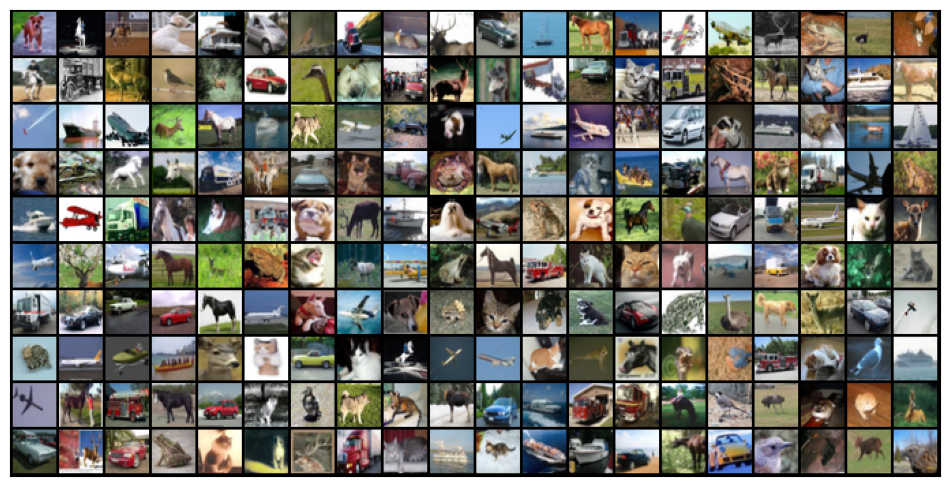

In [22]:
for images,labels in train:
  fig ,ax = plt.subplots(figsize=(12,8))
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(make_grid(images,nrow=20).permute(1,2,0))
  break

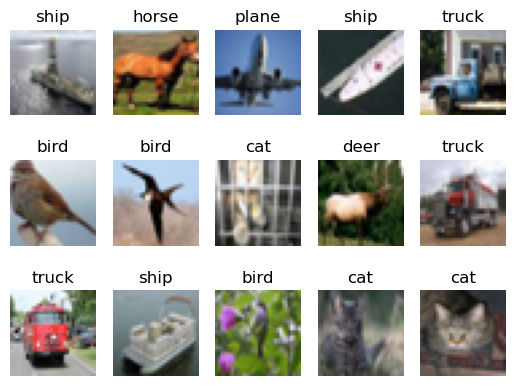

In [23]:
for i in range(0,15):
  img,label=validate_set[i]
  plt.subplot(3,5,i+1)
  plt.title(classes[label])
  plt.axis('off')
  plt.imshow(img.permute(1, 2, 0))

In [28]:
class cifar10_classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.network= nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1,stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1,stride=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1,stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1,stride=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1,stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1,stride=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Flatten(),
        nn.Linear(256 * 4 * 4, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 10)
    )
  def training_step(self,batch):
    images,labels=batch
    out=self(images)
    loss=F.cross_entropy(out,labels)
    return loss

  def accuracy(self, outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  def validation_step(self,batch):
    images,labels=batch
    out=self(images)
    loss=F.cross_entropy(out,labels)
    accuracy=self.accuracy(out,labels)

    return{"loss" :loss , "accuracy":accuracy}

  def validation_epoch_end(self,outputs):
    batch_losses = [row["loss"] for row in outputs]
    epoch_losses = torch.stack(batch_losses).mean()
    batch_acc = [row["accuracy"] for row in outputs]
    epoch_acc = torch.stack(batch_acc).mean()

    return {"loss":epoch_losses.item(),"accuracy":epoch_acc.item()}

  def forward(self,x):
        output = self.network(x)
        return output

evaluating the model

In [29]:
@torch.no_grad() #we will not store the gradients
def evaluate_model(model,validationLoader):
  model.eval()
  out=[model.validation_step(batch) for batch in validationLoader]
  return model.validation_epoch_end(out)

In [30]:
def train_model(epochs,lr,model,trainLoader,validationLoader,optimizationFunction=torch.optim.SGD):
  optimizer = optimizationFunction(model.parameters(),lr)

  for epoch in  range(epochs):
    print(f"training epoch {epoch}")

    model.train()
    training_losses=[]

    for batch in trainLoader:
      loss = model.training_step(batch)
      training_losses.append(loss)   
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    print(f"after training epoch {epoch} we get results {evaluate_model(model, validationLoader)}")



In [31]:
model = cifar10_classifier()
evaluate_model(model,validate)

tensor([[-0.0243, -0.0130, -0.0030,  ..., -0.0015, -0.0386, -0.0024],
        [-0.0242, -0.0130, -0.0031,  ..., -0.0016, -0.0387, -0.0024],
        [-0.0240, -0.0129, -0.0030,  ..., -0.0020, -0.0387, -0.0021],
        ...,
        [-0.0241, -0.0129, -0.0031,  ..., -0.0017, -0.0387, -0.0023],
        [-0.0240, -0.0129, -0.0030,  ..., -0.0016, -0.0388, -0.0023],
        [-0.0240, -0.0128, -0.0031,  ..., -0.0020, -0.0387, -0.0022]])
tensor([[-0.0241, -0.0130, -0.0030,  ..., -0.0018, -0.0388, -0.0020],
        [-0.0239, -0.0129, -0.0030,  ..., -0.0019, -0.0387, -0.0022],
        [-0.0244, -0.0130, -0.0031,  ..., -0.0017, -0.0386, -0.0023],
        ...,
        [-0.0242, -0.0129, -0.0031,  ..., -0.0018, -0.0387, -0.0023],
        [-0.0240, -0.0130, -0.0031,  ..., -0.0021, -0.0388, -0.0023],
        [-0.0239, -0.0128, -0.0030,  ..., -0.0019, -0.0388, -0.0021]])
tensor([[-0.0242, -0.0131, -0.0032,  ..., -0.0019, -0.0389, -0.0024],
        [-0.0242, -0.0130, -0.0032,  ..., -0.0020, -0.0387, -0

tensor([[-0.0241, -0.0129, -0.0031,  ..., -0.0019, -0.0387, -0.0023],
        [-0.0239, -0.0131, -0.0029,  ..., -0.0019, -0.0387, -0.0021],
        [-0.0241, -0.0128, -0.0031,  ..., -0.0019, -0.0387, -0.0022],
        ...,
        [-0.0241, -0.0130, -0.0032,  ..., -0.0019, -0.0387, -0.0023],
        [-0.0241, -0.0129, -0.0032,  ..., -0.0019, -0.0387, -0.0022],
        [-0.0241, -0.0129, -0.0030,  ..., -0.0018, -0.0387, -0.0023]])
tensor([[-0.0241, -0.0129, -0.0030,  ..., -0.0020, -0.0387, -0.0021],
        [-0.0241, -0.0130, -0.0030,  ..., -0.0018, -0.0388, -0.0022],
        [-0.0240, -0.0130, -0.0031,  ..., -0.0019, -0.0388, -0.0022],
        ...,
        [-0.0241, -0.0130, -0.0031,  ..., -0.0018, -0.0388, -0.0022],
        [-0.0240, -0.0129, -0.0030,  ..., -0.0019, -0.0387, -0.0021],
        [-0.0243, -0.0130, -0.0031,  ..., -0.0019, -0.0388, -0.0023]])
tensor([[-0.0241, -0.0130, -0.0033,  ..., -0.0020, -0.0388, -0.0022],
        [-0.0241, -0.0131, -0.0031,  ..., -0.0020, -0.0387, -0

{'loss': 2.303027868270874, 'accuracy': 0.09480000287294388}

In [32]:
# %%time
train_model(7, 0.001, model, trainLoader=train, validationLoader=validate, optimizationFunction=torch.optim.Adam)

training epoch 0
tensor([[-0.0241, -0.0129, -0.0031,  ..., -0.0019, -0.0387, -0.0022],
        [-0.0238, -0.0130, -0.0030,  ..., -0.0020, -0.0388, -0.0021],
        [-0.0241, -0.0129, -0.0031,  ..., -0.0020, -0.0388, -0.0022],
        ...,
        [-0.0241, -0.0130, -0.0031,  ..., -0.0018, -0.0388, -0.0021],
        [-0.0241, -0.0130, -0.0031,  ..., -0.0020, -0.0389, -0.0021],
        [-0.0239, -0.0129, -0.0031,  ..., -0.0019, -0.0387, -0.0022]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.0415, -0.0349,  0.0371,  ..., -0.0305,  0.0105,  0.0372],
        [-0.0410, -0.0345,  0.0363,  ..., -0.0292,  0.0081,  0.0344],
        [-0.0409, -0.0346,  0.0366,  ..., -0.0296,  0.0089,  0.0356],
        ...,
        [-0.0416, -0.0348,  0.0372,  ..., -0.0299,  0.0100,  0.0366],
        [-0.0419, -0.0357,  0.0381,  ..., -0.0307,  0.0114,  0.0376],
        [-0.0415, -0.0350,  0.0372,  ..., -0.0299,  0.0097,  0.0362]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.1064,  0.0784,  0.0869,  ..., -0.1915

tensor([[ 0.3483,  0.3965,  0.1214,  ...,  0.0389,  0.4937,  0.3127],
        [ 0.1753,  0.1845,  0.0864,  ..., -0.0058,  0.2343,  0.1142],
        [ 0.0481,  0.0887,  0.0569,  ...,  0.0326,  0.1074,  0.1326],
        ...,
        [ 0.6365,  0.7118,  0.1854,  ...,  0.0709,  0.8846,  0.5280],
        [ 0.0224,  0.0517,  0.0491,  ...,  0.0111,  0.0662,  0.0912],
        [ 0.2045,  0.2688,  0.0929,  ...,  0.0662,  0.3307,  0.2771]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.2494,  0.2342,  0.0234,  ...,  0.0445,  0.4221,  0.3103],
        [-0.0202, -0.0198,  0.0615,  ..., -0.0237, -0.0017,  0.0051],
        [ 0.1710,  0.1610,  0.0215,  ...,  0.0200,  0.2959,  0.2192],
        ...,
        [-0.0351, -0.0187,  0.0572,  ..., -0.0108, -0.0049,  0.0316],
        [-0.0472, -0.0330,  0.0686,  ..., -0.0192, -0.0337,  0.0021],
        [-0.0460, -0.0314,  0.0669,  ..., -0.0173, -0.0299,  0.0076]],
       grad_fn=<AddmmBackward0>)
tensor([[ 6.3448e-01,  4.0542e-01, -1.0894e-01,  ..., -1.9315e-01,

tensor([[-2.2204, -1.8059,  1.3332,  ..., -0.7152, -2.0307, -2.6368],
        [ 0.3340,  0.1505, -0.2582,  ..., -0.2537,  0.3529, -0.0143],
        [-2.1718, -1.7659,  1.3041,  ..., -0.6991, -1.9856, -2.5769],
        ...,
        [-1.5721, -1.2818,  0.9499,  ..., -0.5225, -1.4430, -1.8828],
        [-2.0343, -1.6529,  1.2225,  ..., -0.6546, -1.8582, -2.4084],
        [-1.3796, -1.1153,  0.8317,  ..., -0.4384, -1.2520, -1.6036]],
       grad_fn=<AddmmBackward0>)
tensor([[ 2.2540,  1.0613, -1.2077,  ..., -0.8730,  1.9518,  0.7103],
        [-1.4763, -1.1466,  0.8788,  ..., -0.3497, -1.4047, -1.7394],
        [ 0.3867,  0.5270, -0.6382,  ...,  0.3730,  0.8009,  0.9550],
        ...,
        [ 1.7507,  1.9591, -2.2180,  ...,  1.2354,  3.0654,  3.8055],
        [ 0.7761,  0.1529, -0.2398,  ..., -0.5578,  0.3936, -0.3154],
        [ 2.1376,  0.9658, -1.1106,  ..., -0.8611,  1.8141,  0.6150]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.8462,  0.9900, -0.8320,  ...,  0.3775,  1.1674,  1.244

tensor([[-2.0161, -1.1030,  0.7907,  ...,  0.2678, -2.1952, -2.0845],
        [-2.4820, -1.3650,  0.9722,  ...,  0.3287, -2.7149, -2.5925],
        [-2.4770, -1.3628,  0.9699,  ...,  0.3282, -2.7096, -2.5871],
        ...,
        [-0.5629,  0.0617,  0.2979,  ..., -0.8579, -0.4249, -1.3194],
        [ 0.3297,  0.3606,  0.0118,  ..., -0.2940,  0.3535,  0.2615],
        [-2.0154, -1.0930,  0.7805,  ...,  0.2525, -2.1876, -2.0945]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.6490,  0.4980,  0.2322,  ..., -1.2531,  0.5592, -0.2909],
        [-0.1585, -0.0188,  0.1430,  ..., -0.3650, -0.1040, -0.4126],
        [ 1.5705,  1.3768,  0.3258,  ..., -2.5025,  1.4045, -0.2363],
        ...,
        [ 0.7741,  1.1081,  0.0392,  ..., -1.2337,  0.8557,  0.1661],
        [-1.2889, -0.5379,  0.2954,  ..., -0.1039, -1.2362, -1.4960],
        [-0.6572, -0.3775,  0.0901,  ...,  0.8210, -0.6322, -0.0229]],
       grad_fn=<AddmmBackward0>)
tensor([[ 1.6431,  1.5928,  0.1301,  ..., -2.1491,  1.5716,  0.435

tensor([[ 0.9004,  0.2584,  0.0531,  ..., -0.8359,  0.9017,  0.4288],
        [-0.5643, -1.1613,  0.1785,  ...,  2.0593, -1.1598,  0.4626],
        [-0.4233, -0.2097,  0.0434,  ..., -0.1556, -0.3716, -0.4245],
        ...,
        [-1.9111, -2.0164,  1.3133,  ...,  0.0982, -2.8578, -2.0179],
        [-0.6805, -0.6039,  0.1086,  ..., -0.2032, -0.7186, -0.7462],
        [-0.8326, -0.6162,  0.2688,  ...,  0.5029, -1.0384, -0.4961]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.4844, -1.3435,  0.0452,  ...,  2.5800, -1.2468,  0.8458],
        [ 1.5613,  1.6325, -0.3398,  ..., -1.4504,  2.0726,  1.5154],
        [ 1.0543,  2.6008, -0.6798,  ..., -1.4451,  1.8622,  1.4607],
        ...,
        [ 0.3586,  0.5520, -0.3815,  ...,  0.5983,  0.4591,  1.2245],
        [-2.0854, -2.2595,  1.3811,  ...,  0.0650, -3.1478, -2.2389],
        [ 1.1180,  0.8883, -0.2254,  ..., -0.7776,  1.4019,  1.1696]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.2096, -0.9300, -0.0754,  ...,  1.8545, -0.7623,  0.895

tensor([[-0.0222, -1.3578,  0.3609,  ..., -0.7811, -0.0822, -1.3599],
        [ 2.5916,  0.4642,  0.1319,  ..., -2.3384,  2.2867,  0.7427],
        [ 0.6700,  0.4706, -0.3976,  ...,  0.2476,  0.2840,  1.5987],
        ...,
        [-0.8729, -0.1354,  0.0841,  ...,  0.1949, -1.0066, -0.6386],
        [-1.5725, -1.7748,  0.6111,  ...,  0.2748, -1.9901, -1.7526],
        [-3.0211, -3.1951,  1.7583,  ...,  0.5585, -4.5088, -3.4199]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.6683,  0.1084, -0.0434,  ...,  0.1383, -0.7116, -0.2634],
        [-2.9459, -3.0877,  1.7686,  ...,  0.5584, -4.4180, -3.3429],
        [-3.1331, -3.3096,  1.8812,  ...,  0.4521, -4.6690, -3.6553],
        ...,
        [-2.3821, -2.4419,  1.3916,  ...,  0.6179, -3.5777, -2.5661],
        [ 2.4015,  0.4532,  0.2623,  ..., -2.4549,  2.0428,  0.2770],
        [-1.4981, -1.0634,  0.5667,  ...,  0.8281, -2.1663, -1.1445]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.5082, -0.0341,  0.0221,  ..., -0.1010, -0.4255, -0.419

tensor([[ 1.0922e-01, -1.1361e+00,  2.5167e-01,  ..., -5.2080e-01,
          4.3710e-03, -1.1463e+00],
        [ 4.9492e-01,  1.1934e+00, -2.6632e-01,  ..., -9.0064e-01,
          7.7437e-01,  5.8072e-01],
        [ 5.3438e-01,  1.4793e+00, -5.0129e-01,  ..., -9.8878e-01,
          1.0383e+00,  1.0272e+00],
        ...,
        [ 1.3765e+00,  3.9601e-01,  4.2867e-03,  ..., -1.4441e+00,
          1.5244e+00,  3.4008e-01],
        [-1.8639e-01, -5.3954e-01, -9.9061e-01,  ...,  1.9006e+00,
         -9.3562e-01,  1.6255e+00],
        [-2.4475e+00, -3.2055e+00,  1.4819e+00,  ...,  9.5456e-01,
         -4.5564e+00, -3.5245e+00]], grad_fn=<AddmmBackward0>)
tensor([[-1.2420, -1.7382,  0.4675,  ...,  0.2845, -1.8162, -1.7990],
        [ 0.6821,  1.3697, -0.3889,  ..., -1.0000,  0.9979,  0.9068],
        [-1.3056, -1.5505,  0.5458,  ...,  0.6442, -2.1843, -1.6592],
        ...,
        [-1.1840, -2.0800,  0.3857,  ...,  0.2859, -1.7014, -1.9065],
        [-1.2881, -1.6772,  0.4573,  ...,  0.9096

tensor([[-1.5434, -2.0111,  0.7985,  ...,  0.8845, -3.4855, -1.9953],
        [-1.1259, -1.5009,  0.4152,  ...,  0.0985, -1.7232, -1.4378],
        [-0.7574, -0.6256,  0.1202,  ...,  0.0712, -0.8601, -0.6389],
        ...,
        [ 1.0235,  3.0577, -2.1745,  ..., -1.3326,  1.5435,  3.4050],
        [ 0.7896, -0.9334,  0.1443,  ..., -0.4554,  0.4421, -0.3626],
        [-1.6574, -2.1916,  0.4580,  ...,  1.2006, -3.2803, -1.8379]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.1827, -0.0780, -0.5127,  ...,  0.3399, -0.3719,  0.5514],
        [-0.0966, -1.8554,  0.3509,  ..., -0.2082, -0.4720, -1.3495],
        [-1.3232, -1.7495,  0.4979,  ...,  0.1739, -2.0890, -1.6969],
        ...,
        [ 1.8907, -1.1210,  0.2631,  ..., -1.7059,  1.8201, -0.6582],
        [ 1.9444,  1.7656, -1.6763,  ..., -1.6697,  2.8398,  2.9228],
        [ 0.3942,  1.0926, -0.5492,  ..., -0.3012, -0.1839,  1.0272]],
       grad_fn=<AddmmBackward0>)
tensor([[ 1.5521,  1.7632, -1.5282,  ..., -2.1533,  3.0802,  2.409

tensor([[-1.1277,  1.1660, -0.2354,  ..., -0.6505, -0.5551,  0.1504],
        [ 2.1977, -0.3058,  0.1897,  ..., -2.0315,  2.6889, -0.4961],
        [ 0.1349, -0.0100, -0.6653,  ...,  1.3485, -0.9518,  0.9558],
        ...,
        [-1.6566, -2.9493,  0.9040,  ...,  0.4151, -2.6910, -2.6336],
        [-2.4131, -4.1911,  2.5658,  ...,  0.2695, -6.5781, -5.0207],
        [-0.4503, -0.2398,  0.8248,  ...,  0.3509, -2.5084, -0.8883]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.1007, -0.6509,  0.0907,  ...,  1.1301, -1.1030, -0.1601],
        [-1.0504, -0.3563,  0.2041,  ..., -0.2024, -1.1308, -0.6577],
        [-1.8316, -2.8954,  1.6284,  ..., -0.0859, -4.0840, -3.3941],
        ...,
        [ 1.2037,  0.6283, -0.6475,  ..., -1.0369,  2.0003,  0.7535],
        [-0.9875, -1.2449,  0.7035,  ...,  0.0050, -1.9067, -1.4393],
        [-0.0155,  0.6689,  0.7140,  ...,  0.4130, -2.7636, -0.5483]],
       grad_fn=<AddmmBackward0>)
tensor([[-1.6949e+00, -2.0174e+00,  1.2039e+00,  ...,  1.1112e-03,

tensor([[ 1.3225, -0.6851,  0.2621,  ..., -0.6938,  0.9630, -0.1812],
        [ 0.6679,  3.2207, -2.4291,  ..., -2.4700,  2.7038,  3.8669],
        [-1.6926, -2.9965,  1.1270,  ...,  0.3196, -2.6421, -2.7743],
        ...,
        [ 1.5952,  0.8284, -0.9716,  ...,  0.2472, -0.1068,  2.3697],
        [-0.1308,  0.1172,  0.2871,  ...,  0.0871, -1.7395, -0.3705],
        [-1.2007,  0.6396, -0.5466,  ..., -1.0430,  0.3549,  0.1319]],
       grad_fn=<AddmmBackward0>)
tensor([[-1.1478, -0.4755,  0.2748,  ..., -0.4717, -1.4439, -0.9706],
        [-0.5081, -1.1602,  0.2776,  ..., -0.3374, -0.2467, -1.1146],
        [ 2.0946,  1.3183, -0.7367,  ..., -1.0652,  1.0498,  1.9025],
        ...,
        [-1.2529, -2.9729,  1.3973,  ...,  0.2363, -3.6495, -2.9862],
        [-1.7050, -3.4690,  0.9698,  ...,  0.8046, -3.1322, -2.6156],
        [-0.9556, -1.1074,  0.3467,  ...,  0.1238, -1.7266, -1.0244]],
       grad_fn=<AddmmBackward0>)
tensor([[-3.1794e-01, -1.0736e+00,  9.9934e-01,  ...,  3.8247e-01,

tensor([[-9.1750e-01, -2.0566e+00,  1.2435e+00,  ...,  8.0067e-02,
         -2.6985e+00, -2.1911e+00],
        [-5.5615e-01, -2.3266e+00, -1.3375e-01,  ...,  3.2952e+00,
         -3.7189e+00, -5.9802e-01],
        [ 3.7475e+00, -9.8287e-01,  9.0551e-01,  ..., -2.2121e+00,
          3.1605e+00, -1.3482e+00],
        ...,
        [ 7.9734e-01, -2.2302e-01, -4.3788e-03,  ..., -8.2333e-01,
          1.2558e+00, -8.0407e-02],
        [-1.2262e+00, -3.3122e+00,  1.6841e+00,  ...,  3.3985e-01,
         -3.6300e+00, -3.3499e+00],
        [-1.7403e+00, -4.0554e+00,  2.3965e+00,  ..., -2.1000e-01,
         -4.7574e+00, -4.3929e+00]], grad_fn=<AddmmBackward0>)
tensor([[-0.2552,  0.9589, -0.7251,  ..., -1.7811,  1.4787,  0.1522],
        [-0.4417,  0.1534, -0.7041,  ...,  0.4694, -0.6506,  0.9315],
        [-0.3886, -1.0897, -0.6006,  ...,  1.8123, -1.7657,  0.4408],
        ...,
        [-0.9676, -2.2547,  1.2003,  ...,  0.3844, -2.8458, -2.2824],
        [-1.4127, -3.7578,  1.8862,  ...,  0.9763

tensor([[-1.7178,  0.9299, -1.4551,  ..., -0.8132, -1.3624,  2.3645],
        [-2.3955, -0.7123, -0.2669,  ..., -0.9193, -0.9394, -0.7009],
        [ 1.8095, -1.1882,  0.6120,  ..., -0.7180,  0.6947, -1.1473],
        ...,
        [-2.0997, -2.9212,  0.2825,  ...,  0.6954, -2.3267, -1.7595],
        [-2.7084, -3.5763,  1.1014,  ...,  0.2920, -3.3244, -3.1253],
        [-2.3295, -3.9325,  1.8328,  ...,  0.1670, -4.0567, -3.8329]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.6906, -0.8510, -0.0094,  ...,  0.1630, -0.7385, -0.1729],
        [-0.0283,  2.2220, -0.7770,  ..., -1.5390, -0.0939,  1.1548],
        [-1.7534, -3.3179,  1.8458,  ..., -0.1900, -3.3837, -3.4738],
        ...,
        [-0.5614, -0.5192,  0.5433,  ..., -0.0659, -0.9796, -0.7304],
        [-0.3055, -0.5052, -0.0430,  ..., -0.1223, -0.1752,  0.0534],
        [-1.4320, -2.0364, -0.0138,  ...,  0.0396, -1.3363, -0.9276]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.1314, -2.4962,  0.7945,  ..., -0.6112, -0.2486, -2.412

tensor([[-1.9279, -3.3963,  0.0396,  ...,  1.6608, -2.8437, -1.8347],
        [-2.2771, -4.1952,  0.5396,  ...,  1.5781, -3.1038, -3.0980],
        [-1.5542, -3.3655,  0.5296,  ...,  4.0581, -5.4785, -2.7407],
        ...,
        [-0.0976,  0.9920, -0.6912,  ..., -0.7268, -0.1866,  0.7728],
        [-0.8774, -1.8141,  0.3608,  ...,  1.1592, -1.8509, -1.2080],
        [-3.5102, -4.4174,  1.1735,  ..., -0.4133, -4.3791, -3.6287]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.8835, -2.9097,  1.2601,  ...,  2.9558, -5.0026, -3.0951],
        [-3.1039, -3.9631,  0.8390,  ...,  0.3549, -3.9316, -3.1659],
        [ 3.3789,  0.1815, -0.6521,  ..., -2.9094,  4.4434, -0.6252],
        ...,
        [-2.6563, -2.9920,  0.3111,  ...,  2.3454, -3.9573, -2.0567],
        [-2.1904, -2.1820,  0.5160,  ..., -0.6385, -2.8122, -1.7237],
        [-1.6166, -2.9267,  1.1089,  ...,  1.2666, -3.6417, -2.7528]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.0492,  3.2501, -1.8475,  ..., -1.4837, -0.0756,  2.516

tensor([[ 3.3665,  1.0980, -0.6492,  ..., -3.4304,  3.4492, -0.3972],
        [-1.4003, -1.4498, -0.0613,  ...,  0.2607, -1.7990, -0.3319],
        [ 3.6162, -1.2867,  0.2475,  ..., -2.3173,  3.3251, -1.7184],
        ...,
        [ 0.6735, -2.8601,  0.8258,  ...,  0.4441, -0.6795, -1.8152],
        [ 0.0101,  4.1530, -1.9875,  ..., -3.3250, -0.4201,  3.0029],
        [ 0.4151, -1.2920,  0.5984,  ..., -0.6123,  0.1184, -0.9109]],
       grad_fn=<AddmmBackward0>)
tensor([[-1.1294, -0.3708, -0.5087,  ..., -0.0668, -1.3282,  1.1540],
        [-0.2552, -3.0432,  1.5577,  ..., -0.0091, -2.1425, -2.8751],
        [-0.6279, -2.9406,  1.8303,  ...,  0.6159, -3.4793, -2.8875],
        ...,
        [ 0.9812, -1.0563,  0.7122,  ..., -0.0330, -0.8083, -0.9186],
        [-2.7507, -3.7312,  0.4137,  ..., -0.2217, -2.6157, -2.2928],
        [-0.3166, -1.3033, -0.3693,  ...,  0.6102, -1.0291,  0.4071]])
tensor([[ 1.9161, -2.9584,  1.2434,  ..., -1.4043,  0.9566, -2.8638],
        [-1.0107, -1.9933,  0

tensor([[ 1.3164, -3.6617,  1.4679,  ...,  0.7588, -1.2924, -2.8598],
        [-0.8240, -3.8522,  1.6689,  ..., -0.5679, -1.9273, -3.4790],
        [ 3.2417, -0.6414, -0.3086,  ..., -2.8876,  4.3434, -1.0442],
        ...,
        [ 0.3594,  0.4774,  0.1408,  ..., -0.5032, -0.9095, -0.1621],
        [-0.9012, -3.6025,  1.7590,  ...,  1.6779, -4.2746, -2.9545],
        [-0.3873, -2.9452, -0.0264,  ...,  3.7954, -4.2850, -0.1407]])
tensor([[ 1.6125, -1.2056, -0.0411,  ..., -1.5810,  2.6452, -0.7428],
        [-1.1751,  0.4820, -1.5468,  ..., -0.2384, -1.8109,  2.5919],
        [-2.2727, -3.9583,  0.6442,  ...,  0.2245, -3.2448, -2.6999],
        ...,
        [-0.4852,  3.0648, -2.3261,  ..., -2.2687, -1.2071,  3.9520],
        [ 0.2936, -0.0167, -0.8020,  ...,  0.0743, -0.4446,  1.7503],
        [ 2.2307,  0.1672, -1.0453,  ..., -2.4141,  3.7161,  0.4558]])
tensor([[-0.3814, -3.9896,  0.6928,  ..., -0.2511, -1.0830, -2.6974],
        [ 4.0560, -1.4094,  0.5143,  ..., -2.6783,  3.6058, -2

tensor([[ 0.4178,  2.6746, -1.6338,  ..., -2.4707,  1.4588,  1.5173],
        [-1.0181, -2.2925,  1.4176,  ...,  1.2261, -3.6297, -2.8935],
        [-1.1716, -4.6115,  3.5628,  ..., -0.2402, -5.4791, -5.8151],
        ...,
        [ 1.8445,  0.6105, -0.6651,  ..., -1.5796,  1.9310,  0.6711],
        [-3.4346, -5.8204,  0.5290,  ...,  1.8681, -5.9705, -5.3060],
        [ 0.4484, -1.0246,  1.2190,  ..., -0.5527, -1.8489, -2.1455]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.7838,  4.0133, -1.3829,  ..., -2.2322, -1.5433,  1.5113],
        [-2.2075, -2.7147, -0.4272,  ..., -0.0428, -1.9404, -1.2383],
        [-0.6475,  0.4304, -0.7622,  ..., -1.1130, -0.4801,  0.3641],
        ...,
        [-3.1561, -3.8209, -0.2281,  ..., -0.1659, -3.0237, -2.7502],
        [-0.3177, -3.6892,  0.9135,  ...,  0.8151, -2.0559, -3.2774],
        [ 2.0675,  0.6905, -0.7996,  ..., -2.0874,  2.5918,  0.6003]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.8363, -2.5559,  0.2324,  ...,  1.7401, -1.1624, -1.518

tensor([[ 0.0525,  1.5694, -1.4286,  ..., -0.6365, -0.3157,  2.0721],
        [-0.4290, -2.1608,  0.2953,  ...,  1.6752, -2.9028, -2.4314],
        [ 1.6518,  0.0784, -0.3824,  ..., -1.4237,  1.0871, -0.2452],
        ...,
        [-1.5546, -3.2618,  0.3434,  ...,  0.0621, -2.2293, -2.3304],
        [ 2.5237, -4.0472,  2.1444,  ..., -1.1210, -0.3783, -3.9653],
        [-1.6443, -3.5433,  0.4614,  ...,  3.4838, -5.4053, -3.5363]],
       grad_fn=<AddmmBackward0>)
tensor([[-1.0533, -3.7805,  2.8778,  ..., -0.8464, -4.9300, -4.6601],
        [ 1.4056, -1.6903,  2.4072,  ..., -0.2746, -2.6473, -3.2319],
        [ 1.2027,  1.7924, -2.8575,  ..., -1.0918,  1.1031,  4.7192],
        ...,
        [ 0.4571,  3.1159, -1.7362,  ..., -2.1003,  0.7947,  1.2775],
        [-0.6123, -3.2096,  2.0112,  ...,  0.2851, -3.2469, -3.9334],
        [ 0.3885, -2.1659,  0.7752,  ..., -1.1655, -0.0785, -2.1951]],
       grad_fn=<AddmmBackward0>)
tensor([[-2.4795, -2.1690, -1.3491,  ...,  1.7140, -2.9200,  0.361

tensor([[-2.2559, -1.4863,  0.4655,  ..., -1.2012, -2.7653, -2.4507],
        [ 0.5475, -1.2019, -0.6709,  ...,  0.4584, -0.0352,  1.0849],
        [ 1.2676, -0.1088, -1.2932,  ..., -2.5389,  3.4931,  0.3268],
        ...,
        [-1.6377, -3.1725,  0.4169,  ...,  3.1175, -5.1932, -2.4227],
        [ 4.0505,  1.2770, -0.8550,  ..., -3.1134,  2.4642, -0.2394],
        [ 0.4009,  0.3791, -0.6025,  ..., -0.5413,  0.4258,  0.8304]],
       grad_fn=<AddmmBackward0>)
tensor([[-2.7527, -2.6541, -0.1463,  ..., -0.5397, -2.6503, -0.9220],
        [ 0.1668,  2.8343, -1.1378,  ..., -1.6353, -0.5073,  0.6704],
        [ 1.5777,  0.8146, -0.4308,  ..., -1.2515,  0.4939, -0.0081],
        ...,
        [ 1.9256, -1.0081, -0.5783,  ..., -3.2083,  4.1644, -0.8959],
        [-2.7098, -4.5063,  0.7771,  ...,  4.0017, -6.8149, -4.1970],
        [-0.7671,  2.3271, -2.4121,  ..., -0.6482, -0.9064,  3.3131]],
       grad_fn=<AddmmBackward0>)
tensor([[-2.8244, -3.0985,  0.4165,  ...,  1.1858, -3.8247, -2.702

tensor([[-1.6380, -3.9793,  0.6900,  ...,  2.7299, -6.9629, -4.1094],
        [ 1.2218,  1.1611, -1.4895,  ..., -1.3376,  0.8793,  2.8630],
        [ 0.4439,  1.2440, -1.9849,  ..., -2.2687,  2.1141,  3.1821],
        ...,
        [ 0.2059,  4.0834, -2.5362,  ..., -2.9720, -0.4215,  5.0554],
        [-2.1023, -3.0780,  0.3930,  ...,  0.4743, -4.9863, -2.9504],
        [-0.8898, -0.4335, -0.3996,  ...,  0.0346, -1.2874,  2.0120]],
       grad_fn=<AddmmBackward0>)
tensor([[-1.7166, -3.4862, -0.1109,  ...,  3.7967, -5.2856, -2.7933],
        [ 0.8753,  3.1126, -2.2227,  ..., -2.8874,  1.6659,  3.6155],
        [-3.8916, -4.3974,  0.5445,  ..., -1.4746, -4.8832, -3.0292],
        ...,
        [-1.5653, -3.2458,  1.1569,  ...,  0.4053, -3.9904, -3.0271],
        [-1.6795, -3.0271,  1.3767,  ..., -0.2106, -3.1718, -3.0642],
        [-2.9176, -4.4921, -0.4769,  ...,  4.2788, -5.5578, -3.3834]],
       grad_fn=<AddmmBackward0>)
tensor([[ 1.8041,  3.7606, -2.2198,  ..., -4.0399,  2.4853,  3.380

tensor([[ 5.3393,  0.8984, -1.5624,  ..., -6.0072,  6.5043, -0.0628],
        [-2.4751,  0.6474, -1.1798,  ..., -2.7064, -1.8203,  0.1644],
        [-2.4241, -4.1171,  0.5686,  ..., -1.0813, -3.2089, -3.1432],
        ...,
        [-0.0342,  6.1494, -2.9750,  ..., -4.4376, -0.4861,  2.6470],
        [-2.7955, -3.1767,  0.4893,  ...,  3.2145, -6.6512, -3.9797],
        [ 2.5002, -0.6656, -0.9813,  ..., -3.0397,  4.3193,  0.4047]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.8123, -4.0805,  1.0620,  ...,  0.0449, -1.1028, -3.4703],
        [-0.0595,  0.5448, -1.1639,  ..., -1.0924,  1.0989,  1.7733],
        [ 3.9083, -1.3415, -0.2636,  ..., -3.7671,  5.0578, -1.1105],
        ...,
        [-4.6970, -3.7468,  0.0807,  ..., -2.3983, -4.0664, -3.3600],
        [-0.4488,  0.5021, -0.4732,  ..., -0.5688, -0.2862,  0.4179],
        [-2.1815, -3.2084,  0.8414,  ...,  1.3158, -4.2539, -3.5253]],
       grad_fn=<AddmmBackward0>)
tensor([[-2.9486, -1.7691, -0.0383,  ...,  1.4402, -3.2421, -1.890

tensor([[-1.2286, -5.4413,  1.3365,  ...,  0.7371, -2.4920, -4.1368],
        [-3.8087, -4.0600,  0.3768,  ...,  0.3071, -2.7005, -3.0794],
        [-2.6537, -3.4983,  0.4634,  ..., -0.3865, -1.7990, -1.7438],
        ...,
        [ 1.3835, -0.9183, -0.7556,  ..., -0.3644,  1.0395,  1.1017],
        [ 0.2156, -1.0438, -0.4460,  ..., -1.6151,  2.7836,  0.6212],
        [ 2.4895,  0.7748, -1.8455,  ..., -0.8007,  1.1847,  3.3985]],
       grad_fn=<AddmmBackward0>)
tensor([[ 1.5635, -1.5430,  0.4754,  ..., -0.8937,  0.8521, -0.2628],
        [ 0.5170, -1.1180,  0.9658,  ..., -0.0693, -0.8589, -1.4911],
        [-3.6890, -4.2127,  1.0512,  ...,  0.0657, -3.9290, -3.7704],
        ...,
        [-0.9320,  2.2873, -1.6176,  ..., -1.2601, -0.6813,  2.2497],
        [-2.0822, -5.4690,  3.5035,  ...,  0.1134, -5.9025, -5.7387],
        [-1.4737, -3.4173,  0.8177,  ...,  0.6445, -2.4592, -3.8451]],
       grad_fn=<AddmmBackward0>)
tensor([[-2.3481, -3.5177,  1.3831,  ...,  0.5355, -4.2402, -3.604

tensor([[-4.0239, -3.4819, -0.3755,  ..., -0.2117, -3.6306, -1.3827],
        [-0.6443,  0.9768, -0.7411,  ..., -0.7279, -0.4148,  1.6909],
        [-2.9850, -5.0578,  1.7184,  ...,  0.2972, -4.4449, -4.2195],
        ...,
        [-1.5692, -2.7335,  0.5462,  ...,  3.4621, -5.1772, -2.8400],
        [-3.9242, -3.6282, -0.3173,  ..., -0.2002, -4.4665, -2.3354],
        [ 0.2505,  5.3412, -2.5837,  ..., -3.1351, -0.8593,  3.4723]],
       grad_fn=<AddmmBackward0>)
tensor([[ 2.0885, -2.8281,  1.1426,  ..., -1.2902,  1.0071, -2.1196],
        [-2.4166, -3.1510, -0.8529,  ...,  4.0341, -4.9073, -2.2692],
        [ 4.2339, -0.0923, -0.1239,  ..., -2.7528,  2.8224, -1.1390],
        ...,
        [-0.1241, -3.6569,  1.4398,  ...,  2.1223, -3.1653, -1.2447],
        [-2.1383, -1.7882,  0.4093,  ...,  0.4782, -1.9689, -0.8912],
        [ 3.8289,  0.1391, -1.2710,  ..., -3.7733,  5.1220, -0.4814]],
       grad_fn=<AddmmBackward0>)
tensor([[-1.1473,  3.0425, -1.9086,  ..., -2.0749, -0.2369,  1.563

tensor([[-0.6933,  0.1677, -0.5723,  ...,  2.7370, -4.7128,  0.6623],
        [-4.8338, -5.0192,  0.8136,  ..., -1.1201, -5.6182, -3.3065],
        [ 0.8620,  2.6260, -2.0778,  ..., -2.6720,  2.2705,  1.8762],
        ...,
        [ 0.8090, -0.0079, -0.1764,  ..., -1.5244,  1.6295, -0.3523],
        [-2.2375,  0.6501, -1.5460,  ..., -1.0308, -2.4105,  2.2473],
        [ 2.5593, -0.4959, -0.0283,  ..., -0.4629,  0.8175, -0.2744]],
       grad_fn=<AddmmBackward0>)
tensor([[-3.1009, -5.5703,  2.1434,  ..., -0.1669, -4.0313, -4.4044],
        [-2.5592, -2.9638, -0.0223,  ..., -1.0108, -1.1775, -1.0882],
        [-2.3189, -2.6641,  0.5023,  ...,  2.8853, -6.5594, -3.2048],
        ...,
        [-0.1910,  2.8018, -2.1013,  ..., -3.1570, -0.5385,  1.7237],
        [ 1.1152, -4.2568,  2.0098,  ..., -1.7306, -0.4112, -3.6537],
        [-4.1175, -4.1218,  0.3041,  ..., -0.6942, -4.8849, -3.1909]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.4405,  1.7771, -0.2610,  ..., -2.0358, -0.5709,  0.609

tensor([[-0.5166, -1.1749, -0.0833,  ..., -0.0478, -1.5164, -0.8653],
        [-1.0890, -2.2550, -0.1062,  ...,  0.4357, -1.8127, -1.5514],
        [-1.2116, -5.4908,  1.8696,  ...,  3.5648, -5.9337, -5.2249],
        ...,
        [ 3.3778, -2.3539,  0.6634,  ..., -1.6435,  2.1137, -2.1234],
        [-0.7899, -2.9349,  0.3814,  ...,  1.5592, -2.4688, -3.1513],
        [-1.2586, -1.3394, -2.0775,  ...,  0.2530, -0.2291,  3.4849]],
       grad_fn=<AddmmBackward0>)
tensor([[ 1.6942, -2.7425,  0.3973,  ...,  1.2541, -1.2781, -2.1339],
        [-0.3037,  5.4071, -3.5286,  ..., -3.8445,  0.1877,  4.4267],
        [ 3.2304, -3.3593,  0.5114,  ..., -2.0420,  2.4955, -1.9085],
        ...,
        [-2.6752, -5.7129,  0.6964,  ..., -1.6148, -3.2276, -3.1277],
        [-0.4959, -1.1471, -0.0503,  ..., -1.0855, -0.3673, -0.2484],
        [ 1.1065,  4.4453, -3.4994,  ..., -4.3488,  3.0827,  2.8429]],
       grad_fn=<AddmmBackward0>)
tensor([[ 2.4736e+00, -1.7649e+00, -4.6506e-01,  ..., -2.2813e+00,

tensor([[-2.7363, -3.9705,  0.9537,  ...,  1.4101, -3.3284, -3.6036],
        [ 3.4905,  1.3054, -1.2792,  ..., -4.7503,  4.6029, -0.9247],
        [-3.3995, -6.1554,  0.8276,  ...,  3.1553, -3.9144, -5.2786],
        ...,
        [-1.3004,  1.2690, -0.5927,  ..., -1.2653, -1.3766,  0.8765],
        [ 3.6750, -5.7520,  2.8414,  ..., -1.3646, -0.7643, -4.9959],
        [-3.9883, -4.9392, -0.1469,  ..., -0.5864, -4.1779, -4.0312]],
       grad_fn=<AddmmBackward0>)
tensor([[-2.2126, -1.2496, -0.3774,  ..., -3.6301, -2.5088, -1.4934],
        [-1.1075,  5.9725, -2.6557,  ..., -2.6571, -1.1790,  2.9429],
        [-2.3273, -3.5644, -0.1840,  ..., -0.7922, -2.4308, -2.7038],
        ...,
        [-0.8634,  1.3237, -2.4119,  ..., -0.4657, -0.5088,  4.5623],
        [-3.1033, -4.9643,  0.2750,  ...,  1.9704, -6.1629, -5.4199],
        [ 2.3622,  0.8273, -0.4098,  ..., -1.5042,  0.3945,  0.5615]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.9380, -0.6589, -2.1220,  ...,  0.6791, -0.7838,  4.205

tensor([[ 0.5977, -2.9872,  0.3449,  ..., -0.3457,  0.0547, -1.9871],
        [-2.7308, -4.8374,  1.6690,  ...,  0.6454, -4.5073, -4.4210],
        [ 0.0887, -0.1913, -0.2877,  ..., -2.2600,  1.7012, -0.6649],
        ...,
        [-0.7161, -2.1580,  1.2569,  ..., -0.1127, -1.6851, -1.7669],
        [ 0.5409, -2.3793,  0.3742,  ..., -1.3964, -0.8790, -2.7174],
        [-2.1063, -5.4349,  1.9209,  ...,  0.6614, -4.1320, -4.4722]],
       grad_fn=<AddmmBackward0>)
tensor([[ 2.6159, -1.9610, -0.6694,  ..., -2.0169,  3.4693, -0.4335],
        [ 0.5887, -2.2152, -0.5868,  ...,  1.6174,  0.1230,  0.0939],
        [-0.3449, -4.0537,  2.3124,  ...,  0.1535, -2.7499, -3.5507],
        ...,
        [-0.0299,  2.7903, -1.8873,  ..., -2.5440, -0.6725,  3.0885],
        [ 2.1928, -1.3811, -1.3287,  ..., -2.5943,  5.5985,  0.0593],
        [-0.5159,  1.4351, -2.4716,  ..., -1.7651,  0.6142,  3.3537]],
       grad_fn=<AddmmBackward0>)
tensor([[-1.8580,  2.0972, -2.0128,  ..., -2.1900, -0.7740,  3.135

tensor([[-3.1123, -4.3429,  0.9355,  ..., -0.8562, -5.5263, -4.0982],
        [ 2.7070, -0.9229,  0.0492,  ..., -2.2273,  1.8544, -1.4192],
        [ 1.5786, -1.5518,  0.6302,  ..., -2.9075,  2.3192, -1.8775],
        ...,
        [-2.6637, -4.2666,  0.2496,  ...,  5.6867, -7.2945, -4.5335],
        [-3.3511, -2.9295, -0.9939,  ...,  1.3851, -3.4261, -0.7789],
        [-1.2935,  0.2144, -1.1215,  ...,  0.3741, -1.9832,  2.1414]],
       grad_fn=<AddmmBackward0>)
tensor([[-2.9231, -3.9764,  0.7659,  ...,  0.8448, -3.1971, -3.7539],
        [-0.2342,  1.2565, -1.5583,  ..., -1.2528, -0.7700,  1.3751],
        [-1.7060, -1.8597, -0.9224,  ...,  1.6099, -1.9155, -1.0703],
        ...,
        [-0.4223,  3.8607, -4.0180,  ..., -3.5744, -0.7449,  5.5301],
        [ 1.1932, -1.1380,  0.1264,  ..., -1.9222,  2.4024, -1.6444],
        [-3.0786, -3.7465,  0.6490,  ..., -1.2784, -3.9504, -3.1469]],
       grad_fn=<AddmmBackward0>)
tensor([[-2.9465e+00, -2.7494e+00,  6.4321e-01,  ..., -3.9904e-01,

tensor([[ 2.3222, -0.7267, -0.6564,  ..., -2.9944,  4.6767, -0.6532],
        [ 0.5287, -1.4880, -0.3511,  ..., -1.8396,  2.5578, -0.4030],
        [-2.3025, -1.4578, -0.8597,  ...,  4.7730, -5.7260, -1.6598],
        ...,
        [-0.2392, -1.4545,  0.6949,  ..., -0.8187, -0.3510, -1.2728],
        [-0.2573,  1.9523, -0.6427,  ..., -0.8955, -0.8866,  1.0298],
        [-1.6800, -0.1839, -1.3169,  ..., -1.4022, -1.5547,  0.3279]])
tensor([[-2.9568, -2.5778,  0.1547,  ..., -1.1572, -3.4227, -3.0287],
        [ 1.1673, -0.5491, -1.0896,  ..., -2.9187,  4.9958,  0.7155],
        [-0.4597,  1.6658, -0.8494,  ..., -0.1083, -1.8634, -0.4849],
        ...,
        [ 0.2203, -1.0262, -0.6901,  ..., -1.1496, -0.3188,  0.3071],
        [ 0.4725, -0.9999, -0.0606,  ..., -2.9675,  2.6826, -1.1043],
        [ 0.8666,  0.8168, -1.6827,  ..., -2.9392,  4.0001,  0.3030]])
tensor([[ 0.5113, -1.2048,  2.0283,  ..., -1.9637, -1.6484, -1.6826],
        [-0.1032,  2.4871, -1.0726,  ..., -1.9182, -0.9543,  0

tensor([[ 4.9696, -1.9870,  0.4468,  ..., -3.1278,  0.4912, -2.2107],
        [ 1.1924, -2.0841,  0.2816,  ..., -2.4902,  1.2502, -2.4500],
        [-4.9272, -3.0039, -0.6432,  ..., -2.0147, -4.8949, -2.7713],
        ...,
        [-1.4907,  1.5243, -1.5350,  ..., -2.0645, -2.3035,  3.4367],
        [-0.4756, -3.5389,  1.1494,  ...,  3.3693, -4.5049, -3.6160],
        [ 0.4449, -1.4720,  0.0882,  ..., -0.9663, -1.9982, -1.3209]])
tensor([[-3.0782, -4.4096,  0.2877,  ..., -2.8699, -4.1622, -3.2425],
        [-1.5194,  5.8524, -3.4814,  ..., -4.9883, -2.5934,  5.4992],
        [-1.8176, -4.2861, -0.0739,  ...,  5.0772, -4.6909, -0.7969],
        ...,
        [-1.3321,  0.1422, -0.3134,  ...,  0.6373, -2.0052,  1.1440],
        [-2.3904, -1.7688, -0.6328,  ...,  1.0284, -3.2848, -0.4752],
        [ 1.4599,  0.9086, -1.1755,  ..., -2.9866,  2.9835,  0.3306]])
tensor([[-1.7727e+00, -3.4729e+00, -6.5970e-04,  ...,  4.5862e+00,
         -5.3329e+00, -2.4750e+00],
        [-8.4673e-01,  3.0865

tensor([[-0.2454, -1.5405,  0.1849,  ...,  1.4535, -1.8680, -0.8371],
        [-3.0630, -4.5238,  0.7294,  ..., -0.6858, -4.5585, -4.2418],
        [-0.8324, -0.2548, -1.5658,  ..., -0.4447, -2.4362,  4.6882],
        ...,
        [ 2.1732, -5.9973,  2.3051,  ..., -1.1004, -1.9169, -5.0143],
        [-2.1720, -4.9261,  1.6286,  ...,  3.0699, -5.7677, -4.0932],
        [-0.8815, -4.5176,  1.8124,  ..., -1.6256, -1.3576, -3.2523]],
       grad_fn=<AddmmBackward0>)
tensor([[ 2.5098, -1.8158, -0.5467,  ..., -1.8095,  2.6129, -0.6221],
        [ 0.2953,  5.5633, -2.9649,  ..., -4.9604,  1.0259,  1.7386],
        [-1.5262,  4.0516, -2.3546,  ..., -3.6646, -2.7598,  3.7522],
        ...,
        [-3.3770, -4.9171, -0.3066,  ...,  1.7642, -4.7170, -2.9261],
        [ 2.0463, -1.3613,  0.4664,  ..., -2.3239,  2.6432, -1.1807],
        [-1.3722, -4.1789, -0.5735,  ..., -0.7453, -2.8619, -0.5505]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.8602, -2.3790,  0.8473,  ...,  1.5778, -3.4993, -1.485

tensor([[-0.6584, -3.8831,  2.5410,  ..., -0.3323, -2.3085, -2.9400],
        [ 0.3518, -1.5240, -1.4678,  ...,  0.5813, -1.4530,  2.1159],
        [ 1.7387,  0.8129, -1.4643,  ..., -3.8725,  5.0245,  0.2799],
        ...,
        [ 0.7000, -3.1123,  1.6849,  ..., -1.8390, -1.6437, -3.1470],
        [ 1.3291,  1.3223, -1.1070,  ..., -1.7694,  1.4639,  0.0232],
        [-2.0933, -5.6493,  1.9477,  ..., -0.8498, -6.1248, -4.4230]],
       grad_fn=<AddmmBackward0>)
tensor([[-1.0841, -4.1256,  2.8403,  ..., -0.4340, -3.6803, -3.5445],
        [-0.1678,  0.5540, -1.8358,  ..., -0.8611, -1.1559,  3.6439],
        [ 0.4394,  8.6256, -5.7238,  ..., -7.5669, -0.3299,  6.1509],
        ...,
        [-2.5700, -6.8538,  0.5338,  ..., -3.6402, -3.4665, -3.4832],
        [-2.3778, -2.4084, -0.7626,  ..., -1.5200, -1.7198,  0.4398],
        [ 4.5348,  1.3135, -1.3329,  ..., -6.9939,  6.3251, -1.1527]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.9636,  6.5337, -3.8037,  ..., -5.5524,  0.2234,  3.115

tensor([[ 0.5127,  8.5973, -4.3508,  ..., -7.2384,  0.5545,  2.6666],
        [-1.8502, -4.0590,  1.0930,  ...,  1.0676, -4.8300, -3.5886],
        [ 1.8023, -4.1009,  0.4612,  ...,  0.1160,  0.7207, -2.1571],
        ...,
        [-2.7349, -4.0541, -0.2102,  ...,  2.2804, -4.3141, -4.0295],
        [-2.7101, -4.6380,  1.6317,  ..., -0.4768, -4.0567, -3.7143],
        [-2.2375, -3.3640, -1.5189,  ...,  6.4412, -5.5355, -2.6476]],
       grad_fn=<AddmmBackward0>)
tensor([[ 1.9749,  0.2101, -1.1123,  ..., -3.3172,  4.3176, -0.7779],
        [-0.6054,  2.2821, -0.7989,  ..., -2.6531,  0.7828,  0.4519],
        [ 3.8780, -2.2538, -0.2992,  ..., -3.0553,  3.5289, -1.6240],
        ...,
        [ 2.1292, -1.1974, -0.1736,  ..., -3.0407,  4.5390,  0.0539],
        [ 0.5369,  2.3151, -1.2958,  ..., -2.2709,  0.7998,  0.9896],
        [-0.9116,  2.9178, -1.2490,  ..., -2.0382, -0.6307,  1.4838]],
       grad_fn=<AddmmBackward0>)
tensor([[-1.4275, -1.3372,  0.0686,  ..., -0.5440, -3.3432, -1.265

tensor([[ 4.0124, -1.3078, -0.3398,  ..., -4.4959,  2.9459, -1.3545],
        [-1.4728, -3.4739,  0.3302,  ...,  4.8964, -6.7906, -4.1525],
        [-1.9222, -1.4127, -0.3840,  ..., -1.1661, -1.0745, -3.3223],
        ...,
        [-0.4011, -4.9313,  3.8640,  ..., -0.4531, -5.0698, -4.0252],
        [-1.6861, -2.7805,  0.3168,  ...,  1.5249, -4.4810, -3.9623],
        [ 0.0398,  2.9931, -1.8857,  ..., -1.7453,  0.7761,  0.4628]],
       grad_fn=<AddmmBackward0>)
tensor([[ 1.2651,  2.4058, -3.0088,  ..., -4.4769,  5.0375,  0.8432],
        [-1.9734, -4.2635, -0.7010,  ...,  3.9775, -4.7247, -3.0517],
        [-1.4781, -3.9825,  1.1151,  ..., -1.4935, -3.5933, -4.4459],
        ...,
        [ 1.6431, -6.2161,  3.1232,  ..., -1.7430, -2.4675, -5.3255],
        [-3.7867, -6.2149,  1.0630,  ...,  1.3131, -6.0240, -5.8549],
        [-1.8678, -4.2883,  1.2874,  ...,  2.2477, -4.7032, -2.6787]],
       grad_fn=<AddmmBackward0>)
tensor([[-3.1746, -4.6912, -0.0718,  ...,  1.6125, -5.3423, -4.068

tensor([[-3.0906, -4.5679, -0.5539,  ..., -0.4222, -6.5443, -4.6097],
        [-1.3754, -0.7463, -0.6947,  ..., -1.5340,  0.3448, -0.7502],
        [-0.9607, -1.0553, -1.2135,  ..., -1.5180, -1.2333, -1.1177],
        ...,
        [ 0.5435, -2.3620, -0.5878,  ...,  2.6936, -2.7254, -0.7781],
        [-2.4154, -4.7045,  0.5228,  ...,  0.4628, -3.0748, -3.9402],
        [ 0.2267, -3.2628,  1.4813,  ..., -2.5420, -0.4933, -1.7393]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.8103, -5.2282,  0.7251,  ..., -2.8499, -0.3733, -3.5214],
        [-1.4399, -6.0568,  0.5168,  ...,  4.9865, -5.7731, -4.6251],
        [-0.1335, -2.9229,  0.4616,  ...,  1.8631, -2.3542, -1.4985],
        ...,
        [-1.5220, -3.2521, -0.6860,  ...,  2.8853, -2.7429, -2.7772],
        [ 1.5445, -1.4785,  0.0126,  ..., -4.0532,  4.9101, -0.8010],
        [-1.0914,  3.8231, -1.6829,  ..., -2.3515, -1.8742,  2.6954]],
       grad_fn=<AddmmBackward0>)
tensor([[-3.1630, -5.7134, -0.2414,  ...,  2.8155, -5.6963, -4.589

tensor([[-2.3957, -4.3241,  0.7580,  ...,  7.2067, -6.5567, -3.9689],
        [-1.6482, -1.4717, -1.3149,  ..., -1.8153, -2.1879,  6.2816],
        [ 2.0414, -1.7719,  0.4835,  ..., -0.3678,  1.2261, -0.8079],
        ...,
        [-0.1015,  3.0123, -1.7404,  ..., -3.7404, -2.0327,  5.2780],
        [-0.7078, -0.4387, -1.6775,  ..., -2.1528, -0.4983,  5.2186],
        [-0.8207,  3.1860, -0.9450,  ..., -4.2338,  0.9923,  1.3661]],
       grad_fn=<AddmmBackward0>)
tensor([[-3.2111, -4.6112,  0.1152,  ...,  0.7577, -4.4298, -2.8332],
        [-1.0659,  0.5787, -1.2566,  ..., -2.4522, -1.5127,  5.2857],
        [-2.4558, -4.6665,  1.4799,  ...,  1.7241, -6.0948, -3.6261],
        ...,
        [-4.8491, -4.2193, -0.2630,  ..., -3.9714, -6.4130, -1.6639],
        [ 0.8105,  2.0610, -2.0999,  ..., -2.1505, -0.8981,  5.0954],
        [-3.7454, -6.8133,  2.2898,  ...,  1.3379, -7.9602, -6.1964]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.9014,  0.9729, -1.2779,  ...,  0.7774, -1.5522,  1.657

tensor([[-0.3828, -1.0728,  1.1860,  ...,  0.6583, -3.1276, -1.1508],
        [ 0.8381,  0.5692, -0.8508,  ..., -1.1164, -0.3492,  2.0611],
        [ 0.3235, 10.2428, -4.0752,  ..., -8.7041, -0.4568,  4.2285],
        ...,
        [-0.2536, -2.9968,  0.4085,  ...,  0.9160, -2.8261, -3.4891],
        [-1.1494, -2.5315, -1.1420,  ..., -1.5895, -2.6676,  0.5015],
        [-1.0938, -2.9104,  0.4832,  ...,  2.4002, -3.3481, -2.1134]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.9450,  6.7730, -3.3094,  ..., -5.9827,  1.9469,  2.2075],
        [ 0.3549,  4.1685, -2.5073,  ..., -3.4679, -1.2287,  3.1278],
        [ 0.0431, -2.9321,  2.7344,  ..., -2.0314, -0.8776, -3.0345],
        ...,
        [-0.2094, -4.2570,  3.9614,  ..., -1.5019, -3.4593, -4.1665],
        [ 0.5120, -4.8167,  2.1724,  ..., -1.6644, -0.6468, -3.4515],
        [-0.1215, -2.3665, -0.1154,  ..., -1.4942, -2.1507, -2.4062]],
       grad_fn=<AddmmBackward0>)
tensor([[-1.5247, -4.1751,  0.8241,  ...,  0.5601, -3.7393, -3.574

tensor([[-4.6517, -6.2104, -1.3997,  ...,  6.8215, -7.9271, -6.1049],
        [-3.5161, -6.1854,  0.6120,  ...,  6.7067, -8.1420, -5.4470],
        [-3.1559, -2.2422,  0.3930,  ...,  1.7578, -5.4735, -2.7435],
        ...,
        [ 2.4981, -0.4073, -1.3421,  ..., -5.4863,  6.5988, -1.3373],
        [-1.0828, -4.1758,  0.8114,  ...,  2.2104, -2.2992, -3.1459],
        [-2.1375, -4.1061, -0.3519,  ...,  3.1287, -4.7513, -2.9187]],
       grad_fn=<AddmmBackward0>)
tensor([[-2.5616, -3.5464,  0.1667,  ...,  2.0872, -3.8261, -3.5656],
        [-3.3001, -4.9910,  0.6533,  ...,  0.5659, -4.0574, -4.2512],
        [-2.8662, -3.8064, -0.5257,  ...,  1.1795, -2.7661, -2.7361],
        ...,
        [-2.7868, -4.1987, -0.1205,  ...,  1.6997, -3.4490, -3.5156],
        [ 2.8050, -2.2849,  0.0501,  ..., -3.1202,  4.2100, -1.3568],
        [-1.0534, -3.3475,  1.7509,  ...,  0.2687, -2.5330, -2.5966]],
       grad_fn=<AddmmBackward0>)
tensor([[-1.9712, -2.8083,  0.1758,  ...,  0.2681, -2.9423, -1.869

tensor([[-1.0343, -3.1678, -1.7847,  ...,  4.5966, -3.3476,  0.9865],
        [-0.2927, -3.6616,  1.7050,  ..., -0.3740,  0.7336, -1.8386],
        [-3.1116, -5.1962,  0.3091,  ...,  7.4812, -7.3082, -4.9356],
        ...,
        [ 4.8577, -2.4567,  1.4300,  ..., -2.8741,  0.8258, -2.6841],
        [ 1.9978, -4.7568,  1.4110,  ..., -1.7984, -2.7474, -4.6340],
        [-0.9403,  3.8199, -3.5944,  ..., -4.3938,  0.4238,  3.9347]],
       grad_fn=<AddmmBackward0>)
tensor([[ 1.4257,  1.3675, -1.5713,  ..., -4.2990,  3.6060, -0.0154],
        [-2.1632,  1.6063, -1.2630,  ...,  1.2974, -0.9114, -1.9464],
        [-0.1271, -4.7292,  3.3484,  ..., -1.9042, -2.0728, -4.5727],
        ...,
        [-1.0097,  0.8145, -2.2979,  ..., -2.5293, -2.7680,  5.7238],
        [-1.9269, -2.5753, -1.2547,  ...,  1.6014, -3.1885,  0.2341],
        [-3.7796, -2.6883, -0.5018,  ..., -3.7366, -4.2448, -2.3731]],
       grad_fn=<AddmmBackward0>)
tensor([[-1.8943, -4.4593,  0.6094,  ...,  0.7148, -3.1916, -4.375

tensor([[-1.4647, -4.3539,  0.6504,  ...,  5.6603, -4.8378, -3.0403],
        [-3.8906, -3.7373, -0.0221,  ..., -2.5699, -4.4838, -2.1800],
        [ 0.3481,  0.1534, -0.5845,  ..., -0.4894, -1.8243,  1.1095],
        ...,
        [-2.4061, -4.9830, -1.0395,  ...,  7.3550, -5.2041, -1.9641],
        [ 0.7516, -3.0847, -0.8124,  ..., -2.9495, -2.3403, -2.3288],
        [-1.6845, -4.2929,  1.6025,  ...,  0.2060, -2.8900, -3.3607]],
       grad_fn=<AddmmBackward0>)
tensor([[ 1.7920, -0.3230,  0.0835,  ..., -2.2140, -0.5327, -0.1641],
        [ 0.3088, -1.6002,  2.6537,  ...,  0.1937, -4.7497, -2.9699],
        [-2.5478, -4.2261,  0.3866,  ..., -0.3186, -2.9880, -4.0025],
        ...,
        [ 0.7991, -1.2635, -1.1221,  ..., -3.2662,  5.5963, -0.8064],
        [ 2.4949, -2.0680, -0.4871,  ..., -0.6328, -0.7577, -1.3753],
        [-2.1263, -5.0137,  2.5073,  ...,  0.3225, -5.0107, -4.1187]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.0706,  6.8481, -3.5798,  ..., -5.6633,  0.1757,  1.895

tensor([[ 0.8733, -2.0980, -0.0817,  ..., -1.1410,  2.4010, -0.8436],
        [ 4.4115, -2.6425,  0.5640,  ..., -2.0485, -0.8894, -1.1544],
        [ 2.4883, -1.9841, -2.1860,  ..., -2.5489,  2.1375,  1.2878],
        ...,
        [ 0.8556,  0.1451, -0.3110,  ..., -2.8451,  1.3985, -0.5377],
        [ 1.3985, -0.4997, -2.7015,  ..., -5.3000,  8.0315, -0.1628],
        [-2.7840, -5.7033,  2.7617,  ..., -2.3866, -5.1446, -6.4407]],
       grad_fn=<AddmmBackward0>)
tensor([[-2.5938, -3.5674, -0.3446,  ...,  1.5553, -2.8782, -3.4864],
        [ 1.6532,  0.4289, -2.7062,  ..., -3.4457,  3.1494,  2.5471],
        [-3.0186, -3.8159,  0.1769,  ...,  0.7169, -3.3974, -3.3415],
        ...,
        [-0.1056,  0.9606, -1.2372,  ..., -2.1387, -0.0892,  1.9231],
        [ 1.0906, -5.7774,  3.6198,  ..., -5.5220, -1.6051, -6.8871],
        [-1.9104,  2.2762, -2.1542,  ..., -3.0947,  0.8206,  1.6451]],
       grad_fn=<AddmmBackward0>)
tensor([[ 1.9984, -3.9886,  1.4531,  ..., -2.1128,  1.3543, -3.262

tensor([[-4.5856, -3.0461, -1.7534,  ..., -2.2148, -3.8392, -3.8215],
        [-3.6692, -5.3846, -1.0359,  ..., -1.0545, -3.5514, -5.7397],
        [ 1.7391, -5.6054,  3.2159,  ..., -2.3451, -1.9140, -4.6676],
        ...,
        [-1.7651, -2.4385,  0.6552,  ..., -0.9638, -0.5059, -0.9176],
        [-1.2645, -3.9677,  0.6886,  ...,  0.8796, -5.5019, -6.0974],
        [-3.4319, -4.6477, -1.1604,  ..., -3.0986, -4.6844, -3.9458]],
       grad_fn=<AddmmBackward0>)
tensor([[-1.0710, -3.9598, -0.8986,  ...,  2.8337, -4.9622, -6.4300],
        [-1.2635, -5.0840,  2.6462,  ...,  1.0751, -4.5275, -4.1572],
        [-3.7821, -3.6331, -0.6864,  ..., -0.0386, -3.7685, -2.4582],
        ...,
        [ 1.4118,  0.9648, -2.6820,  ..., -3.7308,  2.4885,  3.4429],
        [-3.3565, -1.3952, -3.4402,  ..., -1.4163, -4.0707,  0.8251],
        [-0.4752, -3.2685,  1.5456,  ..., -0.1726, -1.6905, -1.3192]],
       grad_fn=<AddmmBackward0>)
tensor([[-1.2699,  7.2616, -5.1638,  ..., -7.1542, -0.7392,  5.508

tensor([[ 2.9093, -5.4480,  2.8626,  ..., -2.4378, -0.9054, -4.5518],
        [-1.9567, -5.3136, -0.8568,  ...,  6.9579, -4.9718, -3.8396],
        [-2.1562, -1.8554, -0.9656,  ...,  0.2502, -1.0508, -2.7435],
        ...,
        [-0.2326, 10.3774, -6.3678,  ..., -8.8099, -0.9689,  5.6077],
        [ 0.5800, -1.5720, -0.3955,  ..., -3.2676,  3.6118, -2.5282],
        [ 3.6245, -5.7216,  3.2338,  ..., -2.3537, -2.1129, -4.8121]])
tensor([[-1.5720, -3.2456,  1.3828,  ...,  0.2893, -2.5543, -2.7635],
        [-3.0289, -2.9342, -0.4790,  ...,  0.1721, -4.5495, -2.2682],
        [-0.1079,  1.0128, -0.2155,  ..., -0.7101, -0.1495, -0.8038],
        ...,
        [-4.0001, -3.5735, -0.8113,  ...,  1.4989, -3.7502, -4.8442],
        [-1.7938, -4.3894,  2.6344,  ..., -1.1689, -3.6412, -4.5308],
        [-3.5167, -2.8236, -1.3097,  ..., -0.6534, -2.0749, -4.3397]])
tensor([[-2.4236, -3.7493,  0.7528,  ...,  1.1233, -3.5424, -2.5498],
        [-1.3500, -2.9284,  0.7734,  ...,  1.8182, -3.1299, -1

tensor([[ 1.4730,  6.5611, -4.8744,  ..., -6.5539,  0.8874,  3.5430],
        [-0.0123, -1.9506,  1.5240,  ...,  0.3105, -1.8776, -1.8879],
        [ 0.2430, -2.4815,  2.5221,  ..., -0.6913, -1.8426, -2.1770],
        ...,
        [-1.6182, -5.0260,  2.5155,  ...,  0.7218, -4.3888, -5.3882],
        [ 2.3123, -3.8649,  2.5671,  ..., -2.1805, -0.3315, -3.1137],
        [-2.7612, -3.0669,  0.2365,  ..., -0.1834, -4.6023, -4.4566]])
tensor([[ 2.0017,  1.0518, -0.6990,  ..., -1.9419,  1.1822,  0.4909],
        [-3.0678, -3.5384, -0.5022,  ...,  0.1106, -4.7857, -3.7510],
        [-0.2937,  4.9805, -3.1588,  ..., -4.0934,  0.5825,  2.7006],
        ...,
        [-0.4771, -2.1598,  0.0904,  ..., -0.2325, -0.7455, -2.0767],
        [-1.9348, -3.2176, -0.7335,  ...,  0.3664, -3.0761, -2.6517],
        [-1.6678, -2.6032,  0.0569,  ...,  1.2893, -3.9378, -3.5072]])
tensor([[-3.2647, -4.5300, -0.5558,  ...,  0.1192, -4.1625, -4.5099],
        [-1.9779,  4.3270, -3.4328,  ..., -4.3401, -0.4829,  0

tensor([[ 0.4984, -0.7300, -1.5691,  ...,  0.2421, -2.3558,  2.7323],
        [-0.4808, -5.2492,  0.7584,  ...,  5.3797, -5.4117, -4.1704],
        [ 2.0160, -0.8128,  0.0851,  ..., -4.6167,  3.7150, -2.9192],
        ...,
        [-5.8635, -6.7942, -0.6416,  ...,  0.1618, -5.6920, -6.6369],
        [-0.6880,  4.1965, -3.0541,  ..., -4.2538,  0.3195,  3.2370],
        [-4.7246, -6.0241, -0.3917,  ...,  1.0792, -5.0240, -5.8293]],
       grad_fn=<AddmmBackward0>)
tensor([[-3.4031, -8.1702,  2.5489,  ...,  1.0801, -6.9503, -8.2012],
        [-3.2395, -5.2666,  0.6939,  ...,  1.4554, -5.7741, -6.3091],
        [-3.2518, -5.5148,  0.5830,  ...,  4.4456, -6.1111, -5.3066],
        ...,
        [ 2.1246, -3.5213,  1.0014,  ..., -3.8452,  5.0690, -3.5657],
        [-4.1418, -7.2879,  1.5668,  ..., -4.2106, -5.9702, -7.1483],
        [-0.8361,  2.8600, -2.3578,  ..., -3.3919, -0.0423,  4.1750]],
       grad_fn=<AddmmBackward0>)
tensor([[-1.4537, -3.1632,  2.6494,  ..., -0.2694, -4.1543, -3.799

tensor([[-3.7097, -2.9323, -1.1810,  ..., -0.4269, -1.8215, -1.5325],
        [ 3.6967, -3.6409,  0.4186,  ..., -2.2679,  1.3453, -1.5598],
        [ 2.9747, -1.9848, -0.8465,  ..., -4.1754,  6.3330, -1.6761],
        ...,
        [-1.1828,  9.2534, -4.1506,  ..., -8.9177, -0.6463,  0.7761],
        [-2.5753, -3.4874, -0.2104,  ..., -2.4655, -3.2030, -1.4822],
        [-0.1962, -0.5117,  0.5157,  ...,  0.1015, -3.4682,  0.1199]],
       grad_fn=<AddmmBackward0>)
tensor([[-4.0858, -3.1448,  0.5862,  ..., -5.1613, -2.4837, -2.8719],
        [-1.3177, -2.9280,  1.6694,  ..., -2.0527, -1.2222, -4.2117],
        [-3.0142, -2.3522,  0.5841,  ..., -3.4146, -3.1859, -3.4977],
        ...,
        [-4.5161, -4.7253, -0.5250,  ..., -2.4884, -3.8122, -1.6969],
        [-1.2928, -4.4954,  1.5360,  ...,  0.4977, -2.6813, -4.9428],
        [-2.4872, -4.6593, -0.6248,  ...,  4.9323, -5.6603, -4.6653]],
       grad_fn=<AddmmBackward0>)
tensor([[-1.8638, -4.4317,  2.4343,  ...,  0.6507, -4.4943, -4.292

tensor([[ 0.4502, -0.9095,  0.2853,  ...,  0.3326, -1.4081, -0.0816],
        [-2.1501, -2.8747,  0.4189,  ..., -0.2396, -3.3393, -2.5771],
        [-1.0586,  1.7626, -3.7752,  ..., -1.8789,  1.0576,  3.7981],
        ...,
        [-2.2299, -3.8307,  0.0562,  ...,  0.5472, -2.5324, -2.0393],
        [-2.3805, -6.5069,  2.1079,  ...,  0.2075, -5.5005, -6.4305],
        [-3.5756, -3.4834, -0.1602,  ..., -1.9969, -5.5392, -3.8526]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.8082, -0.2169, -2.2239,  ...,  0.4352, -0.1173,  1.3812],
        [-1.2436, -3.9488,  0.0357,  ...,  2.1597, -3.1098, -2.9838],
        [-1.5199, -2.6754,  1.8743,  ...,  0.4503, -3.1375, -2.0108],
        ...,
        [-2.6307, -5.7940,  0.8443,  ...,  0.1923, -4.9590, -5.6938],
        [-0.3188, -0.3905, -4.1730,  ..., -4.4348, -0.4215,  5.2855],
        [ 4.1956, -0.4994, -3.4191,  ..., -5.6790,  8.0972, -0.9981]],
       grad_fn=<AddmmBackward0>)
tensor([[-4.9589, -7.0252, -0.8661,  ...,  3.3627, -6.8903, -6.569

tensor([[-2.1340,  0.5077, -2.0782,  ..., -2.8260, -3.5319,  5.0700],
        [-3.6018, -4.9317,  0.6562,  ..., -3.9664, -3.3600, -3.3775],
        [ 1.1585, -4.7996,  2.5239,  ..., -1.9025,  1.1553, -3.4575],
        ...,
        [-0.2019, -3.0088,  1.7346,  ..., -2.1262, -3.4033, -4.4784],
        [-1.0044, -6.4782,  4.7957,  ..., -1.6898, -5.4894, -6.2439],
        [ 2.3166, -2.6578,  1.1371,  ..., -4.0001,  6.3599, -1.9885]],
       grad_fn=<AddmmBackward0>)
tensor([[-4.0292, -5.6468,  0.6581,  ...,  1.0454, -5.5630, -6.0193],
        [-2.3411, -6.0681,  0.2646,  ...,  8.4883, -6.9424, -4.4387],
        [-2.1357, -3.7316,  0.0250,  ..., -0.0316, -1.0571, -3.9835],
        ...,
        [-3.3597, -5.1155, -0.1057,  ...,  0.9510, -4.3094, -4.9794],
        [-2.7168, -7.0691,  3.1893,  ...,  0.1279, -5.3246, -6.7852],
        [ 1.0917,  0.9936, -0.7563,  ..., -1.7775,  1.6965, -0.0365]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.9374,  1.2937, -1.2908,  ...,  3.1525, -2.9154, -0.909

tensor([[ 1.5226,  1.3925, -1.9704,  ..., -1.9959, -1.1683,  4.5857],
        [-1.9733, -6.2594,  0.5340,  ..., -1.7204, -3.5800, -5.8686],
        [-2.3430, -4.7315,  0.6173,  ...,  5.8629, -6.9072, -4.1107],
        ...,
        [ 0.5471,  1.4048, -4.1702,  ..., -4.1434, -0.3610,  8.2711],
        [-1.0484,  5.9154, -4.7697,  ..., -3.1517, -1.8306,  5.5994],
        [-1.3520, -6.6913,  0.5585,  ..., -0.6731, -4.7224, -5.3228]],
       grad_fn=<AddmmBackward0>)
tensor([[-1.7741, -4.7306,  0.4811,  ..., -3.0921, -3.1643, -2.2360],
        [-2.4010, -5.5954,  0.7285,  ...,  0.2293, -3.7941, -4.5574],
        [ 1.2203, -1.9239, -3.2253,  ...,  0.4501, -3.1396,  1.8686],
        ...,
        [-1.7544,  9.4924, -5.5802,  ..., -7.7223, -0.5672,  5.7783],
        [-0.6209, -2.7229,  0.1127,  ..., -1.3545,  0.0734,  0.4016],
        [-2.3634, -5.3822,  0.3654,  ...,  2.2067, -3.8901, -4.0140]],
       grad_fn=<AddmmBackward0>)
tensor([[-1.1870e+00, -2.1438e+00,  1.1636e+00,  ...,  1.6403e+00,

tensor([[ 0.8422, -5.8071,  4.3297,  ..., -2.8720, -4.3151, -5.6534],
        [ 2.2343, -1.4984, -0.1889,  ..., -1.5011,  1.0906, -0.7775],
        [-0.9516, -6.3242,  0.8491,  ..., -1.8398, -4.6221, -6.2255],
        ...,
        [ 1.3235, -2.8109, -0.5088,  ..., -1.6552, -1.3145, -0.2439],
        [-3.1991, -3.2894,  0.6167,  ..., -1.2986, -6.0834, -3.9101],
        [-0.6194, -3.1622, -1.5452,  ...,  3.1100, -3.9938, -1.4967]],
       grad_fn=<AddmmBackward0>)
tensor([[ 2.0095e+00,  1.0082e+01, -5.8074e+00,  ..., -9.1559e+00,
          1.1809e+00,  3.4869e+00],
        [-3.4953e+00, -4.4271e+00, -1.1413e+00,  ..., -3.5534e+00,
         -3.5869e+00, -3.8946e+00],
        [ 1.3259e+00,  3.9917e+00, -3.0023e+00,  ..., -4.2328e+00,
          3.6340e-01,  2.1596e+00],
        ...,
        [-4.0094e-01,  5.9674e+00, -3.1836e+00,  ..., -5.2669e+00,
          2.1191e-01,  4.6515e-02],
        [-2.8529e+00, -5.7415e+00, -1.5828e+00,  ...,  8.0327e+00,
         -5.2291e+00, -4.0812e+00],
     

tensor([[ 3.4124,  1.3434, -2.4077,  ..., -2.8335, -1.7255,  5.0981],
        [ 0.6288,  6.2734, -2.8860,  ..., -5.4139, -1.5095,  2.3331],
        [-0.1868, -5.4433,  2.9731,  ..., -0.5830, -2.9856, -3.9749],
        ...,
        [-3.0554, -5.4161,  1.2893,  ..., -0.5547, -5.0669, -4.6462],
        [ 1.1863, -0.4062, -2.0280,  ..., -1.8301, -0.1575,  3.3581],
        [-3.5626, -5.4056, -0.1548,  ..., -2.6469, -7.2032, -4.7884]],
       grad_fn=<AddmmBackward0>)
tensor([[ 4.0356, -4.0044,  2.3006,  ..., -2.7885, -1.3976, -2.3223],
        [-0.9783, -1.8425, -0.9813,  ..., -0.3110, -1.3684, -0.7763],
        [-0.7846,  1.9687, -3.1163,  ..., -4.0926,  0.3277,  4.2001],
        ...,
        [ 2.7787, -0.6731,  0.4474,  ..., -3.4706,  0.2892, -0.6190],
        [-2.0098, -4.6593,  0.8796,  ..., -0.4716, -3.7781, -3.3329],
        [-3.6765, -4.7998,  0.3071,  ..., -1.2481, -5.3649, -4.3036]],
       grad_fn=<AddmmBackward0>)
tensor([[-2.4612, -2.0400,  0.7702,  ..., -1.3134, -2.5076, -1.896

tensor([[-2.9583, -3.0938, -1.6236,  ..., -0.5410, -3.3117, -3.2691],
        [-1.2585, -3.6597,  0.4915,  ...,  0.2301, -3.3685, -4.1238],
        [ 1.6987,  1.3738, -1.8689,  ..., -2.3333, -1.1686,  1.8937],
        ...,
        [-0.4674,  1.3944, -3.0855,  ..., -2.1695, -0.5752,  3.8711],
        [-2.0240, -5.2887, -0.6367,  ...,  4.9393, -5.1205, -3.6689],
        [-1.5381, -2.6779, -1.0852,  ..., -5.5256, -3.5378, -1.6757]],
       grad_fn=<AddmmBackward0>)
tensor([[ 1.1028, -1.7010, -0.2109,  ..., -3.5316, -4.7097, -2.5418],
        [-1.5264, -3.7073,  1.7887,  ..., -0.7501, -2.3195, -2.5992],
        [-2.1878,  8.7529, -5.1370,  ..., -7.0006, -0.8023,  2.1835],
        ...,
        [ 0.1224, -4.1783,  0.8255,  ..., -0.8930,  2.0907, -2.8981],
        [-1.9724, -2.8823,  0.2449,  ...,  0.4492, -1.9419, -2.6250],
        [ 3.8168,  3.9040, -4.5369,  ..., -5.1149,  1.4282,  4.1663]],
       grad_fn=<AddmmBackward0>)
tensor([[ 6.6015e-01, -6.0889e-01, -7.3331e-01,  ..., -9.1026e-01,

tensor([[-0.9569,  2.5626, -2.3381,  ..., -2.0891, -0.0418,  2.3740],
        [-4.5111, -7.3872,  1.0278,  ...,  1.7654, -7.2865, -5.7391],
        [-3.7870, -4.5347,  1.8529,  ...,  0.9230, -5.4547, -4.1020],
        ...,
        [-2.2968, -4.6842,  2.5509,  ..., -2.9947, -3.7905, -5.0693],
        [-1.3357,  1.0907, -4.1260,  ..., -4.3200, -1.7544,  4.3008],
        [ 1.5061,  1.4265, -4.2737,  ..., -2.4789, -2.1733,  6.3006]],
       grad_fn=<AddmmBackward0>)
tensor([[-1.3424, -5.4991,  1.5182,  ...,  2.5050, -4.7618, -3.8975],
        [-0.8083, -6.7135, -0.7988,  ...,  7.2225, -7.4237, -3.3268],
        [-2.2718, -8.0970,  4.6752,  ..., -1.6118, -6.2910, -7.3393],
        ...,
        [ 4.9102, -4.8525,  1.6343,  ..., -0.5032, -2.0515, -2.5924],
        [ 1.0451,  0.9611, -2.5761,  ..., -5.9600,  7.0554, -0.3456],
        [-2.7862, -4.1504,  0.2531,  ..., -0.3857, -3.1288, -4.0217]],
       grad_fn=<AddmmBackward0>)
tensor([[-1.4888e+00, -5.3084e+00,  3.8415e+00,  ..., -2.1219e+00,

tensor([[ 1.1178,  3.1441, -1.7219,  ..., -3.6314, -0.9275,  0.8840],
        [-0.6398, -3.5109,  1.0298,  ..., -0.3173, -2.0536, -1.9428],
        [ 4.9936, -3.3018,  0.5864,  ..., -4.5417, -1.5965, -2.8687],
        ...,
        [ 1.5042, -3.9769,  3.1942,  ..., -2.5583, -1.5753, -3.5476],
        [ 2.6799, -2.9914,  0.5692,  ..., -4.1052,  4.0272, -2.2689],
        [ 2.4919, -1.4135,  0.6026,  ..., -2.0332, -0.3473, -1.6684]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.6700, -3.1973,  2.8458,  ...,  0.6438, -3.9420, -3.5618],
        [-1.6826, -3.0574, -0.2340,  ..., -2.9838, -2.2401, -0.7570],
        [-2.5607, -3.9215,  0.4187,  ..., -4.2625, -4.7461, -3.3921],
        ...,
        [ 0.4452, -2.7990, -0.0130,  ...,  1.5658, -1.3740,  0.6618],
        [-1.8918, -3.9694,  1.0010,  ...,  3.3542, -4.7620, -4.4162],
        [ 1.4717, -1.0714, -0.8508,  ..., -2.5619,  3.4833,  0.7542]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.8406,  2.3030, -1.8133,  ..., -3.9354,  3.2591, -0.275

tensor([[-2.5530, -1.3161, -0.9114,  ..., -0.5062, -2.3391,  0.9343],
        [ 2.3727,  0.9451, -0.7784,  ..., -1.4196, -0.7779,  0.2778],
        [ 0.4961, -1.2496, -0.8938,  ...,  1.0070,  0.5157, -0.2905],
        ...,
        [-0.1731, -3.3883,  1.5450,  ..., -1.0324, -2.4999, -3.9260],
        [-1.7409, -4.4542,  2.3055,  ..., -0.1063, -5.3583, -4.6389],
        [-1.5469,  4.9929, -2.4962,  ..., -3.3160, -1.2218,  2.4086]],
       grad_fn=<AddmmBackward0>)
tensor([[-1.0594, -4.7028,  5.0094,  ..., -4.4902, -4.0066, -6.0736],
        [ 2.1406, -3.0342, -1.7394,  ..., -5.2218,  8.9058, -2.4382],
        [ 0.2906,  6.4301, -3.6855,  ..., -6.9070,  2.1792,  1.0663],
        ...,
        [-2.9160, -3.9953, -0.4872,  ...,  0.2760, -4.3541, -4.2155],
        [-0.5248,  3.4331, -3.8342,  ..., -3.8799, -1.0778,  6.3151],
        [-0.2437, -2.2213,  1.4731,  ..., -0.8506, -0.1836, -0.8728]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.8458,  0.8025, -1.6329,  ..., -3.5890,  4.1105, -0.294

tensor([[-3.6604, -4.2731,  0.6831,  ..., -0.4864, -4.0523, -4.3829],
        [-3.3844, -2.2372, -0.4962,  ..., -1.2507, -4.3955, -2.3630],
        [ 0.4543, -2.0658, -0.6289,  ..., -0.0071, -0.8399, -0.4128],
        ...,
        [-0.0447, -4.6582,  2.1814,  ..., -0.1938, -2.4409, -3.3019],
        [-2.2414, -3.6982,  0.8356,  ...,  1.2544, -3.3679, -2.8746],
        [ 1.4945, -1.7632,  2.2177,  ..., -0.3896, -2.6412, -1.8143]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.2847, -4.8366,  2.2966,  ...,  0.0215, -0.5770, -3.2856],
        [-1.2015, -2.5513,  0.0073,  ...,  0.2866, -3.8998, -1.2905],
        [ 0.5940, -0.3938, -0.5523,  ..., -0.4203, -0.5875,  0.9786],
        ...,
        [-1.4283,  4.0996, -5.0854,  ..., -5.2130, -2.7289,  6.4094],
        [-0.9530, -2.2160, -0.4440,  ...,  0.3925, -2.9242, -0.1291],
        [ 1.7530, -0.9964, -2.5360,  ..., -1.5316,  2.6803,  2.5407]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.0945, -1.4194, -0.1945,  ...,  0.7943,  1.1837, -1.301

tensor([[-4.0039, -4.3989,  0.8023,  ..., -3.3981, -4.9840, -4.9715],
        [-0.0503, -3.5318, -1.9039,  ...,  4.1605, -4.3970,  1.0577],
        [-3.7663, -4.8799, -0.0928,  ...,  0.0188, -3.8438, -3.3760],
        ...,
        [ 1.5542, -2.6053, -1.0130,  ..., -2.7657,  5.2029, -1.5462],
        [-5.5153, -5.6619, -1.6811,  ..., -4.4215, -4.9582, -4.6794],
        [-3.1342, -3.6834,  0.2926,  ...,  0.1265, -3.5834, -2.7714]])
tensor([[-1.9582e+00, -4.4103e+00,  5.5801e+00,  ..., -2.7141e+00,
         -5.7067e+00, -4.8317e+00],
        [-4.1396e+00, -8.5243e+00,  1.9344e+00,  ...,  6.4932e-01,
         -7.4202e+00, -8.1573e+00],
        [-9.7281e-01,  1.0116e+00, -3.3455e+00,  ..., -2.0938e+00,
         -2.4222e+00,  4.3749e+00],
        ...,
        [-3.2190e+00, -4.7421e+00,  1.1049e+00,  ...,  4.8337e-03,
         -5.0210e+00, -3.9041e+00],
        [-1.0010e+00, -2.4800e+00, -2.3514e+00,  ..., -9.3467e-01,
         -3.6995e+00, -4.6526e-01],
        [-1.8236e+00, -3.0032e+00, -8.

tensor([[ 1.6204,  0.9885, -2.2838,  ..., -1.9912, -0.7256,  4.6498],
        [-0.1473, -4.8277,  1.8442,  ..., -1.0264, -2.5895, -2.9780],
        [ 1.9710, -0.7581, -0.4853,  ..., -1.8448,  1.0253,  0.9495],
        ...,
        [-2.7291, -3.1653, -0.1094,  ..., -2.2098, -2.7981, -4.7825],
        [-6.3569, -7.6236, -1.7852,  ...,  8.0382, -9.4605, -4.6717],
        [-2.3077, -5.1155,  0.6813,  ..., -1.2870, -3.0798, -5.2839]])
tensor([[ 0.6730,  1.9175, -4.0443,  ..., -3.5495, -0.6983,  5.8785],
        [-1.1743,  2.1531, -1.7788,  ..., -3.3904,  0.6599,  0.4377],
        [ 2.6910, -1.6799, -1.2018,  ..., -3.1888,  3.6750, -1.6656],
        ...,
        [-2.4676,  7.7500, -3.4036,  ..., -7.2954, -0.1223,  1.1821],
        [-3.6112, -1.7766, -2.7709,  ..., -1.7135, -4.8934, -1.6047],
        [-1.5831, -2.1633,  1.8540,  ..., -4.8423, -2.0295, -4.4196]])
tensor([[-4.2691, -8.1235,  1.2631,  ..., -2.2002, -7.0090, -8.5476],
        [-2.0491, -3.6379, -0.3584,  ..., -1.7365, -3.7542, -3

tensor([[-0.2163,  1.4181, -4.7568,  ..., -4.5379, -1.0386,  9.1285],
        [ 2.2146, -3.0535, -3.1194,  ..., -6.0585, 10.7851, -1.8211],
        [ 5.6280, -1.9525, -0.0681,  ..., -4.0877,  2.7018, -2.4018],
        ...,
        [ 3.4191, -2.4086, -1.7790,  ...,  1.3280, -1.4478,  2.8656],
        [ 0.7673,  1.8447, -2.7773,  ..., -4.1103,  3.7457,  0.3607],
        [-5.0783, -7.7365,  0.4467,  ...,  4.7004, -7.8908, -7.5708]],
       grad_fn=<AddmmBackward0>)
tensor([[-2.6644, -7.5442, -1.0458,  ..., -4.0754, -5.0510, -5.7072],
        [ 0.6736,  1.8318, -5.6671,  ..., -4.1571, -1.1516,  8.8137],
        [-1.4983, -4.6494,  0.2821,  ...,  4.3895, -4.8032, -4.3221],
        ...,
        [-2.4578, -7.7011,  1.2704,  ...,  1.9261, -5.2884, -7.5556],
        [-4.2474, -6.5170, -0.6665,  ...,  1.1529, -5.6216, -4.7118],
        [ 0.1376, -5.4333, -0.6609,  ...,  2.5154, -1.9084, -3.4271]],
       grad_fn=<AddmmBackward0>)
tensor([[-1.9540, -5.0127,  1.4354,  ...,  3.0160, -4.2495, -3.565

tensor([[ 0.6708, -1.4768, -1.8270,  ..., -2.3417,  3.2149, -0.7623],
        [-1.5759,  8.9607, -3.7085,  ..., -7.3859,  1.2590,  1.2024],
        [-2.7539, -4.3056,  0.3329,  ..., -4.1342, -3.9942, -3.7778],
        ...,
        [ 3.2553, -1.0595, -0.3425,  ..., -2.3891,  0.8195, -0.2830],
        [-0.8880,  6.2174, -3.7505,  ..., -3.7830, -3.5513,  4.4648],
        [ 1.1935,  7.0169, -4.1610,  ..., -6.9951,  2.1932,  2.4735]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.3302,  3.1110, -3.6877,  ..., -3.5907, -3.4612,  7.1422],
        [ 1.2649, -2.6987, -1.1746,  ..., -4.2748,  5.4957, -1.8347],
        [-3.5119, -5.3986, -0.9670,  ..., -1.6783, -3.4845, -4.7719],
        ...,
        [-4.2924, -6.8021, -0.8419,  ...,  9.8238, -6.2952, -4.4117],
        [-2.4555, -5.7260,  0.2679,  ...,  7.8008, -6.4169, -3.2366],
        [-3.3464, -6.1211,  1.5563,  ..., -3.0719, -4.6566, -4.4831]],
       grad_fn=<AddmmBackward0>)
tensor([[ -1.4289,  13.6993,  -6.1821,  ..., -11.8558,   2.2180,  

tensor([[ 0.2928,  2.1921, -0.4523,  ..., -3.3291,  0.6094, -0.9525],
        [-1.8260, -4.7971,  2.9387,  ...,  0.3777, -4.0596, -3.3214],
        [-3.4230, -5.7405,  1.3836,  ..., -1.5972, -4.1955, -4.7025],
        ...,
        [-0.4672, -2.9396,  0.6294,  ..., -3.3935, -1.5624, -2.8262],
        [-2.0476, -3.9049,  1.4203,  ..., -2.8616, -4.0461, -4.3778],
        [-2.6772, -4.0816,  1.0643,  ..., -1.8063, -2.5746, -3.4325]],
       grad_fn=<AddmmBackward0>)
tensor([[-1.2540,  2.8460, -3.1507,  ..., -4.0065,  2.3519,  2.7376],
        [-1.2058, -3.7618,  0.0311,  ..., -1.7462,  2.2967, -2.6387],
        [-0.2209, -5.4871,  2.8839,  ...,  0.6957, -2.9073, -2.4852],
        ...,
        [-2.3956, -3.4913, -2.4589,  ...,  3.3561, -4.5436, -0.3967],
        [-4.3600, -7.8460,  0.1416,  ...,  8.9638, -7.9971, -5.3398],
        [-0.4896,  7.2991, -2.1094,  ..., -7.4868,  0.1301, -0.2935]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.1542, -3.6792,  2.3067,  ..., -2.2526, -3.1257, -4.446

tensor([[-0.3489, -1.3780, -0.8382,  ..., -5.0575, -1.9468, -2.1627],
        [-0.1582, -5.5730,  1.6811,  ..., -0.4412, -3.8861, -4.6832],
        [-1.0069,  1.5364, -4.9885,  ..., -3.7650, -1.3661,  9.3030],
        ...,
        [-0.9441, -1.7286, -2.4965,  ..., -2.7708,  2.8193, -2.6246],
        [-1.6173, -6.4458,  4.1613,  ..., -2.4275, -4.6633, -6.2027],
        [-1.3731,  6.1171, -3.0633,  ..., -5.4903,  1.1580,  0.9885]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.0847,  2.8564, -4.8581,  ..., -4.8634,  4.5047,  3.4320],
        [-0.8241, -3.2623, -0.7640,  ..., -0.2016, -3.6765, -2.4677],
        [ 1.0406, -4.6315,  1.7740,  ...,  1.1245, -2.7055, -2.4462],
        ...,
        [ 1.2209,  3.2056, -3.2528,  ..., -3.6905,  0.8480,  2.7465],
        [ 4.2605,  3.6625, -5.0785,  ..., -5.5431,  0.5259,  8.7480],
        [-0.3646, -4.7575,  1.5046,  ...,  1.1535, -2.1175, -3.0384]],
       grad_fn=<AddmmBackward0>)
tensor([[-4.1006, -1.7909, -1.1075,  ..., -1.2299, -4.0186, -1.118

tensor([[ 1.6412, -2.2506,  1.2773,  ..., -2.5085,  0.1839, -1.6821],
        [-1.5191, -3.7695,  0.0570,  ..., -1.6573, -3.4474, -3.3685],
        [-0.1503, -1.9215, -1.6304,  ...,  3.0031, -2.4884,  0.6555],
        ...,
        [ 4.0954,  0.9908, -4.3721,  ..., -4.8377,  3.7783,  3.2829],
        [-3.0103, -4.4417,  1.4197,  ..., -5.6221, -3.9030, -4.5124],
        [-1.2488, -3.2744, -2.9523,  ..., -3.1267,  4.5367, -2.3407]],
       grad_fn=<AddmmBackward0>)
tensor([[ 5.1479, -0.3995, -0.9727,  ..., -4.0100,  1.0694, -0.9172],
        [-3.3299, -5.8400,  1.4555,  ...,  1.3287, -6.0174, -5.3467],
        [-1.4473, -5.4337, -0.4772,  ...,  1.4409, -4.2871, -4.0208],
        ...,
        [ 7.6733, -5.8633,  0.2779,  ..., -4.5030, -0.0330, -3.2742],
        [-2.2164, 11.2696, -6.0719,  ..., -9.2827,  0.0730,  4.1215],
        [-5.6005, -4.4436, -0.9487,  ..., -3.4489, -5.2097, -2.4327]],
       grad_fn=<AddmmBackward0>)
tensor([[-2.4561,  5.7877, -4.1180,  ..., -5.7178, -0.4148,  2.358

tensor([[-0.0265, -4.7693,  3.3582,  ...,  0.0798, -3.6081, -3.5086],
        [-2.3176, -2.6941, -1.2988,  ...,  4.5271, -2.3579, -3.0727],
        [-0.6101, -1.8489, -3.9210,  ..., -6.7237, -2.7184, -0.0841],
        ...,
        [ 0.5904,  4.1410, -9.4918,  ..., -5.8403, -2.9068, 12.0612],
        [ 4.8294, -2.7428, -0.6281,  ..., -3.3207,  2.2557, -1.9292],
        [ 4.2279, -0.3109, -1.4992,  ..., -3.9703,  2.7247,  0.7768]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.7877, -5.8625,  3.6167,  ..., -3.9551, -4.5367, -6.0904],
        [-0.9494, -4.0206, -1.1662,  ...,  2.4449, -3.2615, -2.2933],
        [ 2.4361, -4.0854,  2.6419,  ..., -2.7805, -0.7458, -3.6336],
        ...,
        [-1.6979, -0.8414, -0.8766,  ..., -1.7793, -2.8596, -1.5986],
        [ 0.9559, -2.2903,  2.6068,  ...,  1.2144, -3.3176, -2.2661],
        [-2.4815, -4.5505, -2.3500,  ...,  2.3540, -5.0875, -3.4914]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.9214, -2.7871,  1.7954,  ...,  0.6559, -3.1567, -2.634

tensor([[-4.2519, -5.3982,  1.0226,  ..., -4.6957, -3.1408, -5.4864],
        [ 1.6722, -1.8626, -1.9636,  ..., -5.6155,  7.3508, -1.2481],
        [-0.2269, -1.0238,  0.0791,  ..., -2.9394, -0.4458, -3.3268],
        ...,
        [-1.5745, -6.8141,  5.4223,  ..., -3.1756, -5.3171, -6.6641],
        [-0.3451, -4.5268,  0.0853,  ...,  0.8056,  0.4972, -0.1664],
        [-3.2709, -4.4257,  0.3305,  ..., -2.1867, -3.9956, -3.2282]],
       grad_fn=<AddmmBackward0>)
tensor([[-3.0727, -7.6859,  0.3159,  ...,  9.4463, -7.4711, -4.3833],
        [ 1.5357, -0.9512, -3.1752,  ..., -6.2050,  8.3791, -0.0975],
        [-1.2518, -2.9216, -1.5565,  ..., -4.8560,  4.4106, -3.2958],
        ...,
        [ 2.3532,  3.6567, -2.8888,  ..., -6.7714,  3.9767,  0.4472],
        [ 7.9541, -3.2646,  0.3199,  ..., -5.7242,  2.6559, -2.1151],
        [-2.5413, -2.9535, -0.6906,  ...,  0.1543, -1.2898, -3.0034]],
       grad_fn=<AddmmBackward0>)
tensor([[-3.7091, -6.8819,  0.2748,  ...,  7.3737, -6.6434, -5.239

tensor([[-1.1998, -1.8939, -0.7037,  ..., -2.3828, -4.9907, -1.2714],
        [-0.9315,  0.9048, -3.7313,  ..., -2.5547,  0.3333,  6.5403],
        [-1.2484, -2.2862, -0.0443,  ..., -3.7348, -3.2960, -2.9221],
        ...,
        [-2.3608, -1.6529, -2.7644,  ..., -3.4258,  0.3108, -0.2639],
        [ 3.6639,  6.3595, -5.6498,  ..., -7.3970,  1.8038,  4.6802],
        [-3.0143, -4.4300, -1.3543,  ..., -1.7719, -4.3613, -2.2978]],
       grad_fn=<AddmmBackward0>)
tensor([[ 2.4194,  0.4304, -1.7200,  ..., -3.0771,  1.3150,  1.4014],
        [ 1.2086, -5.0306,  0.1685,  ..., -2.1222, -3.6790, -2.7130],
        [-4.2073, -5.9610, -0.9498,  ..., -2.4747, -4.7173, -3.8165],
        ...,
        [-0.1121,  4.7678, -3.1642,  ..., -4.9628,  1.0216,  2.3068],
        [-3.7393, -4.2774, -1.8271,  ..., -2.4928, -2.7584, -5.3154],
        [-0.4312, -5.4518,  4.8148,  ..., -2.7430, -3.3381, -5.6378]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.6190, -3.5316,  0.8247,  ..., -4.6200,  1.8592, -3.636

tensor([[ 3.3361, -2.7690,  1.1546,  ..., -5.1801,  1.9682, -2.4227],
        [-0.6434,  5.5650, -2.6239,  ..., -4.9434,  0.4225,  1.9869],
        [-1.4778,  5.1656, -3.6404,  ..., -5.9015, -0.6271,  4.8564],
        ...,
        [-0.4361, -4.8859, -1.2358,  ..., -2.4383, -3.1580, -3.1328],
        [-4.8762, -7.4821, -0.2358,  ..., -1.9560, -5.3340, -3.9246],
        [ 2.0999, -4.6289,  2.0716,  ..., -2.7849,  1.5919, -2.8812]],
       grad_fn=<AddmmBackward0>)
tensor([[-4.1019, -6.6407,  1.9921,  ..., -7.1568, -4.5639, -6.8002],
        [-0.8633,  5.8078, -2.7477,  ..., -4.2488,  0.1398,  3.2724],
        [-1.2693, -3.5361,  3.5515,  ..., -2.2033, -2.7649, -4.4910],
        ...,
        [-2.9333, -4.8299,  1.1719,  ..., -2.7585, -3.7267, -4.3620],
        [-4.8124, -7.0626,  0.1867,  ..., -1.3464, -4.0199, -5.7462],
        [-2.8214, -2.3132, -1.2159,  ..., -4.2457, -1.8860, -1.2139]],
       grad_fn=<AddmmBackward0>)
tensor([[-2.5689, -4.3267,  0.8647,  ..., -6.0550, -2.0846, -5.057

tensor([[-2.0721e+00, -4.2191e+00, -6.1037e-01,  ..., -9.8395e-01,
         -1.5981e+00, -3.6416e+00],
        [ 2.2172e+00, -1.5852e+00, -1.5264e+00,  ..., -3.9575e+00,
          5.6166e+00, -2.7740e-01],
        [-3.8459e+00, -8.3929e+00,  2.3694e+00,  ..., -6.6793e-03,
         -6.7497e+00, -7.4322e+00],
        ...,
        [-6.4839e+00, -9.7487e+00, -1.5012e+00,  ...,  1.1810e+01,
         -1.1265e+01, -7.1558e+00],
        [-3.1302e+00, -8.3029e+00,  1.6560e-01,  ..., -3.1442e-01,
         -5.2066e+00, -6.2594e+00],
        [-4.7246e-01,  2.2159e+00, -4.8179e+00,  ..., -4.2034e+00,
         -8.8873e-01,  6.3831e+00]], grad_fn=<AddmmBackward0>)
tensor([[-3.5312, -6.3170,  0.0757,  ..., -0.1566, -4.2836, -5.1635],
        [ 0.7368,  4.3659, -5.0545,  ..., -5.5557, -4.2584,  8.1040],
        [ 7.0096, -3.8889, -0.2448,  ..., -5.3149,  0.9555, -2.2556],
        ...,
        [-2.0368, -6.7009,  0.8190,  ...,  6.6990, -6.5246, -4.4320],
        [-4.3319, -6.9421,  0.4682,  ..., -0.1176

tensor([[ 0.8056, -0.0108, -2.3213,  ...,  1.3099, -5.5208,  0.3069],
        [-5.6440, -5.7354,  0.0805,  ..., -6.6131, -4.0960, -7.4486],
        [-4.3793, -5.3863, -0.9427,  ..., -0.6001, -4.1444, -6.3173],
        ...,
        [-3.6200, -6.3702,  0.2845,  ..., -1.0871, -5.3069, -5.6852],
        [-4.2236, -6.6038,  2.6650,  ..., -1.2666, -6.0891, -6.4887],
        [-5.2513, -7.1051,  0.3291,  ...,  2.3273, -7.3659, -6.3663]],
       grad_fn=<AddmmBackward0>)
tensor([[-1.0757, -3.0321, -0.3050,  ..., -1.6135, -1.3922, -4.2385],
        [-0.1109, -4.3074, -0.2012,  ...,  2.9033, -3.6764, -0.1346],
        [-3.4573, -5.1495, -0.2882,  ..., -0.8315, -3.0655, -5.3242],
        ...,
        [-4.4592, -6.7906,  0.2746,  ..., -5.7839, -4.8777, -6.4767],
        [-2.2264, -3.6644,  0.2643,  ..., -2.1792, -2.5337, -3.8551],
        [-3.6919, -5.0098,  0.3570,  ..., -1.0045, -2.5057, -4.0332]],
       grad_fn=<AddmmBackward0>)
tensor([[-2.8653, -4.8708, -0.0471,  ...,  0.5752, -1.8708, -4.099

tensor([[-0.3778, -2.5048, -1.5799,  ..., -2.7574,  0.5489,  0.8741],
        [ 0.4201, -0.9880, -0.6267,  ..., -1.1045,  2.5060, -0.1639],
        [ 3.1263, -5.6760,  2.5148,  ..., -1.5862, -0.9832, -3.4842],
        ...,
        [-0.8564, -6.0241, -1.9314,  ...,  3.5656, -1.8403, -1.8227],
        [-2.6109,  1.1665, -3.9269,  ..., -4.7916, -3.3277,  6.6658],
        [-1.9105,  3.6230, -1.3079,  ..., -3.2513, -1.0186, -0.0662]],
       grad_fn=<AddmmBackward0>)
tensor([[-1.3079, -6.7652,  5.5787,  ..., -1.3774, -3.0511, -5.9036],
        [-3.4537,  2.3804, -2.7438,  ..., -2.8154, -1.2694,  0.4201],
        [-2.1954, -2.6405,  0.0940,  ...,  0.0507, -2.4166, -2.9524],
        ...,
        [-1.8576, -4.9801,  0.7507,  ...,  0.5106, -0.9297, -5.3518],
        [-4.0363, -2.4898,  0.0239,  ..., -1.1203, -2.5453, -0.6671],
        [-4.9841, -5.9479, -0.4042,  ...,  3.2574, -5.3094, -5.5444]],
       grad_fn=<AddmmBackward0>)
tensor([[-2.6691, -4.7775,  1.0161,  ..., -0.2407, -4.3078, -4.871

tensor([[ 3.1576, -3.7859,  0.9635,  ..., -2.7217,  2.7422, -2.5442],
        [-1.4544, -6.5695, -1.3417,  ...,  4.9575, -3.6136, -3.9760],
        [-1.7069, -1.1259, -1.5871,  ..., -2.2547, -1.2696, -1.6581],
        ...,
        [ 4.5174, -6.2887,  2.2473,  ..., -3.8968,  1.1685, -4.9437],
        [ 5.3077, -4.7837,  0.4171,  ...,  0.8196, -4.4545, -4.0770],
        [ 0.2369, -6.0089,  2.4082,  ...,  0.1066, -2.6464, -4.0921]],
       grad_fn=<AddmmBackward0>)
tensor([[ 2.3190, -3.1101, -1.8237,  ..., -8.2812,  9.5950, -3.6698],
        [-0.8995, -2.9475, -0.4381,  ...,  4.3089, -2.4353, -1.9707],
        [-1.3916, -4.8438, -1.4365,  ...,  5.4384, -4.3030, -1.9449],
        ...,
        [ 1.1572, -3.8776,  0.4250,  ..., -2.4221,  4.5764, -1.8930],
        [-0.9846, -2.8768,  0.1929,  ...,  0.8972, -1.9042, -1.6644],
        [-1.1444, -5.4622,  0.0453,  ..., -1.8918, -4.4310, -4.8494]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.8295,  1.9854, -1.3894,  ..., -3.5416,  0.1663,  0.097

tensor([[-0.5217,  5.6672, -5.5520,  ..., -8.4008,  5.8946,  2.0020],
        [ 2.8906,  3.0464, -1.1966,  ..., -4.6006, -2.0991, -0.0173],
        [-2.3770, -4.9969, -0.0696,  ..., -0.6109, -4.0186, -4.5027],
        ...,
        [-2.3522, -4.0606, -0.0783,  ..., -0.6187, -4.0834, -1.8981],
        [ 3.9882,  2.4841, -2.1823,  ..., -4.3797,  0.5499,  0.2323],
        [ 3.2505, -3.2677,  1.2275,  ..., -2.8882,  1.4781, -2.0954]])
tensor([[ 3.9529, -6.4732,  3.8510,  ..., -2.8833,  0.3792, -3.4227],
        [ 6.3451, -4.3235,  1.2265,  ..., -5.3393, -0.7019, -3.7381],
        [-4.0236, -7.1674, -0.0461,  ...,  4.1231, -6.8276, -6.3729],
        ...,
        [ 1.0004,  2.8556, -2.2667,  ..., -5.2539,  3.3564,  0.3949],
        [ 1.8798, -4.4566,  1.5092,  ...,  0.1334, -5.0130, -3.0652],
        [ 2.0120,  2.6402, -4.7085,  ..., -5.3820,  3.4313,  5.1181]])
tensor([[-0.3620, -5.0589,  1.0531,  ..., -1.2255, -2.4874, -3.4024],
        [-2.9771,  4.0882, -6.1297,  ..., -7.6222, -2.2169,  7

tensor([[-4.1896e+00,  3.1542e+00, -5.8323e+00,  ..., -8.1043e+00,
         -3.2956e+00,  9.7447e+00],
        [-3.7462e+00, -6.7699e+00, -1.3545e+00,  ..., -5.6534e-01,
         -5.4564e+00, -4.6586e+00],
        [-1.3694e+00, -6.0926e+00,  1.7248e+00,  ...,  5.7398e-01,
         -4.6664e+00, -4.0500e+00],
        ...,
        [-1.5350e+00, -4.9215e+00,  4.0880e-01,  ..., -6.0275e-01,
         -4.5952e+00, -4.2593e+00],
        [-3.4942e+00, -6.2287e+00, -1.6585e+00,  ...,  3.0402e-03,
         -5.7304e+00, -4.4484e+00],
        [-1.0336e+00,  2.0246e+00, -1.2697e+00,  ..., -3.9976e+00,
          1.6537e+00, -2.2482e+00]], grad_fn=<AddmmBackward0>)
tensor([[ 0.2621, -2.9748, -0.0412,  ..., -3.7815,  5.4940, -2.5229],
        [-3.6984, -5.0915,  0.1758,  ..., -0.3473, -4.7007, -4.1845],
        [ 1.3045, -2.2638, -2.5669,  ..., -5.7462,  8.5154, -1.6059],
        ...,
        [-4.2239,  9.5584, -5.1188,  ..., -9.0988,  0.7540,  2.5443],
        [-0.6774, -6.6394,  2.3827,  ..., -4.1047

tensor([[-1.8777, -5.5235,  2.6876,  ..., -1.2975, -5.0507, -6.1194],
        [-3.9157, -7.8408, -1.3916,  ...,  1.3018, -5.5823, -5.7982],
        [-4.4394, -6.1122, -0.8771,  ..., -2.4841, -5.2401, -5.8922],
        ...,
        [-2.3839, -8.6927,  0.0760,  ...,  3.0236, -5.4051, -6.8474],
        [-4.9444, -6.5782,  0.5160,  ..., -0.8652, -7.1994, -6.8702],
        [-0.1207, -4.7537, -1.4302,  ..., -4.6578,  4.8259, -4.4910]],
       grad_fn=<AddmmBackward0>)
tensor([[-2.5706, -3.6972,  0.0130,  ..., -1.2925, -2.9055, -3.6603],
        [ 0.7876,  0.5143, -3.1768,  ..., -1.8856, -2.4865,  5.2314],
        [ 0.4813, -8.7676,  9.2199,  ..., -0.9966, -9.9483, -9.1730],
        ...,
        [-0.7360, -4.3595,  2.0179,  ..., -4.9609,  0.1151, -5.2599],
        [-4.2197, -3.3520,  0.8452,  ..., -2.2294, -2.3769, -2.7532],
        [ 0.5843, -4.1771,  5.8291,  ..., -2.9053, -4.3114, -6.2232]],
       grad_fn=<AddmmBackward0>)
tensor([[ -3.5175,  -5.0705,   0.0200,  ...,   6.7910,  -7.3730,  

tensor([[  2.3830,   0.9362,  -4.0859,  ...,  -6.7351,   6.4912,   3.2919],
        [ -6.6727,  -9.6609,  -1.6019,  ...,   9.2779, -10.3136,  -9.0771],
        [ -0.9827,   4.0804,  -0.1050,  ...,  -3.4985,  -2.9272,  -2.0749],
        ...,
        [  0.3487,  -1.2442,  -1.7548,  ...,  -1.6892,   2.4165,  -1.6691],
        [  2.1400,  -7.2330,   3.7106,  ...,  -1.3026,  -1.2939,  -4.1703],
        [ -3.4251,  -7.6453,   2.8107,  ...,  -7.0389,  -4.9873,  -8.2005]],
       grad_fn=<AddmmBackward0>)
tensor([[-2.0072,  4.0071, -1.8903,  ..., -3.4733, -1.7054,  1.0880],
        [-3.3067,  4.0996, -4.4051,  ..., -7.0322,  1.0389,  5.9216],
        [-3.0967, -5.7150,  2.7169,  ..., -0.6649, -5.9172, -7.0169],
        ...,
        [ 0.8395,  4.9419, -4.0359,  ..., -4.8720,  1.7225,  2.9942],
        [-4.2713, -8.8544,  3.5649,  ..., -2.6607, -7.0949, -7.5720],
        [-3.9478,  8.2685, -4.6932,  ..., -7.2582, -1.0369,  2.7290]],
       grad_fn=<AddmmBackward0>)
tensor([[-5.1630, -5.0538,  0.

tensor([[-5.3655e+00, -5.3266e+00, -5.7103e-01,  ..., -4.0568e-01,
         -4.9524e+00, -4.2217e+00],
        [-3.2718e+00,  1.1430e+01, -7.2934e+00,  ..., -1.0537e+01,
          3.7757e+00,  4.1552e+00],
        [-3.0986e+00, -5.8224e+00, -7.2942e-01,  ...,  6.9442e-01,
         -6.1979e+00, -4.5281e+00],
        ...,
        [-3.6010e+00, -6.9602e+00,  4.6914e-01,  ...,  5.6174e-03,
         -6.0927e+00, -6.0567e+00],
        [ 4.1195e-01, -6.1618e-01,  1.4841e+00,  ..., -7.4372e-01,
         -2.6346e+00,  1.4699e-01],
        [ 3.6729e+00,  1.7464e+00, -2.9532e+00,  ..., -4.5457e+00,
          1.7972e+00,  3.5747e+00]], grad_fn=<AddmmBackward0>)
tensor([[-1.5731, -4.6186,  0.1849,  ..., -1.3907, -2.9649, -3.7390],
        [-2.9928, -4.9902,  1.5481,  ..., -0.4674, -4.6100, -4.0006],
        [ 6.8830, -3.2591,  1.9940,  ..., -7.4930, -0.0115, -3.5818],
        ...,
        [-0.3716, 10.5088, -5.1532,  ..., -8.1237,  1.3796,  2.7167],
        [ 8.2402,  0.3907, -1.1653,  ..., -4.0560

tensor([[ 0.4657, -1.1225, -0.3164,  ...,  0.2010, -2.4109, -0.0613],
        [-4.5100, -8.0953, -1.7801,  ..., 10.2590, -9.1241, -6.5962],
        [-1.6445,  6.2964, -4.0551,  ..., -7.1419, -1.1637,  4.4136],
        ...,
        [ 1.2746, -3.3121, -1.1724,  ..., -5.5587,  7.7834, -2.1380],
        [ 2.1949, -7.5274,  5.5253,  ..., -5.0492, -3.1777, -6.7791],
        [-3.9670, -6.2611,  0.2063,  ...,  1.6612, -5.5431, -4.4500]],
       grad_fn=<AddmmBackward0>)
tensor([[ -6.7947,  -8.3011,   0.4426,  ..., -11.2026,  -6.5281,  -7.9869],
        [  9.7810,   0.3406,  -3.5249,  ...,  -4.4568,  -2.2722,   2.6230],
        [ -1.3930,  -5.6337,  -2.6583,  ...,  -2.6532,  -3.5250,  -3.6165],
        ...,
        [ -2.6977,   2.6263,  -1.7725,  ...,  -2.8282,  -2.0077,  -0.4256],
        [ -2.2519,  -4.1232,  -1.1915,  ...,  -0.7638,  -3.4604,  -3.5155],
        [  2.6485,  -2.1851,  -1.7396,  ...,  -5.0443,   6.4235,  -1.2945]],
       grad_fn=<AddmmBackward0>)
tensor([[-1.7656, -4.3715, -1.

tensor([[ -5.0536,  -8.3140,  -0.4125,  ...,   1.0536,  -8.1723,  -5.6469],
        [ -6.9932, -11.9924,   1.3382,  ...,   3.3825, -11.4698,  -9.1141],
        [  0.3837,  -1.0204,  -2.4165,  ...,  -5.0519,   5.1557,  -0.2457],
        ...,
        [ -2.6011,   2.6172,  -3.0705,  ...,  -3.5230,  -0.5672,   4.2966],
        [ -2.8041,  -7.3466,   2.3895,  ...,  -6.4900,  -2.9961,  -7.6034],
        [  0.0541,  -5.0832,  -2.5718,  ...,  -3.7940,  -4.6301,  -2.1887]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.0711, -6.0815,  3.5451,  ...,  0.2114, -5.1131, -3.7766],
        [-1.4247, -4.4802,  1.0971,  ..., -0.3735, -4.9185, -3.0557],
        [-3.4483, -5.7303, -0.3917,  ...,  2.2517, -4.3418, -3.4958],
        ...,
        [-0.1575, -1.0791, -3.2026,  ..., -0.6756, -3.6307,  7.4000],
        [-2.2883, -8.5929,  5.9567,  ..., -6.7529, -4.5755, -7.2181],
        [-1.9670, -5.6193,  4.9049,  ..., -2.8333, -4.5352, -4.7743]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.3184, -4.9633, -3.

tensor([[-3.5529, -6.0341,  0.3140,  ..., -0.2176, -5.6587, -5.1311],
        [ 1.7429, -2.0918, -0.2046,  ..., -2.5252,  2.8497, -1.4260],
        [ 4.1508,  0.5620, -1.3243,  ..., -4.5016,  1.4537, -0.5369],
        ...,
        [-3.5322, -5.9401,  1.7135,  ...,  0.1404, -5.3594, -4.5513],
        [-2.5768,  3.0178, -3.7024,  ..., -5.8337,  0.1366,  3.7017],
        [-0.2951, -3.1081,  1.0834,  ...,  1.0281, -3.3359, -1.3487]],
       grad_fn=<AddmmBackward0>)
tensor([[ 2.1830, -0.4117, -1.5392,  ..., -0.3153,  0.0778, -0.8089],
        [-0.2355, -5.6072,  5.1484,  ..., -0.7277, -5.8522, -5.3467],
        [-2.2821,  1.0047, -4.0781,  ..., -2.8435, -3.7590,  6.6550],
        ...,
        [-0.7463,  2.7318, -6.1781,  ..., -9.0052,  8.8914,  0.6584],
        [-1.9165, -3.8712, -0.5597,  ...,  2.4342, -3.5569, -0.4142],
        [-2.4764, -7.7563,  4.2339,  ..., -3.1511, -6.1354, -6.4015]],
       grad_fn=<AddmmBackward0>)
tensor([[ 4.4715,  4.5010, -3.7337,  ..., -6.7230,  2.2804,  2.674

tensor([[ 5.7414, -5.2066,  1.3736,  ..., -4.9540, -1.8248, -3.7704],
        [-6.9483, -9.0276, -0.2457,  ...,  8.8058, -8.0968, -6.8932],
        [-4.0508, -3.8356,  0.8951,  ..., -1.2550, -3.6039, -3.0818],
        ...,
        [-3.8680, -6.8979, -3.5458,  ..., 11.6589, -8.1255, -3.3370],
        [-2.9148, -4.1845,  1.2276,  ..., -1.2267, -0.6906, -2.6815],
        [ 0.9608, -6.1403, -1.8103,  ..., -8.4815, 12.8444, -5.4740]],
       grad_fn=<AddmmBackward0>)
tensor([[-1.3377, -5.0344,  1.0600,  ...,  1.8252, -4.5744, -2.5854],
        [-2.5394, -7.9755,  4.0777,  ..., -1.0152, -5.7881, -5.9358],
        [ 2.8971, -5.6653, -0.4361,  ..., -6.8267,  9.7838, -4.5765],
        ...,
        [-0.9677,  6.7871, -4.3200,  ..., -6.1781,  2.8737,  2.0458],
        [-1.3578,  0.5410, -2.0121,  ..., -7.0847,  2.8420, -3.4489],
        [-0.3363,  4.9984, -2.9247,  ..., -3.9997,  0.1465,  1.7615]],
       grad_fn=<AddmmBackward0>)
tensor([[-6.6158e-04, -2.8790e+00, -1.2264e+00,  ..., -3.2168e+00,

tensor([[ 2.7594, -3.1063, -4.0218,  ..., -5.1114,  7.4139,  2.1073],
        [-0.9022, -4.9522,  0.5676,  ..., -4.5280, -2.5058, -4.9474],
        [-1.0198, -5.7637,  2.9446,  ..., -6.3773, -1.5535, -5.8415],
        ...,
        [ 2.6620,  2.3573, -3.9426,  ..., -4.9528,  1.4018,  4.0773],
        [-4.6275, -5.7301, -1.8142,  ..., -1.7249, -3.4915, -4.4736],
        [ 1.6017,  1.2113, -5.1642,  ..., -6.2695, -0.7444,  8.9455]],
       grad_fn=<AddmmBackward0>)
tensor([[ 9.1213, -6.6495,  1.3652,  ..., -7.2702, -1.3655, -4.7648],
        [ 1.0847, -5.8508,  1.1937,  ..., -0.0615, -1.3609, -4.2869],
        [ 0.4051, -4.8891, -1.3373,  ..., -5.3350,  6.1199, -4.2280],
        ...,
        [-4.8175, -5.6573, -0.8326,  ..., -0.0829, -4.8628, -4.5394],
        [-2.9036, -4.5490,  0.3210,  ..., -0.0109, -3.3203, -4.6334],
        [-3.5967, -4.1113, -0.2126,  ..., -1.1230, -2.7676, -2.1649]],
       grad_fn=<AddmmBackward0>)
tensor([[-5.0928e+00, -7.3785e+00, -1.6279e+00,  ..., -1.4939e+00,

tensor([[ -0.2724,  11.7654,  -5.5131,  ..., -10.4035,   0.9124,   2.0596],
        [ -2.5454,   2.1410,  -1.2009,  ...,  -1.6411,  -1.7042,   2.5469],
        [ -3.1926,  -4.3659,  -1.6564,  ...,  -1.1922,  -2.6049,  -3.3796],
        ...,
        [ -2.9814,  -4.8671,  -0.4028,  ...,   4.4287,  -4.3993,  -4.6288],
        [ -2.7983,  -3.6949,   0.1572,  ...,  -2.3543,  -3.5840,  -2.9862],
        [ -3.4258,  -5.6978,  -2.8737,  ...,   7.2215,  -4.7941,  -3.6545]],
       grad_fn=<AddmmBackward0>)
tensor([[-3.8376, -4.8229, -2.1784,  ...,  7.3609, -5.5782, -3.6539],
        [ 6.6647, -5.5413,  0.1295,  ..., -4.2113,  0.9165, -2.5929],
        [-0.4982, -4.3838,  3.9726,  ..., -4.3368, -2.4937, -5.4070],
        ...,
        [ 0.0265, -3.0780, -3.2759,  ..., -6.3742, 10.3561, -2.1898],
        [-4.1527, -3.9717, -0.6767,  ...,  2.2257, -4.9577, -5.7946],
        [-5.0229, -7.6251, -1.9707,  ..., -4.6042, -4.2921, -6.0129]],
       grad_fn=<AddmmBackward0>)
tensor([[ 1.2487, -2.4940, -2.

tensor([[-2.8574,  7.3515, -3.1304,  ..., -6.4884, -1.0059,  1.5695],
        [-4.7191, -6.7729,  4.4761,  ..., -7.8918, -4.2794, -7.3987],
        [ 7.8206, -3.2231, -0.8623,  ..., -2.1610, -4.0654,  0.8778],
        ...,
        [ 1.8283, -0.7461, -1.8580,  ..., -3.6302,  2.3031,  2.8788],
        [-0.1733, -5.7771,  4.7345,  ..., -2.5076, -4.6938, -5.7609],
        [-3.5440, -5.6132, -1.1729,  ..., -4.4066, -3.9363, -4.2775]],
       grad_fn=<AddmmBackward0>)
tensor([[-1.8208, -5.2515,  0.2880,  ..., -0.3046, -3.4716, -4.2646],
        [-3.6531, -3.3386, -1.3392,  ..., -1.3564, -4.2664, -2.7649],
        [-2.1604,  5.4330, -3.1992,  ..., -5.9091, -1.9981,  4.4214],
        ...,
        [-5.8368, -6.2525, -1.8978,  ...,  0.6789, -6.1177, -4.8670],
        [-5.9660, -6.8148,  0.6198,  ..., -7.4461, -5.0438, -7.1153],
        [-2.2333, -4.2945,  0.1146,  ..., -1.0173, -2.4149, -3.6545]],
       grad_fn=<AddmmBackward0>)
tensor([[-3.6799, -4.6087, -0.1114,  ..., -1.3435, -3.3477, -2.763

tensor([[-0.5638,  9.7713, -5.7976,  ..., -7.3936,  2.8189,  1.6890],
        [-2.7708,  8.5000, -4.5420,  ..., -5.7069,  0.7113,  0.6953],
        [-4.9768, -3.7751, -3.9027,  ..., -3.7993, -6.2212,  0.0513],
        ...,
        [-4.0564, -5.4919,  0.1274,  ...,  0.8654, -4.2764, -3.7464],
        [-0.0843, -6.8668,  0.5376,  ..., -2.5250, -6.3934, -5.7401],
        [ 3.5976, -6.4266,  3.4003,  ..., -4.5521,  0.0550, -5.0075]],
       grad_fn=<AddmmBackward0>)
tensor([[ -2.2609,   5.8270,  -3.2041,  ...,  -5.9163,   3.3594,  -0.0735],
        [ -3.4309,  -5.2209,   2.8433,  ...,  -2.2211,  -4.1344,  -4.9391],
        [  2.4345,  -0.7473,  -3.5804,  ...,  -3.7446,   6.0667,   1.2177],
        ...,
        [ -2.7366,  11.1990,  -6.8814,  ..., -10.2673,   0.4604,   5.3076],
        [ -1.7818,   9.4535,  -5.6952,  ...,  -8.5844,   2.5666,   2.3943],
        [ -4.3333,  -3.5069,  -1.7242,  ...,   3.0421,  -6.2814,  -3.8107]],
       grad_fn=<AddmmBackward0>)
tensor([[ -5.4214,  -5.6731,  

tensor([[ 0.4966, -0.1684, -5.0671,  ..., -2.7311, -2.9608,  8.4197],
        [-1.1235, -8.2090,  1.9520,  ..., -3.5086, -3.7669, -7.7594],
        [-2.0824, -6.6293,  2.1473,  ..., -5.6408, -3.8372, -6.3539],
        ...,
        [-2.9826, -6.8829,  0.0992,  ...,  1.8204, -5.5177, -5.6140],
        [-1.0804, -2.6444,  0.0185,  ..., -0.7720, -2.4176, -2.5541],
        [ 0.5653,  7.8669, -2.1613,  ..., -7.8714,  0.6692, -0.2583]],
       grad_fn=<AddmmBackward0>)
tensor([[-1.4070, -1.1617, -2.1606,  ..., -0.8858, -1.8271,  3.3894],
        [-5.7416, -5.9221,  1.5332,  ..., -6.2329, -5.2674, -6.4834],
        [-5.5570, -7.1429,  0.2507,  ..., -2.4787, -6.2765, -6.0515],
        ...,
        [-1.8606, -5.5893, -0.6092,  ...,  0.1375, -3.8904, -4.2156],
        [-2.7242, -7.0589, -0.8232,  ..., -0.2047, -4.0883, -5.5225],
        [ 3.6461, -2.0183,  0.7689,  ..., -4.6687,  4.0534, -3.2712]],
       grad_fn=<AddmmBackward0>)
tensor([[ 5.7991, -1.8690, -1.1150,  ..., -5.8933,  1.8983, -0.392

tensor([[ 7.0145e-01,  1.4510e+01, -9.2810e+00,  ..., -1.3040e+01,
          4.0248e+00,  2.0886e+00],
        [ 9.0830e-01,  7.9410e+00, -7.9297e+00,  ..., -1.0474e+01,
          7.9857e+00,  2.7089e+00],
        [-1.6700e+00, -4.0322e+00, -2.1291e-03,  ...,  3.0246e-01,
         -3.8116e+00, -2.6996e+00],
        ...,
        [ 1.6660e+00, -3.7489e+00, -1.8419e+00,  ..., -6.1422e+00,
          8.7995e+00, -3.6772e+00],
        [-3.8305e+00, -4.4000e+00,  4.5314e-01,  ..., -4.1036e+00,
         -3.3123e+00, -4.5211e+00],
        [ 1.8171e+00, -1.6910e+00, -3.4021e+00,  ..., -4.1118e+00,
          6.2563e-01,  2.2292e+00]])
tensor([[-3.9055, -5.3514, -0.1325,  ..., -1.2530, -5.4042, -4.0211],
        [-3.8760,  3.9248, -2.1265,  ..., -2.6282,  0.1019, -0.4126],
        [-2.4125, 12.6495, -7.4722,  ..., -8.4865, -0.3905,  3.8352],
        ...,
        [-0.4585, -4.8286, -0.7945,  ..., -2.3585,  3.1074, -3.6997],
        [-7.1177, -7.9566,  0.4169,  ..., -2.1801, -7.4062, -8.3946],
     

tensor([[ 1.5819, -4.9936,  0.3393,  ..., -2.7716,  0.2281, -2.8191],
        [-4.1553, -9.2349,  0.7500,  ...,  3.3593, -5.2941, -6.1850],
        [-4.1083, -0.7389, -1.5916,  ..., -5.4431, -3.0792, -1.9782],
        ...,
        [-2.9880, -4.6697,  1.6218,  ..., -0.1006, -3.5520, -1.7964],
        [-4.2300, -6.4621,  2.0720,  ..., -6.9575, -5.1165, -6.6969],
        [ 0.3009, -2.8902, -0.9651,  ..., -0.2549, -2.3467, -2.5854]],
       grad_fn=<AddmmBackward0>)
tensor([[  4.1524,  -4.1825,   0.0423,  ...,  -4.0074,  -0.1867,  -4.3062],
        [ -3.4695, -10.7193,   1.4028,  ...,  -1.3576,  -6.6185,  -8.9729],
        [ -3.4059,  -8.1713,  -1.3836,  ...,   0.3345,  -6.0585,  -7.2167],
        ...,
        [ -5.3540,  -7.0132,  -2.9704,  ...,  -2.0265,  -5.4297,  -5.8686],
        [ -0.9285,  -6.2264,   1.4424,  ...,  -2.8975,  -3.6630,  -4.3657],
        [ -4.6204,  -7.0000,   1.1464,  ...,  -0.2491,  -6.6520,  -5.5769]],
       grad_fn=<AddmmBackward0>)
tensor([[ 2.4776, -2.4220, -3.

tensor([[-0.1010, -7.4735,  0.3500,  ..., -1.6757, -4.8573, -5.5307],
        [ 0.2383, -6.4441,  1.3916,  ..., -1.3487,  1.2008, -5.2239],
        [10.8353, -8.9024,  0.3204,  ..., -8.3251, -0.9249, -2.5642],
        ...,
        [-0.1727, -4.9242,  3.0710,  ..., -4.0539, -0.1112, -4.7094],
        [-1.8513,  5.5395, -5.4328,  ..., -7.3939,  1.7235,  4.8195],
        [ 3.4458, -4.2806,  1.6166,  ..., -4.4715, -0.0199, -1.7549]],
       grad_fn=<AddmmBackward0>)
tensor([[  3.5816,   1.7598,  -2.4848,  ...,  -5.8773,   3.1836,   1.0232],
        [ -3.8093,  15.2753,  -8.8651,  ..., -12.6522,   1.6883,   1.1146],
        [  1.3055,  -6.8484,   2.9533,  ...,  -5.0649,   3.0242,  -4.5524],
        ...,
        [ -5.7278,  -0.4376,  -1.2506,  ...,  -7.5277,  -5.5677,  -2.5210],
        [  1.2358,  -4.9862,   6.2090,  ...,  -4.2746,  -2.3568,  -5.9136],
        [ -4.5933,  -6.7821,   0.0956,  ...,  -2.6382,  -3.9538,  -7.3388]],
       grad_fn=<AddmmBackward0>)
tensor([[ -1.1155,   4.6494,  

tensor([[ -4.1565,  17.3187,  -9.2277,  ..., -10.4538,  -3.4196,   3.2717],
        [ -5.2821,  -8.9876,   2.0421,  ...,   5.6401,  -6.9346,  -7.3475],
        [ -6.1746,  -9.2256,  -1.5975,  ...,  11.2521, -11.1309,  -8.9583],
        ...,
        [  1.1390,  -0.1734,  -4.3843,  ...,  -5.8214,   1.3576,   8.2163],
        [  0.9199,  -4.4125,   0.1212,  ...,  -5.4815,   2.0565,  -3.9534],
        [  0.2433,  -6.5393,  -0.9430,  ...,  -3.6579,  -2.2462,  -5.5700]],
       grad_fn=<AddmmBackward0>)
tensor([[ -3.2900, -12.5259,   7.0289,  ...,  -0.9762,  -2.1796,  -9.9010],
        [ -1.0212,  -3.3620,   1.9135,  ...,  -1.7635,  -2.7129,  -3.5573],
        [  0.9677,   0.9430,  -2.4441,  ...,  -5.7126,   3.8798,  -0.6704],
        ...,
        [ -2.9919,  -6.6189,  -1.1566,  ...,  -1.2079,  -4.7134,  -5.3831],
        [  7.4057,  -1.4809,  -0.7422,  ...,  -2.5787,  -2.3674,   0.1663],
        [  1.3856,  -0.8904,   0.0253,  ...,  -3.3115,   1.0208,  -1.4315]],
       grad_fn=<AddmmBackwa

tensor([[ 10.4435,  -5.7442,   1.7094,  ...,  -9.1875,  -3.2695,  -5.7054],
        [ -1.0907,  -4.9525,   0.6951,  ...,  -1.4906,  -4.1739,  -4.9970],
        [ -2.0387, -10.3028,   8.5989,  ...,  -3.1402,  -5.7635,  -8.3285],
        ...,
        [ -3.7293,  15.1060,  -7.5283,  ..., -12.1943,  -1.9074,   3.8079],
        [ -4.5068,  12.1932,  -5.6155,  ...,  -7.5288,  -5.5081,   4.7292],
        [ -5.6516, -11.2744,   2.4244,  ...,  -3.3594,  -8.3760,  -9.8509]],
       grad_fn=<AddmmBackward0>)
tensor([[ -4.7479,  -6.1554,   1.0267,  ...,  -5.7103,  -3.1705,  -7.0933],
        [  2.4485,  -0.0427,  -3.6697,  ...,  -5.6656,   3.4929,   2.6923],
        [ -1.4438,   1.6574,  -1.8553,  ...,  -2.8304,   0.7366,  -0.4233],
        ...,
        [ -2.7310,  -5.4183,   0.9976,  ...,  -1.6284,  -2.9649,  -4.1081],
        [ -0.0305,  15.5608,  -9.4276,  ..., -16.1530,   2.8462,   6.8968],
        [ -3.3089,  -5.9542,  -0.8195,  ...,   1.0561,  -4.8265,  -5.5638]],
       grad_fn=<AddmmBackwa

tensor([[ -1.2999,  -4.9326,  -3.3536,  ...,  -6.0908,  10.6777,  -4.6650],
        [ -2.0834,  -6.5268,   6.1347,  ...,  -1.8679,  -2.3150,  -5.2101],
        [  4.2726,  -1.3104,  -1.2966,  ...,   0.1855,  -1.8269,   0.2887],
        ...,
        [ -1.1006,  -6.0351,  -1.4114,  ...,  -1.4644,  -5.5475,  -5.0739],
        [ -3.2880,  -3.0031,  -2.1998,  ...,  -7.0136,   5.7318,  -5.7151],
        [ -1.4252,  -4.8167,  -5.6362,  ..., -10.7099,  15.7410,  -2.3988]],
       grad_fn=<AddmmBackward0>)
tensor([[-5.1330, -3.9172, -0.2939,  ...,  0.6918, -4.6303, -2.5906],
        [ 0.1069, -6.1275,  7.0114,  ..., -6.1432, -4.1871, -6.9057],
        [-3.6015, -3.0240,  0.6271,  ...,  3.3556, -5.9372, -1.5632],
        ...,
        [-5.3905, -6.1566,  0.2293,  ..., -0.9585, -7.8866, -6.2654],
        [-5.8271, -8.9668,  1.6427,  ...,  1.3857, -9.0165, -9.0845],
        [-4.6858, -7.9333, -0.3575,  ...,  9.2150, -9.0289, -6.7130]],
       grad_fn=<AddmmBackward0>)
tensor([[  0.7544,  -4.6852,  

tensor([[-3.0034, -6.7644,  5.7081,  ..., -2.2943, -5.8290, -5.5865],
        [-3.8836,  5.1890, -6.8959,  ..., -8.0645, -2.9537, 11.8428],
        [-1.3879, -1.3309, -2.7796,  ..., -1.7225, -0.3086,  5.7533],
        ...,
        [-5.4438, -7.4773,  2.6409,  ..., -0.2246, -7.8255, -6.9171],
        [-1.3911, -2.0935, -2.5876,  ..., -4.8000,  9.7786, -2.8127],
        [-1.4782, -3.9047, -1.5420,  ...,  6.0754, -5.2272, -3.0578]],
       grad_fn=<AddmmBackward0>)
tensor([[-1.8630, -6.8377, -1.5618,  ...,  2.4796, -2.6407, -4.7100],
        [-5.0978, -2.9502, -1.0528,  ..., -1.1781, -4.4075, -2.9215],
        [-1.0662, -3.4036, -2.2348,  ...,  3.7880, -3.6664,  0.3392],
        ...,
        [-0.3545, -4.2330,  4.2148,  ..., -3.0228, -4.1006, -4.9769],
        [-3.5480, -4.8968,  0.0394,  ..., -1.9265, -2.0585,  0.5443],
        [-2.7727, -3.4447,  2.8920,  ..., -2.7917, -4.2828, -4.0859]],
       grad_fn=<AddmmBackward0>)
tensor([[-4.6905, -3.8905, -3.5232,  ...,  8.5072, -7.1747, -5.311

tensor([[ 4.7568, -9.5092,  5.4025,  ..., -8.4211, -2.4874, -8.0619],
        [ 2.1720, -3.2463, -0.9710,  ..., -5.4757,  6.1076, -1.2189],
        [-4.4971, -8.1677, -1.8930,  ...,  0.2549, -7.1961, -6.7625],
        ...,
        [ 0.7437,  6.1488, -2.3357,  ..., -6.5179, -0.5385,  0.0809],
        [ 3.5970, -3.6041,  0.8621,  ..., -4.1845,  0.7589, -2.6979],
        [-3.7938, -8.2253,  0.3198,  ..., -1.9988, -5.8573, -6.6424]],
       grad_fn=<AddmmBackward0>)
tensor([[-3.9238e+00, -8.3548e+00, -1.3441e-03,  ..., -7.4597e-01,
         -7.4905e+00, -7.1450e+00],
        [-1.9968e+00, -4.5700e+00,  2.8972e+00,  ..., -1.1009e+00,
         -3.0916e+00, -4.6191e+00],
        [ 2.1296e+00, -8.4970e-01, -2.4436e+00,  ..., -1.4365e+00,
         -2.1458e+00,  2.6872e+00],
        ...,
        [-7.1842e-01, -4.9599e+00, -1.5206e+00,  ..., -2.8639e-01,
         -1.7029e+00, -3.4216e+00],
        [ 8.7611e+00, -8.0708e+00,  3.6084e+00,  ..., -3.8048e+00,
         -6.0779e+00, -6.7667e+00],
     

tensor([[ 10.2798,  -6.0699,   2.8437,  ..., -10.5738,  -0.2156,  -4.9202],
        [ -3.2918,  -5.4719,   0.3417,  ...,  -0.4884,  -6.0325,  -4.3488],
        [ -3.3215,  -4.7895,   0.3567,  ...,  -1.6356,  -4.6823,  -4.7337],
        ...,
        [  0.2873,  -0.2758,  -1.3032,  ...,  -2.8180,  -1.3510,   0.1429],
        [ -1.2650,   0.3065,  -4.0023,  ...,  -5.7395,  -0.9780,   6.1927],
        [  6.7354,  -4.5141,   0.9338,  ...,  -5.7062,  -1.3725,  -3.0537]],
       grad_fn=<AddmmBackward0>)
tensor([[ -5.1867,  -5.4087,  -0.8363,  ...,   0.1544,  -5.5581,  -4.2879],
        [ -2.1389, -10.5652,   6.4763,  ...,  -3.5735,  -1.8224,  -7.6677],
        [ -0.9415,  -4.1089,  -3.8503,  ...,   7.6360,  -4.1155,  -0.6957],
        ...,
        [ -3.7603,  -8.6734,   1.2828,  ...,  -5.9556,  -6.4889,  -6.8891],
        [ -5.1338,  -7.2306,  -1.4027,  ...,   0.2339,  -4.9113,  -4.5490],
        [  0.8266,   0.4198,  -5.9738,  ...,  -4.2813,  -4.9504,  10.2992]],
       grad_fn=<AddmmBackwa

tensor([[  9.5539,  -7.0792,   2.2034,  ...,  -8.5943,  -2.9169,  -4.3003],
        [ -4.0979,  -7.8420,  -0.8333,  ...,   7.0532,  -8.2732,  -5.0204],
        [ -2.6192, -10.1071,   5.7550,  ...,  -0.7413,  -6.3939,  -6.6393],
        ...,
        [ -4.7220,   9.4387,  -4.8108,  ...,  -7.1859,  -0.3213,   0.9406],
        [ -1.1270,  -3.8070,  -1.0607,  ...,   0.2990,  -1.5072,  -1.6583],
        [ -5.4670,  -2.8159,  -0.6299,  ...,  -9.8352,  -3.9077,  -4.5536]],
       grad_fn=<AddmmBackward0>)
tensor([[ -2.8013,  -2.4392,   3.1003,  ...,  -0.0494,  -5.5644,  -4.3179],
        [ -2.6425,  -3.2110,  -1.8482,  ...,  -1.4821,  -4.0511,  -4.1879],
        [  3.6672,  -2.5872,  -3.9955,  ...,  -6.6331,   7.4467,  -0.4992],
        ...,
        [ -5.2869,  -7.9804,   1.1487,  ...,   1.1694,  -8.0504,  -6.6467],
        [ -1.1652,  11.7826,  -8.8629,  ..., -11.7020,   5.2111,   3.2343],
        [  1.2273,   1.3278,  -3.6417,  ...,  -4.9135,   2.2694,   0.5654]],
       grad_fn=<AddmmBackwa

tensor([[-7.9962, -8.1668,  0.5085,  ..., -0.2934, -8.0463, -7.5176],
        [-1.1298, -7.6409, -0.4428,  ...,  1.5770, -4.0785, -5.4440],
        [ 4.5386, -1.1810, -2.0217,  ..., -1.1932, -6.6289, -2.5984],
        ...,
        [-7.8595, -9.7748,  0.8825,  ..., -9.0426, -9.3412, -9.1151],
        [ 2.8895, -3.1559, -1.5760,  ..., -1.5073, -1.1973,  0.2439],
        [ 0.0524, -1.8889, -6.3352,  ..., -1.8607, -4.1728,  9.4981]],
       grad_fn=<AddmmBackward0>)
tensor([[ 4.5086, -5.9519,  3.6041,  ..., -5.1882, -1.4980, -4.7526],
        [-2.0245, -4.7948, -0.4111,  ...,  0.3420, -2.8281, -4.0234],
        [-4.6250, -1.6979, -0.3232,  ..., -3.1123, -2.9348, -3.5992],
        ...,
        [-1.2720, -4.5606, -0.2233,  ...,  3.5199, -2.1603, -2.2034],
        [ 0.3662, -4.5347,  2.4351,  ..., -1.0762, -1.2813, -2.5620],
        [-2.9468, -7.1260,  0.6343,  ..., -0.3122, -6.8702, -5.8573]],
       grad_fn=<AddmmBackward0>)
tensor([[ -4.5662,  -5.4594,   0.2239,  ...,  -2.2839,  -4.3255,  

tensor([[-5.5681, -5.8617,  1.1252,  ..., -0.4475, -6.3271, -5.2647],
        [ 4.4972, -5.0363,  1.3776,  ..., -5.4518,  5.1705, -0.1176],
        [-0.9439, -4.2864, -1.9237,  ..., -2.8196, -1.3759, -2.5014],
        ...,
        [-4.0158, -6.1690,  1.2570,  ..., -0.7432, -5.7575, -4.4291],
        [-2.7530, -3.3371, -0.5540,  ..., -4.1034, -2.2836, -2.3385],
        [-1.3039, -3.1010, -1.7983,  ..., -4.3672,  2.0356, -0.2577]],
       grad_fn=<AddmmBackward0>)
tensor([[-7.9242e-01, -4.2232e+00,  2.7907e+00,  ..., -1.8150e+00,
         -3.9964e+00, -3.6115e+00],
        [ 4.1093e-01, -8.7878e-01, -5.2158e+00,  ..., -8.3061e+00,
          1.0198e+01,  1.6233e-01],
        [-3.1725e-01, -3.4661e+00,  6.5736e-02,  ...,  1.0525e-02,
         -2.8360e+00, -1.2659e+00],
        ...,
        [ 3.4382e+00, -3.1843e+00, -1.2791e+00,  ..., -7.5971e+00,
          8.1504e+00, -1.4710e+00],
        [ 2.5343e+00, -2.1599e+00, -3.8136e+00,  ..., -9.3276e+00,
          1.1124e+01, -1.0616e+00],
     

tensor([[-1.5760, -4.2283,  0.4766,  ...,  3.3780, -5.3149, -2.5238],
        [-1.5200, -4.2860,  3.7653,  ..., -1.4993, -1.1129, -3.1497],
        [-2.2434,  4.5706, -5.4647,  ..., -2.8519, -0.4972,  3.1541],
        ...,
        [-1.0875, -4.1816, -2.3531,  ...,  6.5984, -3.9027,  0.1078],
        [-1.9635, -3.0111,  1.4931,  ...,  1.9611, -1.9513, -0.3316],
        [ 0.6205, -2.8224,  0.2124,  ..., -3.6225,  0.9425, -2.2692]],
       grad_fn=<AddmmBackward0>)
tensor([[  4.2208,  -2.0835,  -3.8388,  ..., -11.0606,  11.7802,  -1.7909],
        [ -3.3087,  -7.7918,  -0.1627,  ...,  -1.2360,  -5.5637,  -4.2802],
        [ -4.0131,  -7.5586,  -0.7815,  ...,   0.8569,  -4.9149,  -4.4778],
        ...,
        [  4.3866,  -3.8622,   0.0935,  ...,  -3.6208,  -0.5594,  -1.4656],
        [ -2.3188,  -1.5383,  -0.2521,  ...,  -0.6096,  -4.0414,  -1.0306],
        [ -1.4522,   4.6384,  -4.5556,  ...,  -7.2761,  -2.5720,  10.4795]],
       grad_fn=<AddmmBackward0>)
tensor([[ -4.2338,  -6.3380,  

tensor([[ -0.5499,  -4.4364,  -1.4824,  ...,  -5.3616,   8.5636,  -3.4685],
        [ -4.4277,  -6.0081,  -1.7130,  ...,  -1.6659,  -3.7491,  -4.5940],
        [ -5.9555,   9.5509,  -4.5043,  ...,  -8.5777,   1.5661,   1.1953],
        ...,
        [ -5.2838,  -7.3685,  -0.7089,  ...,   1.7957,  -4.2227,  -4.9457],
        [ -2.5482, -10.4062,   0.1389,  ...,  -4.7427,  -5.3204,  -7.1209],
        [ -2.0769,  -6.2507,  -0.3887,  ...,  -0.8973,  -5.5498,  -4.4564]],
       grad_fn=<AddmmBackward0>)
tensor([[ -4.4598,  -5.5232,   1.3034,  ...,  -0.9640,  -3.7821,  -4.3041],
        [  1.7468,  -7.0688,  -0.5969,  ...,  -1.2717,  -0.1382,  -4.8578],
        [ -9.4519, -11.7183,  -0.1596,  ...,  -9.8607, -11.0138, -11.4202],
        ...,
        [  7.0879,  -8.1203,   1.8449,  ...,  -7.0163,  -2.3938,  -5.5629],
        [ -2.7746,  -2.6939,   1.2962,  ...,   0.6221,  -2.8206,  -1.8089],
        [  8.9913,  -5.3972,   3.1428,  ...,  -7.8966,   0.8111,  -3.8007]],
       grad_fn=<AddmmBackwa

tensor([[-2.2173,  4.3808, -3.1397,  ..., -5.5697,  1.0886,  0.8032],
        [ 3.3007, -5.2659,  1.3610,  ..., -4.0871, -0.9350, -3.8451],
        [-0.3483, -3.5616,  4.5175,  ..., -0.4968, -6.2729, -5.1938],
        ...,
        [ 0.3056,  0.2929, -4.2153,  ..., -5.2901, -5.7846,  6.8177],
        [ 4.5004, -4.7057, -2.2856,  ..., -2.7597, -2.8749, -1.0738],
        [-2.2037, -0.7979, -0.3984,  ..., -0.1830, -4.3778, -0.6044]])
tensor([[-1.7602, -5.5652, -0.7359,  ...,  1.4910, -4.7705, -3.1878],
        [-1.8804, -7.6422,  3.7530,  ..., -3.1593, -4.9782, -6.3698],
        [-2.4676, -4.7463,  0.3771,  ...,  4.2812, -6.2616, -4.3120],
        ...,
        [ 0.2637,  0.9998, -5.0584,  ..., -4.8002,  0.6692,  6.8676],
        [-5.5700, -5.7876,  0.9625,  ...,  1.9680, -5.7813, -4.6156],
        [-2.4071, -0.8331,  1.1298,  ..., -1.8294, -1.6073, -1.7344]])
tensor([[ -3.3205,  -4.9411,   0.6392,  ...,   7.0354,  -9.2820,  -3.9684],
        [ -1.0599,  -6.7337,  -2.1769,  ...,   2.0543,  

tensor([[-4.9568, -7.1555, -1.1810,  ...,  4.3921, -6.7310, -5.8960],
        [ 0.1968, -5.9891,  5.4756,  ..., -4.7952, -3.5154, -7.3866],
        [-1.9654, -3.6764, -1.4446,  ..., -4.5274,  6.1879, -4.4920],
        ...,
        [-8.0143,  1.3074, -5.3949,  ..., -9.5614, -8.2941,  0.4925],
        [ 5.2405, -1.9369, -1.8645,  ..., -4.3836, -0.4528, -1.7779],
        [-5.4098, -8.7040,  3.6014,  ..., -6.8242, -7.0645, -8.6250]])
tensor([[ -4.0341,  -3.2767,   1.3236,  ...,  -1.9825,  -3.9273,  -3.7799],
        [  1.8133,  -1.8847,   0.3553,  ...,  -2.8664,  -3.4661,  -1.7198],
        [ -4.0604,  12.5543,  -8.6973,  ..., -12.3169,   2.6492,   4.9166],
        ...,
        [ -4.1160,  -3.8977,   1.1888,  ...,  -1.3575,  -4.6462,  -3.4914],
        [ -2.8338,  -4.5186,  -0.1382,  ...,   2.6423,  -4.5889,  -5.0818],
        [ -5.1757,  -5.7923,   0.9494,  ...,  -1.5628,  -5.8156,  -6.3749]])
tensor([[-1.6860, -7.8728,  0.5297,  ..., -1.1297, -4.0053, -7.1548],
        [-4.0496,  8.9718,

In [33]:
print(f"validation dataset accuracy: {evaluate_model(model, validate)}")

tensor([[ -1.2048,  -1.7785,  -0.6164,  ...,   3.7186,  -5.2208,  -3.3801],
        [ -0.1386,  -1.9599,   3.6542,  ...,  -4.2002,  -3.5140,  -5.5059],
        [ -2.0587,  -8.0722,   4.1777,  ...,  -4.1915,  -4.6614,  -6.9107],
        ...,
        [ -3.5466,  -5.7110,  -3.2303,  ...,   9.5175,  -9.7362,  -3.3334],
        [  1.6354,   5.7014,  -8.1680,  ..., -10.2585,  -1.0991,  10.9357],
        [ -1.6889,  13.8297,  -7.9306,  ..., -10.1272,  -2.1014,   4.2274]])
tensor([[-5.1840, -7.3952, -0.1680,  ..., -3.3738, -6.8539, -5.1814],
        [ 3.1473, -7.7881,  4.7733,  ..., -2.5036, -3.8065, -6.3829],
        [-7.2899, 10.0473, -4.8528,  ..., -9.8113, -4.7164,  2.6541],
        ...,
        [-2.7738,  1.3579, -2.6698,  ..., -3.3566, -3.6484,  3.9196],
        [-1.7448, -4.4081,  3.2753,  ..., -2.4352, -5.3997, -5.7599],
        [-0.9380, -0.9141, -2.1554,  ..., -1.7712, -3.0659,  5.8181]])
tensor([[-5.0627, -7.9474,  1.0477,  ...,  3.7121, -8.1138, -5.9867],
        [-3.3979, -3.7919,

tensor([[-3.2843, -9.9345,  1.8494,  ..., -2.4957, -6.7357, -8.1823],
        [-4.6027, -9.1011, -0.3422,  ..., -3.0745, -8.6429, -7.2896],
        [-3.7912, -2.0512,  0.9949,  ..., -1.8748, -3.7354, -3.5300],
        ...,
        [ 2.7415, -1.2875, -3.2732,  ..., -7.0245,  7.5463,  1.2696],
        [-0.7342,  7.0691, -5.5009,  ..., -7.3002, -3.9679,  6.3684],
        [-6.5906, -7.6235, -1.5835,  ...,  5.8787, -7.8573, -6.2419]])
tensor([[ -6.5180,  19.3343, -12.1323,  ..., -18.8053,  -0.1769,   8.0194],
        [  3.6284,   2.2844,  -4.8059,  ...,  -7.6581,   3.6524,   2.1683],
        [  2.8489,  -2.7183,   0.2170,  ...,  -2.0157,  -0.7117,   1.2156],
        ...,
        [ -4.8613,  -5.0409,  -1.0961,  ...,   6.2589,  -7.3488,  -3.8540],
        [ -6.0512,  -7.3437,   1.7000,  ...,  -4.2906,  -6.6769,  -6.7854],
        [ -2.2167,  -5.3606,   5.0280,  ...,  -4.0330,  -2.9561,  -4.4888]])
tensor([[  1.1045,  -0.7133,  -2.8696,  ...,  -4.6538,   2.1589,   1.9438],
        [  0.7040,  

In [36]:
print(f"test dataset accuracy: {evaluate_model(model, testLoader)}")

tensor([[ 2.5506,  0.3620, -3.8951,  ..., -4.8077, -5.8805,  9.3535],
        [-0.0136, -3.3739,  0.2818,  ..., -1.7688, -2.1052, -4.2428],
        [ 1.2612, -4.0441, -0.8742,  ..., -4.1956,  3.8456, -3.3208],
        ...,
        [-1.7470,  0.1057, -2.5066,  ..., -8.6389, -3.4745, -1.4812],
        [ 5.4261,  0.2625, -8.0622,  ..., -6.8231, -4.0145, 11.6283],
        [-2.4270, -3.8878, -2.7279,  ...,  0.2933, -3.0117, -4.2923]])
tensor([[-1.9199, -6.0840,  2.1359,  ...,  2.1245, -5.6394, -5.6545],
        [-0.6313, -4.7746, -2.8041,  ..., -0.1397, -5.4212, -2.4780],
        [-2.8295, -5.8894,  1.7380,  ..., -0.5246, -5.6966, -4.0894],
        ...,
        [-2.7256, -6.7237, -1.3733,  ...,  6.7411, -7.0864, -5.1016],
        [ 0.6544, -1.2535, -2.9569,  ..., -6.6198,  6.4545, -2.3881],
        [-0.5460, -7.2318,  5.8474,  ..., -5.4992, -5.7009, -7.4853]])
tensor([[  9.6232,  -5.7141,   0.3883,  ...,  -9.7091,  -2.2486,  -4.2949],
        [ -3.5982,   0.0982,  -0.7589,  ...,   0.4102,  

tensor([[ -2.0721,  -8.0168,  -2.4727,  ...,   1.0634,  -7.2274,  -6.6582],
        [ -3.5472,  -4.5685,  -1.3336,  ...,  -0.2829,  -6.1177,  -3.8273],
        [ -5.8916,  12.7223,  -6.9998,  ..., -11.9927,  -1.5846,   3.4587],
        ...,
        [  3.0508,   0.8339,  -2.6809,  ...,  -5.1204,  -1.9203,   6.5797],
        [  3.2716,  -3.8673,   1.8344,  ...,  -2.0521,   0.5930,  -2.5019],
        [ -5.2611,  -6.4055,  -0.5208,  ...,   0.0859,  -5.6159,  -5.0364]])
tensor([[ -2.0170,  -8.4774,   2.0147,  ...,   1.0758,  -8.0265,  -8.0259],
        [ -2.8282,  -5.8170,  -1.4989,  ...,   0.6594,  -4.8122,  -4.8402],
        [ -5.9368,  -4.2350,  -1.3124,  ..., -10.4882,  -5.1018,  -5.1400],
        ...,
        [ -3.1808,  -3.8548,  -1.2894,  ...,   0.3897,  -5.1395,  -2.6325],
        [  3.2264,  -0.4928,  -0.8233,  ...,  -4.3118,  -0.7929,   2.4075],
        [ -6.2125,   3.1353,  -3.4752,  ...,  -3.5068,  -3.6518,   0.9365]])
tensor([[ -6.2438,  -9.0358,   4.1511,  ...,  -8.8983,  -6.1

tensor([[ -5.3680,  -4.4647,   1.1454,  ...,  -3.8254,  -6.5199,  -5.1378],
        [ -4.8066,  -5.6534,  -1.9008,  ...,   1.6904,  -5.4670,  -5.6424],
        [ -4.0748,  17.7011, -12.0198,  ..., -16.5877,  -1.6732,   5.2950],
        ...,
        [  0.3477,  -1.1897,  -0.3979,  ...,  -0.5709,  -1.7978,   0.9451],
        [  0.0873,  -4.6820,  -2.2581,  ...,  -7.6057,   9.4187,  -4.8293],
        [ -0.4952,  -2.0533,   0.6315,  ...,  -1.1515,  -2.2404,  -2.0408]])
tensor([[-5.5126, -7.5086, -0.8940,  ...,  3.1122, -6.4150, -6.4036],
        [ 1.8160,  3.8956, -5.5765,  ..., -9.9690,  8.1874,  1.5255],
        [ 1.7257, -5.9669, -4.6178,  ..., -4.7090,  7.0099, -4.0151],
        ...,
        [-0.8397, -0.6402, -2.2251,  ..., -4.6457, -1.9013,  7.0247],
        [-2.4281, -4.7177, -0.3138,  ..., -0.4065, -3.7897, -2.5298],
        [-6.1263, -5.2856, -1.3504,  ..., -1.1440, -2.9832, -3.4867]])
tensor([[ 3.5023, -0.8343, -1.9385,  ..., -0.8323, -2.7697,  0.3653],
        [-3.8346, -3.9151,

In [37]:
def predictImage(img, model):

    xb = img.unsqueeze(0)
    yb = model(xb)
    _, pred = torch.max(yb, dim=1)

    return pred[0].item()

tensor([[-4.1684, -5.5485, -2.8986,  4.3736, -2.1293,  4.1987,  2.1520, -4.1374,
         -5.6336, -6.0732]])
tensor([[  0.6271,   5.4849,  -6.6815,  -6.1488,  -9.3742,  -9.0316,  -5.2365,
         -11.6163,   9.0983,  -1.1413]])


C:\Users\udayd\AppData\Local\Temp\ipykernel_38396\555298138.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 4, i + 1)


tensor([[ 1.9051,  0.1251, -1.9712, -0.9731, -3.4122, -2.5274, -2.9958, -3.8313,
          2.1927, -2.0198]])
tensor([[ 1.9898,  1.4711, -2.3516, -0.2763, -3.9520, -4.9978, -4.3667, -7.0826,
          2.8818, -0.9113]])
tensor([[-5.8972, -5.6851,  1.0073,  0.2356,  0.9730, -3.8317,  5.6038, -8.2415,
         -5.4436, -6.9516]])
tensor([[-4.1565, -4.8674, -0.8076,  0.9287,  1.5429, -0.2692,  3.6439, -3.1018,
         -4.2043, -4.2295]])
tensor([[-3.0610,  4.3197, -3.2493, -0.5714, -4.2866, -1.7809, -2.1857, -4.6529,
         -5.3520,  0.9103]])
tensor([[-6.2336, -9.2160,  2.3379,  1.5938,  1.1143, -2.0404,  5.5033, -5.2320,
         -6.2135, -7.6690]])
tensor([[-5.4225, -8.9287, -0.5284,  6.0392,  1.0296,  3.7007, -1.0131, -1.8018,
         -8.2768, -7.6678]])
tensor([[-0.7974,  6.4984, -5.3329, -3.6932, -6.5292, -5.7276, -3.5671, -6.4123,
         -0.3059,  3.5271]])
tensor([[ 3.2501, -6.3124, -0.0924, -0.0191, -0.6507,  0.3604, -2.4223, -3.1502,
         -1.7356, -4.7466]])
tensor([[ 

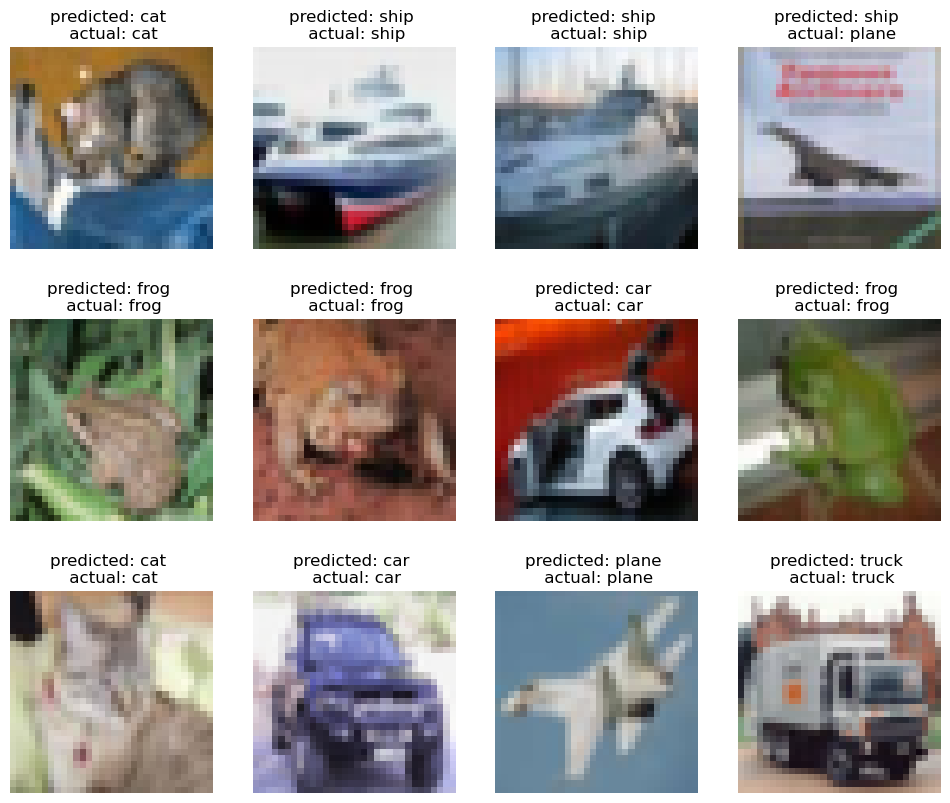

In [38]:
with torch.no_grad():
    
    plt.subplots(figsize=(12, 10))
    
    for i in range(0, 12):
        img, label = testset[i]

        predictedValue = predictImage(img, model)
        
        
        plt.subplot(3, 4, i + 1)
        plt.title(f"predicted: {classes[predictedValue]} \n actual: {classes[label]}")
        plt.axis('off')
        plt.imshow(img.permute(1, 2, 0))

In [39]:
predictions = np.empty((0, len(testset)), np.int32)
actualValues = np.empty((0, len(testset)), np.int32)

with torch.no_grad():
    for i in range(0, len(testset)):
        testImg, testLabel = testset[i]
        predictedValue = predictImage(testImg, model)

        predictions = np.append(predictions, predictedValue)
        actualValues = np.append(actualValues, testLabel)

tensor([[-4.1684, -5.5485, -2.8986,  4.3736, -2.1293,  4.1987,  2.1520, -4.1374,
         -5.6336, -6.0732]])
tensor([[  0.6271,   5.4849,  -6.6815,  -6.1488,  -9.3742,  -9.0316,  -5.2365,
         -11.6163,   9.0983,  -1.1413]])
tensor([[ 1.9051,  0.1251, -1.9712, -0.9731, -3.4122, -2.5274, -2.9958, -3.8313,
          2.1927, -2.0198]])
tensor([[ 1.9898,  1.4711, -2.3516, -0.2763, -3.9520, -4.9978, -4.3667, -7.0826,
          2.8818, -0.9113]])
tensor([[-5.8972, -5.6851,  1.0073,  0.2356,  0.9730, -3.8317,  5.6038, -8.2415,
         -5.4436, -6.9516]])
tensor([[-4.1565, -4.8674, -0.8076,  0.9287,  1.5429, -0.2692,  3.6439, -3.1018,
         -4.2043, -4.2295]])
tensor([[-3.0610,  4.3197, -3.2493, -0.5714, -4.2866, -1.7809, -2.1857, -4.6529,
         -5.3520,  0.9103]])
tensor([[-6.2336, -9.2160,  2.3379,  1.5938,  1.1143, -2.0404,  5.5033, -5.2320,
         -6.2135, -7.6690]])
tensor([[-5.4225, -8.9287, -0.5284,  6.0392,  1.0296,  3.7007, -1.0131, -1.8018,
         -8.2768, -7.6678]])


tensor([[ 4.1325, -3.1635, -0.5480, -3.8896, -2.6689, -5.1999, -8.6546,  0.7568,
         -6.3117,  2.3641]])
tensor([[-4.0984, -5.2624, -2.2917,  5.4635, -1.8308,  4.3069, -2.5861, -3.4325,
         -3.2409, -6.4631]])
tensor([[-4.3448, -5.6063, -0.5444,  3.2097,  0.9853,  4.2500, -1.5319,  0.1355,
         -5.8121, -5.7003]])
tensor([[ 2.1471, -3.5027, -2.5127, -4.1093, -1.2621, -6.1030, -4.2694, -5.1531,
          6.8005, -2.2431]])
tensor([[ 1.8615, -1.5296, -4.0572, -3.2632, -5.4762, -6.1372, -3.9800, -8.2840,
          8.2674, -0.9222]])
tensor([[ -1.5025,   7.9356,  -8.9299,  -5.0340, -10.2678,  -8.8553,  -5.9726,
          -9.3785,  -0.7138,   8.4300]])
tensor([[ -2.7556,  15.1884,  -9.4809,  -9.7082, -11.0935, -11.2014,  -3.9911,
         -13.5138,   0.7222,   0.5183]])
tensor([[-2.6374, -6.7442, -0.7855,  1.4035, -0.0354,  2.9504, -4.0783,  4.1965,
         -5.6204, -5.0610]])
tensor([[ 0.7154, -5.9137,  2.9008,  1.1769, -1.8908,  1.4909, -2.0410, -1.6233,
         -4.8629, -

tensor([[-1.2872, -9.1789,  4.1387,  0.8721, -1.6008, -0.5778,  2.4003, -2.7702,
         -6.9664, -6.9382]])
tensor([[ 1.7408, -0.6206, -3.4738, -3.3721, -4.0173, -6.0091, -8.1088, -4.3721,
         -2.5532,  8.2190]])
tensor([[-2.2159, -7.9871,  0.3956,  2.0602,  1.0249,  0.3650,  0.3516,  0.4169,
         -5.8942, -6.1500]])
tensor([[ -1.2978, -10.6138,   1.5495,  -2.8537,   9.1360,  -0.6831,  -6.8601,
          -2.1067,  -8.5285,  -8.1435]])
tensor([[ 1.8933, -6.2118,  3.0137,  0.3534, -5.5275, -1.9785,  2.6732, -5.1754,
         -5.3903, -5.0943]])
tensor([[ -3.4869,  14.8801,  -9.6635,  -8.2193, -12.6430, -10.3910,  -4.6233,
         -13.4322,  -2.0594,   4.7568]])
tensor([[-4.0051, -2.7231, -0.1307,  1.7463, -1.5615,  1.7926,  2.1256, -2.5789,
         -3.7120, -4.0302]])
tensor([[-6.0985, -7.0472,  2.1773, -0.9745,  0.4876, -3.9322,  7.2919, -5.9941,
         -7.3564, -7.1961]])
tensor([[ 3.5145, -0.5993, -0.8389, -3.5328, -1.4995, -4.3728, -3.5244, -3.2671,
          1.7470, -

tensor([[ 0.5504,  1.9888, -3.8639, -1.7554, -5.6176, -3.7953, -4.3979, -5.0132,
          4.5491, -0.8470]])
tensor([[ 0.8455, -4.2619, -3.0352, -4.9764, -5.6078, -6.3423, -4.2541, -8.1008,
         10.2858, -2.3141]])
tensor([[ 9.6451, -5.5861,  1.2317, -3.2718, -3.2195, -4.9183, -4.4420, -7.8160,
         -1.5385, -4.0700]])
tensor([[-4.4675, -7.8299,  0.3493,  1.0323,  6.3256,  0.1554, -2.4272, -0.2350,
         -5.5551, -6.2726]])
tensor([[ 1.0025, -2.2673,  0.2974, -2.4138,  0.2906, -1.7690, -3.4577,  0.5737,
         -2.8069,  0.0308]])
tensor([[-1.9407, -5.6672, -3.4260,  3.5888, -2.3104,  2.6177,  0.6444, -2.8402,
         -4.4161, -3.1261]])
tensor([[-2.7070, -9.2033, -1.7589,  5.1129, -3.0780,  5.7009, -1.3296, -0.3353,
         -8.6506, -6.8622]])
tensor([[ -6.7434,  17.8115, -10.9979, -10.5826, -18.3157, -11.0066,  -4.2502,
         -14.1741,  -0.0281,   4.1441]])
tensor([[-4.6625,  9.2163, -6.1879, -3.1967, -7.1810, -6.8507, -6.1551, -7.5481,
         -4.3103,  4.5485]])


tensor([[-4.2215, -8.2009,  0.2432,  0.8633,  4.2725, -1.2073,  1.6576, -3.3950,
         -4.4838, -6.8114]])
tensor([[-0.0656,  6.4063, -5.5222, -5.6907, -7.0052, -7.1713, -3.7015, -9.2265,
          5.0639,  1.3138]])
tensor([[ -6.8891,  -8.9400,   1.3071,  -1.3885,  -3.2972,  -6.8222,  12.7060,
         -13.6125,  -6.7185, -11.2897]])
tensor([[ 3.6532, -3.2594, -0.7301, -3.0735, -2.2242, -5.7189, -0.8422, -7.2679,
          3.7610, -2.3237]])
tensor([[ 2.5697, -6.7022, -0.7466,  0.4724, -0.4146, -0.1094, -0.0485, -4.2344,
         -3.0206, -4.9849]])
tensor([[-4.3879, -6.9337, -1.0520,  1.7531,  5.4107,  1.5360, -2.9427,  0.4204,
         -6.6686, -6.1538]])
tensor([[ 5.0987e+00, -5.3859e+00,  3.0415e-03, -2.4398e-01, -1.5384e+00,
         -8.2219e-01, -2.8603e+00, -3.6602e+00, -2.5881e+00, -4.2964e+00]])
tensor([[-4.4970, -7.3388,  0.8110, -0.6031,  3.1473,  1.7871, -6.0839,  5.4562,
         -8.8311, -5.2979]])
tensor([[-5.5822, -8.7625, -0.3884, -2.0665,  4.0676,  1.1022, -7.2624

tensor([[-1.0529, -3.3834,  3.7394, -0.1098, -1.1124, -1.0309, -1.2043, -2.4513,
         -2.8732, -4.0553]])
tensor([[-4.4963, -7.1992,  2.1100,  2.6616, -3.5008,  4.0750, -0.1525, -1.4860,
         -5.6018, -5.7117]])
tensor([[-8.4489, -9.0246, -0.9476,  3.8052, -1.5672,  8.9373, -3.7284,  2.0685,
         -9.1067, -6.9259]])
tensor([[-5.7161, 10.2028, -5.9171, -6.0232, -8.2932, -6.1360, -2.4459, -6.6165,
         -3.5079,  1.9215]])
tensor([[ 5.2481, -6.3120,  5.8854, -4.9263, -3.5376, -4.7030, -3.2392, -5.7896,
         -0.5936, -6.7893]])
tensor([[ -5.2493,   0.3411,  -0.1924,  -5.3482,  -5.9435,  -6.2277,   8.2990,
         -11.1889,  -5.8938,  -4.9369]])
tensor([[-5.3698, -8.3594,  7.4368, -0.5590, -3.1064, -2.4198,  4.5341, -4.6481,
         -7.6313, -9.4454]])
tensor([[-0.9820,  1.9455, -3.4034, -0.7048, -3.2512, -2.5344, -3.5474, -3.6952,
         -2.2650,  4.0713]])
tensor([[-7.4226, -6.6143,  0.5611, -1.0359, -1.0226, -4.4060, 10.0499, -8.8968,
         -6.6167, -7.9298]])


tensor([[-2.9423, -4.3829,  1.8440,  1.0337, -2.5124,  3.8772, -0.8362, -0.2123,
         -6.4378, -4.9584]])
tensor([[-4.6437, -7.6915,  1.7373,  0.8978,  0.4007, -0.7118,  6.5098, -4.9183,
         -7.5735, -7.0227]])
tensor([[ -2.3085,   7.0250,  -4.8375,  -4.2643,  -8.4798,  -5.1706,  -0.1218,
         -10.6081,   0.2256,  -0.3105]])
tensor([[-5.7004, -7.3869,  1.1094,  0.9882,  6.1695,  2.3341, -2.8797,  0.3267,
         -7.7409, -7.0300]])
tensor([[-2.1885, -3.8285, -2.6012,  2.3758,  0.8558, -0.9150, -0.5711, -1.6848,
         -3.7112, -1.2318]])
tensor([[-5.8402, -7.6338, -0.7049, -0.1959,  7.3932, -1.1996, -0.5193, -0.4957,
         -6.1477, -6.4583]])
tensor([[-7.5102, -7.8180, -0.3737,  1.0991,  3.0800,  3.9106, -2.5477,  4.1984,
         -8.7294, -7.9727]])
tensor([[-6.3580, -9.7333,  0.5205,  5.1344, -1.7026,  3.5565,  1.3967, -1.4320,
         -8.9775, -7.4908]])
tensor([[-3.5689, -5.6718,  1.0049,  1.6717, -1.1888,  3.8671, -1.9670,  1.6764,
         -5.4816, -4.7605]])


tensor([[-4.1956, -9.3146,  4.4134,  0.5083,  0.7934, -3.7473,  4.5643, -6.2250,
         -5.4842, -8.5119]])
tensor([[ 2.3981, -1.6555, -0.8620, -1.5168, -2.5374, -2.2329, -3.2284, -2.6475,
         -0.3708,  0.7895]])
tensor([[ 3.0508,  0.8339, -2.6809, -4.9921, -4.3582, -6.5198, -7.6673, -5.1204,
         -1.9203,  6.5797]])
tensor([[ -2.1479,  18.0888, -13.4374, -11.2497, -19.3888, -14.9172,  -9.8792,
         -18.5491,   4.5591,   7.8950]])
tensor([[-1.0855, -5.4688, -2.5282, -0.4333,  2.9865, -0.1435, -2.0050,  0.3680,
         -5.8656, -2.0540]])
tensor([[-3.2705, -5.4745,  0.1081, -0.1677, -0.7733, -4.2141,  5.6546, -7.8168,
         -5.5421, -4.1852]])
tensor([[ -5.9799,  -8.2770,  -2.0307,  -1.7829,   3.2490,   1.4862,  -7.7387,
           9.7517, -10.0247,  -6.0887]])
tensor([[-5.4703, -7.6993, -0.1998,  3.0141, -3.5001, 10.2583, -1.8436, -2.4987,
         -8.3444, -7.5160]])
tensor([[  1.5980,   0.1416,  -3.6904,  -5.9207,  -5.7491,  -8.1560, -11.1184,
          -6.9594,  -

tensor([[ 0.6574, -5.0229, -0.0421, -2.7699, -2.4532, -2.9098, -3.5889, -3.4696,
          5.5609, -3.9192]])
tensor([[-4.7924, -4.6136, -1.6755,  3.6573, -2.7229,  5.7877,  0.1417, -2.0793,
         -5.4630, -5.3967]])
tensor([[-3.3303, -1.1419,  0.4205, -0.0984, -6.3219, -0.7081, -2.0323, -3.5796,
         -0.1423,  0.9701]])
tensor([[-3.3818, -4.9559, -1.8175, -0.1955, -0.7232, -2.0458,  6.8394, -8.4150,
         -6.6616, -4.2772]])
tensor([[-5.7730, -6.1590, -0.4590,  2.4063, -2.1495, -0.6401,  6.0166, -5.2680,
         -6.6712, -5.3079]])
tensor([[-2.5447, -8.2409,  0.6679, -1.4934,  7.3340, -1.7298, -5.6328, -0.0430,
         -6.3123, -5.7044]])
tensor([[-4.9189,  9.1427, -4.4625, -5.5939, -7.2356, -6.0169, -2.1011, -7.0358,
         -3.7772,  1.3592]])
tensor([[-1.1284, -4.1213, -1.1993, -0.8997, -2.7672, -1.1559, -2.5527,  5.5514,
         -5.0458, -2.9635]])
tensor([[-1.0828, -0.2635, -2.4313, -0.8747, -0.7296, -1.2764, -5.3627,  2.1861,
         -2.9664, -1.0719]])
tensor([[ 

tensor([[-4.0744, -7.7846,  0.4031,  3.9893,  2.2884,  1.9868, -1.0174, -2.3535,
         -6.1093, -5.8226]])
tensor([[  0.3470,  -9.8222,   5.9818,   0.3744,  -1.7540,  -1.8633,  -3.9291,
          -3.5388,  -2.3435, -10.0979]])
tensor([[  8.8756, -10.1558,   4.3586,  -2.9451,  -2.6143,  -4.3614,  -6.2394,
          -6.2849,  -2.0899,  -7.7106]])
tensor([[-4.9365, -6.4512, -0.1547, -3.0217,  1.8567,  1.7845, -7.3492,  7.9833,
         -8.2448, -5.7472]])
tensor([[ 2.1569, -3.6455, -2.9722, -3.6645, -2.5361, -5.4805, -3.2020, -6.9334,
          7.4946, -2.9340]])
tensor([[-4.1413, -4.5762, -1.6212,  3.8008, -1.4491, -0.2723,  1.4030, -2.6166,
         -2.9782, -3.0318]])
tensor([[ 4.2414,  2.8686, -5.4907, -6.4099, -2.4594, -9.3935, -5.8929, -7.7294,
          4.1745,  2.1008]])
tensor([[-1.1775, -3.2202,  2.0251,  0.1216, -3.1089, -0.4875,  0.4305, -0.9007,
         -3.8497, -5.6358]])
tensor([[ -9.4292, -12.8499,  -1.7516,  -3.8261,   5.8958,   2.4682, -12.0275,
          15.7220, -1

tensor([[-0.3250, -5.1399,  4.6426, -1.2372, -2.8696, -2.0036,  2.1293, -5.3099,
         -4.0207, -5.9271]])
tensor([[-1.4693, -5.3642, -2.6426,  0.0907,  2.4310,  0.3289, -2.7537,  1.3881,
         -2.9384, -3.2352]])
tensor([[ 0.4107, -2.0157, -0.4736, -2.1130, -2.4331, -1.8926, -4.4005, -1.1103,
         -0.5003,  2.5239]])
tensor([[-2.8118, -6.4960,  3.3667,  1.1503, -1.5903,  2.6683, -1.6860,  0.6104,
         -6.4306, -4.3169]])
tensor([[ 0.2018, -6.8685, -0.5286, -2.8910,  6.6339, -4.1147, -2.2140, -5.1419,
         -3.6810, -5.6616]])
tensor([[-2.1759, -2.2220, -1.8495,  2.9143, -2.2014,  1.9284, -1.8074,  0.0432,
         -3.7638, -1.6679]])
tensor([[-0.8609,  5.3307, -5.4477, -3.7849, -6.1825, -5.1463, -3.8018, -5.8931,
         -3.7549,  5.8493]])
tensor([[-6.9577, -4.6259,  1.0105,  0.2997, -2.3676, -1.5751,  7.2067, -6.3239,
         -6.1686, -7.2826]])
tensor([[-6.9065, -8.0229,  1.5928,  1.7459,  5.7285, -0.3613,  2.2327, -2.9026,
         -7.4473, -7.3336]])
tensor([[ 

tensor([[ -7.2413, -10.8090,  -3.1329,  -4.0676,   1.3725,   3.0122, -11.5185,
          15.1347, -12.8328,  -8.5986]])
tensor([[ 5.8066,  0.7328, -2.5849, -4.5988, -2.3654, -5.9297, -5.7460, -4.0442,
          0.1240,  0.8322]])
tensor([[-5.2286, -7.4591, -2.8184, -2.8068,  1.0081,  2.0937, -7.8511, 10.4174,
         -8.1658, -5.7291]])
tensor([[-0.2427, -5.6772,  5.8403, -2.7955, -3.2544, -2.8266,  2.5230, -4.3118,
         -5.6535, -7.9763]])
tensor([[-3.8895,  5.1483, -3.5595, -2.2138, -5.1592, -2.6263, -1.5204, -5.1301,
          0.3709, -1.0713]])
tensor([[ 2.5600, -2.5775, -0.4883,  1.3146, -3.3899, -0.1416, -1.7435, -4.4094,
         -2.1120, -4.3543]])
tensor([[-0.3974, -4.0077,  4.3867, -0.5198, -1.9610, -1.1339, -0.3620, -2.4041,
         -3.2077, -4.1073]])
tensor([[ 7.2278, -2.0816, -1.9504, -4.2757, -2.0403, -5.5050, -9.2914, -2.7004,
         -2.9617,  2.1747]])
tensor([[-0.2493, -3.0105,  2.1574, -1.6812, -0.5946, -3.9805,  1.4556, -5.3432,
         -0.6442, -4.7803]])


tensor([[ 0.6036, -0.8899, -4.0978, -4.3149, -5.5523, -6.1273, -5.9574, -6.4679,
          8.3554, -0.4757]])
tensor([[ 4.4781, -4.0533,  1.2988, -0.8758, -1.4481, -2.2516, -2.0930, -5.5190,
         -1.9385, -4.2183]])
tensor([[-0.8297, -4.6964, -2.0121, -0.9509,  1.5235, -3.8162,  2.7395, -4.9257,
         -1.3430, -4.2886]])
tensor([[ -0.2501,   4.3524,  -7.3945,  -6.7096,  -9.4576,  -8.3562, -10.2092,
          -8.5923,  -8.5833,  13.9568]])
tensor([[ 0.5009,  0.9780, -2.8132, -2.3131, -0.0265, -3.9901, -2.7018, -3.6814,
         -3.0492,  2.0244]])
tensor([[-1.6941, -0.7513, -3.6350,  0.5588, -0.8964, -0.5018, -1.4224, -1.5623,
         -4.6251,  1.3331]])
tensor([[-1.2999, -5.5919, -0.3289,  1.8053, -4.1671,  6.7501, -2.7015,  0.2890,
         -5.9843, -5.3199]])
tensor([[-4.4239, -3.9052, -0.8834,  3.9036, -2.0473,  3.1853, -1.9769,  0.2574,
         -4.5310, -4.6243]])
tensor([[-0.5364, -5.5953,  2.7221, -1.5163, -1.5391, -2.2521,  1.1939, -2.4991,
         -0.5358, -6.5784]])


tensor([[-4.7167, -4.1412,  1.1321,  1.8201, -0.7378, -0.8927,  1.8413, -1.1991,
         -3.8859, -2.7010]])
tensor([[-3.7762, -4.6001,  0.7141,  2.7887, -2.1808,  4.5199, -1.5032, -1.2540,
         -4.9347, -4.0925]])
tensor([[ 1.3712, -1.7274, -0.1296, -1.9659, -0.7509, -4.2788, -2.3326, -3.9299,
          2.3849, -0.7475]])
tensor([[ 0.3095,  7.3678, -7.1712, -5.7752, -9.0491, -8.3771, -5.7153, -8.7468,
          0.7993,  6.2154]])
tensor([[-6.9659, -5.4261, -3.1002,  6.5682, -2.2653,  2.3843, -0.0175, -4.5924,
         -3.7890, -6.0041]])
tensor([[ 1.5080, -2.2815, -3.4196, -5.6965, -5.8316, -7.1170, -3.8931, -9.0216,
         10.7368, -2.7268]])
tensor([[-6.9968, -7.0763, -1.6714,  3.5465, -2.5251,  7.9383, -3.0678,  1.3853,
         -6.5614, -6.6969]])
tensor([[ 6.2134,  0.8634, -2.6318, -3.9017, -2.7108, -5.1357, -4.0566, -5.8641,
         -0.0146, -0.9776]])
tensor([[-0.0285, -2.1440, -1.8749,  0.3302, -0.0261, -1.5209, -2.3298, -3.8807,
          1.6444, -3.2114]])
tensor([[ 

tensor([[-4.9432, -7.4239, -2.6893,  6.2129, -2.3687,  2.8542, -1.8314,  0.0640,
         -6.0527, -4.9195]])
tensor([[-3.6417, -5.2398, -0.6147, -1.8254, -2.4957, -4.0186,  9.9815, -9.7288,
         -6.3608, -6.6596]])
tensor([[ 0.1174, -2.7362,  0.1468, -2.4364, -2.7551, -3.2357,  0.3702, -4.0144,
          3.4433, -3.7453]])
tensor([[-2.7075, -6.4029, -0.7621, -0.6615,  0.7322,  2.5377, -5.8794,  6.3382,
         -8.2054, -3.9732]])
tensor([[-4.1966, -6.6676,  2.2695,  1.6786, -3.3077,  0.1660,  0.8162,  0.0714,
         -4.0624, -4.6931]])
tensor([[ 0.9944, -1.1589, -3.3243, -2.8384,  0.3741, -4.3070, -2.3093, -3.9812,
          3.0659, -0.3554]])
tensor([[ 5.0775, -2.6698, -0.8774, -2.1553, -1.4406, -4.5146, -1.6244, -4.8594,
         -1.1691, -1.8106]])
tensor([[ 8.3570, -5.5438, -2.1371, -1.7414, -2.0119, -5.2425, -3.9004, -7.2172,
         -1.5412, -2.2221]])
tensor([[ 9.7550, -5.7074, -0.2482, -1.0529, -4.9569, -5.6390, -4.0325, -9.7327,
         -0.7902, -4.1095]])
tensor([[-

tensor([[ 2.4465,  8.9588, -6.2985, -6.5823, -7.6560, -8.2884, -5.2849, -9.1007,
          0.4472,  2.3961]])
tensor([[-6.3268, -8.3949,  0.8234,  2.3459,  4.4041,  1.5190,  1.6732, -1.7030,
         -7.0455, -7.7663]])
tensor([[-1.4142, -7.6193,  3.8846, -1.5732,  5.1373, -0.4453, -7.3393, -1.2757,
         -7.3791, -6.7704]])
tensor([[-0.7093, -2.4928, -1.3384,  0.6669,  1.0120, -2.7424, -0.5794, -2.9147,
         -2.3964, -0.2031]])
tensor([[-2.7285, -6.7448,  6.9279, -1.3226, -2.9213, -4.0710,  3.0150, -6.9528,
         -5.3359, -7.7990]])
tensor([[-3.3517, -3.7132, -1.0442, -0.1712, -0.2702,  2.0393, -2.6757,  1.7507,
         -4.2288, -0.1247]])
tensor([[-2.4952, -3.4008, -2.0647, -1.6251,  1.9209, -0.9216, -5.0438,  4.9750,
         -5.7825, -2.5084]])
tensor([[-2.5266, -2.0446,  3.0179, -1.6639, -4.5956, -2.7735,  3.8235, -7.1735,
         -3.4062, -3.9140]])
tensor([[  8.3446,  -1.8504,  -2.1455,  -8.3923,  -1.2843,  -8.3682, -10.3694,
          -0.2781,  -4.9737,   0.3663]])


tensor([[-1.8569, -4.7339, -2.1764,  2.0175, -0.4203, -1.3153,  2.6768, -3.7445,
         -3.4545, -2.3529]])
tensor([[-1.1850, -2.5330, -4.3791, -1.4199, -3.1118, -1.5752, -4.3193,  0.7607,
         -2.1547,  3.9882]])
tensor([[-3.3567,  7.6660, -7.1618, -4.6134, -8.3963, -7.3272, -3.3869, -7.9305,
          0.2823,  5.1752]])
tensor([[ 3.9687, -4.6488,  0.5711, -1.7480, -1.6048, -2.7661, -1.8142, -4.6773,
          1.6193, -3.7172]])
tensor([[-5.2550, -6.0101,  0.1842,  0.5127,  3.8451,  0.6190,  0.1726,  1.3700,
         -5.7066, -4.9485]])
tensor([[-5.3249, -7.7092, -0.1180,  1.8965,  2.4851, -2.4236,  4.0628, -5.2358,
         -5.9069, -6.9776]])
tensor([[-5.6499, -4.4160,  1.6006, -0.7477, -2.3816, -3.0009,  6.7382, -6.7867,
         -4.5430, -7.4160]])
tensor([[-2.8174, -3.0866, -0.7865,  2.0442, -0.7492,  0.1629, -0.2776, -0.6055,
         -3.3783, -0.8700]])
tensor([[ 0.2241, -2.6450, -0.1197,  1.7284,  0.3224,  0.6884, -2.0085, -3.3523,
         -2.4992, -2.8490]])
tensor([[ 

tensor([[ 2.2732, -2.6949, -0.9972, -1.5696, -4.1098, -4.0530, -2.6410, -7.5234,
          5.5253, -3.7698]])
tensor([[ 6.4100, -4.3096, -1.8584, -2.0087, -1.6338, -4.1917, -2.4928, -6.0581,
         -1.1132, -1.5076]])
tensor([[-1.3573, -7.2227, -0.1901,  0.1279,  0.7873,  0.9786, -6.2786,  4.7932,
         -5.1225, -4.8125]])
tensor([[ 4.6297, -6.1928,  2.9779,  0.5191, -3.4995, -1.1754, -1.6884, -3.9844,
         -3.7394, -5.0398]])
tensor([[ -2.9526,   2.5329,  -7.4439,  -4.6472, -11.1088,  -8.0688, -10.2593,
          -6.3307,  -6.9531,  14.2319]])
tensor([[ 3.1768, -3.9324, -1.6238, -0.4215,  0.4168, -1.8300, -3.6958, -0.9362,
         -4.5708, -1.5014]])
tensor([[-3.7086, -5.9076, -0.9106,  2.5675,  3.7599,  1.0184, -2.1801, -0.5882,
         -4.5008, -5.3119]])
tensor([[ -6.5564,  18.6561, -10.9750, -11.3578, -16.4130, -11.8005,  -5.1980,
         -15.4893,  -3.5390,   6.0387]])
tensor([[-4.4492, -7.5941,  1.9564,  0.2781,  1.2128, -1.8947,  5.5270, -6.3389,
         -6.0292, -

tensor([[ 2.5151,  0.9278, -4.0340, -5.3916, -4.2613, -7.8096, -4.1616, -8.3134,
          6.7322,  0.7825]])
tensor([[ 0.7808,  1.0737, -3.2062, -2.0885, -4.1360, -3.3106, -4.6149, -2.4839,
         -3.0283,  4.8811]])
tensor([[ -5.2365,  12.9058,  -6.8850,  -7.3562, -12.4311,  -8.1253,  -4.7623,
         -10.7180,  -2.5435,   5.1011]])
tensor([[ -4.4104,   7.8519,  -6.9714,  -3.6615, -11.9823,  -6.0335,  -4.6305,
         -10.1786,  -1.4299,   7.7828]])
tensor([[-4.9020, -4.9296, -1.2877,  3.9199, -1.0462,  4.2288,  0.0694, -1.8815,
         -5.3405, -4.3828]])
tensor([[ 4.2275, -6.4920,  2.8795, -2.4765, -0.4186, -3.6579,  0.2394, -7.2232,
         -0.8757, -6.4606]])
tensor([[ -7.3621, -18.0524,  -0.7451,  -7.0071,  15.0297,  -2.5549, -13.2428,
           6.7313, -10.4255, -13.9701]])
tensor([[ 0.7516,  4.8821, -5.8842, -4.7543, -7.4692, -6.7903, -7.5576, -6.4053,
         -3.8164,  8.5657]])
tensor([[ 0.4257, -7.0511,  1.8211,  0.6980,  1.5675, -0.5332, -1.9160, -2.6770,
         

tensor([[ 4.6026, -6.5614,  1.0099, -2.1146,  0.3349, -3.6280, -4.0094, -2.9149,
         -1.6617, -5.2620]])
tensor([[ 0.3248, -2.7462, -1.7222, -4.2269, -3.8920, -5.4183, -1.7263, -7.2764,
          8.2575, -4.0262]])
tensor([[-3.9165, -8.3523,  2.1810,  1.0665,  5.2508,  1.1122, -4.3736,  0.4749,
         -5.6381, -6.2403]])
tensor([[ -6.9084,  -8.4857,   0.6035,  -0.5655,   0.6249,  -4.7605,   9.8285,
         -10.1775,  -7.5267,  -8.5916]])
tensor([[-2.3958, -6.0902,  5.1415, -0.0076, -1.2435,  1.0212, -0.6004, -1.8610,
         -4.9347, -5.9224]])
tensor([[-2.1693, -5.4624, -0.0103,  0.2357,  3.1269, -3.3043,  1.4140, -4.8651,
         -4.8998, -7.0221]])
tensor([[ -6.8130,  -7.3099,  -2.1582,   1.8039,  -0.2490,  -1.3832,   7.4756,
          -7.0819, -10.1393,  -5.1534]])
tensor([[-1.9830, -2.5742,  0.0311,  0.5939,  0.8846,  1.4076, -1.8288,  0.5568,
         -3.6457, -1.6508]])
tensor([[-2.7805, -3.0440, -0.2498,  1.9986, -3.2165,  1.8392, -0.3350, -1.9837,
         -1.3331, -

tensor([[-2.9370, -3.3767, -0.3717, -0.8356, -0.1533,  0.1557, -6.9914,  5.2165,
         -5.3480, -2.1046]])
tensor([[-4.6222, -6.6400, -0.4183, -1.4652,  4.6100, -0.5569, -1.2558,  3.4440,
         -6.6272, -6.4789]])
tensor([[-4.1004, -8.1968,  1.2871, -0.5551,  5.8213,  0.1101, -3.7851,  1.6383,
         -6.3573, -6.7807]])
tensor([[-5.3385, -7.0644,  0.5110, -0.7389,  6.4102,  0.9737, -2.7693,  2.7806,
         -8.9146, -7.1708]])
tensor([[-4.8623, -6.2862, -1.1646,  5.2978, -0.4305,  2.1782, -0.6596, -2.0795,
         -4.4572, -7.0726]])
tensor([[-2.1850, -4.7808, -1.8318,  2.8954, -1.4455,  3.5289, -1.1681, -2.2987,
         -1.5754, -4.6471]])
tensor([[-6.5686, -8.2665,  1.7376,  3.0652,  5.2090,  0.9818, -0.3282, -1.7702,
         -8.0054, -7.4069]])
tensor([[-1.9315, -3.7784, -0.8631,  1.2367,  0.5061,  1.8331, -4.7898,  1.7768,
         -4.2987, -3.1191]])
tensor([[ -0.4531, -11.1334,   7.5951,  -0.3100,  -2.0699,  -2.3211,   0.1912,
          -2.8560,  -6.3627,  -9.6658]])


tensor([[-4.1376, -1.4236, -0.1735,  0.5386, -4.6472,  0.8874,  1.3840, -1.1867,
         -4.7390, -1.0869]])
tensor([[ 4.9319, -3.3874, -0.7813, -0.9081, -4.7331, -1.0679, -3.5075,  1.1370,
         -6.0193, -5.9914]])
tensor([[-6.2798, -8.9048, -0.0225,  5.6472,  3.3283,  2.1735, -3.8232, -0.3614,
         -7.4039, -7.1650]])
tensor([[-5.2938, -6.0398, -2.0529,  3.5354, -2.4888,  7.1943, -2.4194,  0.9531,
         -7.7363, -5.0589]])
tensor([[-6.1589, -4.9797, -1.6138,  3.7429, -3.9413,  7.1639, -1.5415, -0.9278,
         -5.6261, -6.3726]])
tensor([[-0.3337, -1.7742, -0.4610,  0.0352, -1.8834, -0.5067, -1.6890, -2.4260,
          0.6337, -0.9263]])
tensor([[ 0.8889,  1.0296, -6.6740, -4.4382, -5.9532, -6.8129, -7.4408, -5.4380,
         -3.6388, 10.3759]])
tensor([[-2.6897, -3.9285, -1.4165, -1.5446, -1.2914, -1.7836, -4.5660,  6.2790,
         -4.5863, -1.7594]])
tensor([[ 0.5595, -2.1666, -1.8718,  1.7153, -2.6930, -0.1459, -0.5016, -4.3251,
         -4.8170, -1.1605]])
tensor([[ 

tensor([[-4.2711, -6.6164, -0.2430,  1.0942,  4.1545, -1.5244,  2.7955, -4.6103,
         -5.7470, -5.4208]])
tensor([[-1.3862,  0.0452, -3.5606, -1.8418, -7.1716, -3.6718, -2.8467, -7.7627,
          7.5367, -2.2564]])
tensor([[-4.1761, -7.9726, -0.4566,  0.2671,  0.2915, -3.7550,  7.4339, -8.1435,
         -7.0387, -6.2473]])
tensor([[-1.3453, -6.9464,  1.2681, -1.3558, -1.6038, -3.5196,  5.7813, -5.5109,
         -6.2512, -5.1924]])
tensor([[ -4.7517, -10.1052,   1.1826,   0.1803,   8.2106,   0.3971,  -4.2284,
           0.3599,  -8.7063,  -8.0054]])
tensor([[-3.9478, -4.9989, -1.3493,  2.8922, -1.0613,  4.9910, -1.6655,  1.2710,
         -5.6048, -4.8552]])
tensor([[ 5.3858, -5.5579,  0.2953, -4.4276, -3.5160, -5.3755, -3.0633, -8.1537,
          5.6156, -5.0513]])
tensor([[ -5.9444,  14.1568,  -7.1592,  -9.2338, -14.3532,  -9.2536,  -3.5255,
         -13.6173,   1.3042,   2.1968]])
tensor([[ 2.7243, -6.0234,  6.9319, -2.6718, -5.9842, -2.4925,  0.1294, -5.6294,
         -3.2259, -

tensor([[ 0.0952, -5.7836,  0.7134,  0.2007,  3.6892, -1.8261, -1.7718, -3.3949,
         -3.0507, -5.3538]])
tensor([[-0.4560,  2.6536, -2.1480, -1.8917, -3.4332, -3.0933, -2.2342, -3.7463,
          0.0267,  2.4963]])
tensor([[ 6.0043, -6.0573,  2.7445, -2.5072, -1.4847, -3.4409, -3.1117, -5.2781,
         -0.7528, -5.1078]])
tensor([[-0.8739, -4.4826,  2.6636,  0.2344,  1.0231,  0.7269, -1.0129, -2.6694,
         -5.1772, -4.7706]])
tensor([[ 2.6650,  0.2116, -3.3084, -2.8972, -3.5308, -5.5857, -2.1697, -7.3306,
          4.8612, -0.1934]])
tensor([[ -5.0653,  11.0628,  -7.2624,  -7.2867, -11.8334,  -7.9376,  -3.7076,
         -11.0185,   1.0733,   4.8526]])
tensor([[ -1.9368, -11.2859,   0.4935,   3.9426,  -1.3936,   6.3072,  -1.4976,
          -2.5884,  -7.6140, -10.0574]])
tensor([[-6.8497, -7.9832,  3.0118, -0.2735, -0.8808, -2.6026,  8.0736, -6.0579,
         -6.8526, -8.4154]])
tensor([[-1.5930, -5.6720, -2.5792, -3.2863,  0.8551, -1.0523, -7.9980,  7.7152,
         -8.7774, -

tensor([[ 0.1644, -1.8489, -1.4203, -0.4536, -0.2203,  0.5140, -3.6740,  1.3632,
         -3.2059, -2.1895]])
tensor([[ 0.6248, -4.8789, -1.0527,  0.2804,  2.3951, -0.8157, -3.9436, -0.4667,
         -4.3878, -2.8313]])
tensor([[ 3.1427, -0.3105, -5.2403, -3.5109, -5.9109, -6.6409, -8.1131, -5.4644,
         -3.2576,  9.2386]])
tensor([[-1.9717, -8.6362,  8.1322,  0.5017, -3.5932, -1.6383, -1.9572, -3.3322,
         -3.7907, -7.7793]])
tensor([[ 0.2118, -2.8536, -6.0559, -2.0174, -4.4917, -5.0213, -4.6129, -7.1437,
          7.2280, -0.0252]])
tensor([[-2.1542, -7.1116,  0.2104, -0.8839,  6.9327, -0.5188, -1.5699, -3.6718,
         -5.1206, -7.4650]])
tensor([[-0.6009, -2.5749, -2.0708, -1.7678, -1.9798, -2.0497, -3.6747, -0.3057,
          0.6534,  1.8447]])
tensor([[-3.4173,  7.5848, -6.4706, -4.7657, -9.1397, -6.0126, -3.9789, -7.5275,
         -1.5964,  6.3600]])
tensor([[-2.5777, -3.6433,  1.3366,  2.5676, -1.0516,  1.4444, -2.5305, -0.3410,
         -3.9238, -2.5883]])
tensor([[-

tensor([[ 1.7156,  2.7914, -6.9947, -4.6087, -6.7742, -8.0579, -6.9876, -8.4778,
          0.4051,  8.8230]])
tensor([[ 2.4604, -3.5347, -1.1952, -4.6859, -1.5559, -6.3694, -6.1281, -4.6564,
          5.3417, -0.8699]])
tensor([[-1.5968, -1.8132, -0.4777,  1.8953, -2.9780,  2.0055, -1.7416, -0.5957,
         -2.8451, -2.9648]])
tensor([[-6.1746, -7.1950, -2.4996, -2.5051,  2.6744,  2.1809, -6.5644,  8.8473,
         -7.6921, -6.2816]])
tensor([[ 1.5994, -4.2486, -3.5648, -5.9264, -4.9606, -7.4979, -5.7884, -8.8400,
         11.2863, -1.2261]])
tensor([[-8.1972, -8.6939, -2.3146,  4.6003, -4.3556, 11.0658, -1.7765, -0.2759,
         -9.3731, -9.2829]])
tensor([[ 5.0718, -6.0195,  4.2916, -0.7385, -2.5806, -2.2867, -2.9555, -5.9790,
         -2.8883, -5.4675]])
tensor([[ 7.8626, -3.2660, -1.6678, -4.1195, -0.9556, -5.5418, -8.0307, -4.8920,
         -1.9287,  1.5383]])
tensor([[ -1.3986,  12.0176,  -8.3058,  -6.5939,  -9.9478,  -9.7939,  -3.7915,
         -12.0685,  -2.1590,   4.1118]])


tensor([[-4.6909, -7.6296, -0.0210,  4.3233,  4.3453,  1.2662, -2.5243, -1.8437,
         -7.1583, -7.3276]])
tensor([[-4.1436, -5.1915,  3.4715, -0.2073, -1.6781, -3.1598,  4.3546, -6.0982,
         -4.0798, -7.3895]])
tensor([[ 5.6026, -5.4201,  1.5138, -2.5410, -1.2149, -2.9474, -2.2351, -4.4016,
         -1.0019, -4.5852]])
tensor([[ -6.5203,  -8.5313,   0.9278,  -0.2344,  -1.2022,  -3.3927,  10.7466,
         -10.0966,  -9.0983, -10.1842]])
tensor([[-0.1614, -3.5667, -1.1310,  1.6951, -1.4377, -2.2587,  1.2997, -4.3662,
         -1.6677, -1.8441]])
tensor([[-5.3132, -4.7408, -1.0563,  3.0962, -5.3541,  7.6982, -1.6557, -1.7960,
         -5.4234, -5.4109]])
tensor([[-2.9038, -5.1875, -0.1816,  1.7162, -1.6292,  4.8837, -2.1482,  1.4455,
         -6.7424, -4.3810]])
tensor([[-6.1760, -7.8305, -1.6344,  1.3898, -2.9977, -2.5120, 10.0918, -9.7598,
         -9.2445, -6.4100]])
tensor([[-0.4436, -4.3808, -1.8542,  2.3668, -2.2295,  0.5693, -0.2662, -0.4274,
         -3.5454, -1.7387]])


tensor([[-3.6207, -5.1852, -0.4454,  2.4188, -2.2686,  5.7779,  0.2261, -2.3167,
         -5.6172, -5.1936]])
tensor([[-4.5029, -4.0980, -0.7224,  2.5719, -0.5933,  4.6935, -0.8501, -0.6797,
         -5.0104, -3.6258]])
tensor([[  0.3091,  -3.4033,  -2.9558,  -7.3891,  -8.2841,  -8.6315,  -3.0338,
         -12.2134,  13.4926,  -6.3904]])
tensor([[-4.5236, -6.9598,  0.6025,  2.2163,  5.2337,  0.8146, -1.9090, -1.0407,
         -5.8436, -5.6887]])
tensor([[ 2.0576, -2.3697, -2.4748, -5.8972, -4.4281, -6.7510, -3.7864, -7.6952,
          8.8512, -2.9708]])
tensor([[-4.9706, -9.1721, -0.5034,  4.2072,  0.4151,  5.8490, -0.1103, -0.8992,
         -8.7299, -8.1253]])
tensor([[  0.1740,  -3.9270,  -6.0545,  -6.7432,  -7.4312,  -9.1924,  -5.7458,
         -10.9206,  14.9366,  -4.5740]])
tensor([[-3.7281, -7.5952,  2.7269, -0.9350, -0.2792, -3.9687,  6.6989, -7.6926,
         -5.2415, -7.0820]])
tensor([[-3.4037, -7.2060, -0.9533,  3.9928, -0.9710,  6.3203, -1.7721, -1.2253,
         -6.3140, -

tensor([[ 7.8469, -5.8218, -0.6857, -2.1082, -1.5960, -4.1945, -3.3641, -6.3477,
         -0.1317, -3.8734]])
tensor([[ 2.1935,  7.4125, -4.0184, -6.4787, -5.3259, -7.8787, -6.2836, -6.2356,
         -1.4451,  1.5625]])
tensor([[ 0.1193,  5.5940, -7.7824, -4.3209, -7.4029, -7.4397, -4.9604, -7.5250,
         -6.4278,  7.8835]])
tensor([[-0.8101, -4.7563,  0.8841,  0.9384,  2.4087,  0.4358, -3.9225, -0.5564,
         -3.7310, -3.5417]])
tensor([[-2.5890, -4.0702, -1.4367, -1.8294,  0.1162, -3.3638,  5.2090, -6.8628,
         -2.1190, -3.9367]])
tensor([[ 2.2246, -0.4596, -2.2200, -0.8744, -0.7170, -2.7668, -2.9727, -3.5871,
         -2.3023,  0.7448]])
tensor([[ 9.0757, -5.5072,  1.5037, -4.9448, -4.6145, -8.4849, -4.3529, -8.4536,
          1.6315, -5.1488]])
tensor([[-0.7701, -4.4613, -2.7586, -1.5861,  1.0786, -1.9953, -7.3048,  3.5839,
         -5.5769,  0.3441]])
tensor([[-3.9004, -2.9593,  5.8886, -2.1776, -6.4238, -1.6645,  2.6188, -5.9966,
         -6.4444, -6.1604]])
tensor([[-

tensor([[-2.1897, -3.6089,  0.6745,  1.8965, -0.7433,  2.8858, -2.1488, -0.6650,
         -3.3404, -2.7888]])
tensor([[ 4.0919, -5.2500,  1.2752, -1.7722, -1.0132, -2.5478,  1.0647, -6.4803,
         -2.9306, -4.9439]])
tensor([[-2.1980, -4.9339,  0.3365,  1.8820, -3.8843,  6.1719, -1.5741, -2.0430,
         -4.8596, -5.1003]])
tensor([[-0.1068,  2.3279, -5.6827, -4.5413, -7.4218, -7.2876, -7.1897, -5.1535,
         -4.3228,  9.7810]])
tensor([[-3.2534, -6.8140,  1.4371,  0.0457, -4.0166, -4.7788,  7.5283, -8.7884,
         -5.9533, -6.1114]])
tensor([[ 1.8318, -0.0183, -5.0017, -3.0985, -4.6383, -6.4756, -8.5729, -5.4655,
         -5.5906,  9.5089]])
tensor([[-4.4049, -1.1743, -1.4197,  1.3443, -2.8502,  3.5692, -0.3655, -1.9338,
         -4.8802, -1.3397]])
tensor([[-3.5075,  7.7610, -4.8741, -5.1064, -8.2093, -5.0097, -2.1325, -5.7063,
         -1.6014,  2.8026]])
tensor([[-3.9036, -8.3846, -0.2169,  3.8588, -2.5001,  1.8554,  4.5029, -4.6959,
         -8.2323, -6.8778]])
tensor([[-

tensor([[-4.4581, -3.0626, -1.2663,  1.8673, -1.4393,  2.3240,  2.6627, -2.0354,
         -5.2984, -3.3032]])
tensor([[ -6.4254,  17.2707,  -7.7613, -11.1614, -16.5324, -10.4655,  -6.1870,
         -15.8142,  -5.4384,   6.4823]])
tensor([[-5.1250, -7.2059,  1.8379, -0.2989,  0.9570, -3.7169,  6.3514, -7.0977,
         -5.1052, -7.3335]])
tensor([[ 2.9630,  2.5744, -3.0914, -1.7092, -3.9091, -3.9080, -3.6597, -4.7837,
          0.3881, -0.5809]])
tensor([[-7.1136, -5.9438, -1.5716,  4.0183, -4.2420,  7.3701, -0.8145, -1.6817,
         -5.2190, -7.1570]])
tensor([[-3.0527,  4.1785, -4.7748, -3.6769, -8.7165, -3.9769, -6.0584, -7.0232,
         -5.0122,  8.8336]])
tensor([[-1.3376,  3.9462, -5.8521, -3.4702, -6.4796, -6.0949, -6.3900, -4.4661,
         -5.7606,  8.1224]])
tensor([[-1.7944, -7.1612, -0.8279,  0.0215,  6.1538, -0.6664, -3.4224, -1.0960,
         -4.2290, -6.2239]])
tensor([[-4.8987, -6.4311, -2.8550,  3.6625, -3.4691,  7.5405, -3.2239,  1.9223,
         -6.3766, -6.1889]])


tensor([[ 0.1080, -3.2767, -3.2513,  0.1656,  2.3718, -1.0071, -5.1351, -2.1152,
         -6.4107, -4.2181]])
tensor([[-4.6395, -6.5685, -0.9857,  2.8260, -3.5574,  9.0442, -2.6598, -1.7798,
         -5.7706, -6.7473]])
tensor([[-3.0970, -2.7186, -1.8280,  2.5217, -2.8376,  3.5207,  0.1272, -0.9851,
         -5.2756, -3.0507]])
tensor([[-3.5635,  2.4714, -4.0545, -2.2169, -6.4461, -3.6821, -4.5676, -4.9580,
         -2.9463,  7.3799]])
tensor([[-5.4807e+00, -7.6250e+00, -6.8754e-03,  2.8213e+00,  3.1592e+00,
          1.2131e+00,  1.8151e+00, -2.5151e+00, -6.3606e+00, -6.3748e+00]])
tensor([[-4.3157, -7.0202,  0.5924,  1.0278,  4.5554,  0.9009, -0.4262,  0.0552,
         -5.7502, -5.0097]])
tensor([[ 3.2454, -0.4106, -2.6402, -5.3897, -3.2004, -7.3570, -4.4488, -8.4349,
          6.8940, -1.0289]])
tensor([[-0.3898,  7.0127, -5.8206, -5.1696, -8.2643, -6.5951, -2.2901, -8.9794,
         -2.4165,  5.1201]])
tensor([[ 0.0695, -2.4669, -2.0410, -4.8015, -4.4550, -5.3481, -2.7194, -6.9534,

tensor([[-0.0962, -4.0238, -2.1348, -2.7643, -1.7681, -4.0490, -0.8731, -6.2898,
          6.1394, -3.6672]])
tensor([[ 4.9416, -2.1440, -3.7824, -3.2259, -1.2180, -5.3920, -4.3420, -3.2987,
         -3.1489,  2.7324]])
tensor([[ 5.5025, -7.4815,  3.3169, -1.4523, -1.6081, -1.9174, -1.7795, -5.1786,
         -2.8574, -6.2912]])
tensor([[-3.9353, -5.8617, -1.3246,  4.5418, -0.8975,  4.7045, -1.5209, -1.2327,
         -5.5455, -5.6720]])
tensor([[-6.1570, -7.3090,  1.5431, -0.1557, -2.6684, -1.7026,  9.4770, -6.6860,
         -7.7299, -7.6457]])
tensor([[ 1.5827, -1.7210, -1.7182, -3.7689, -3.7899, -5.2899, -1.7886, -7.2853,
          6.7847, -3.5916]])
tensor([[-1.4947, -3.1170, -0.2584, -1.4396,  0.1852,  0.1196, -4.8701,  3.7207,
         -4.8468, -0.8559]])
tensor([[ 0.7185, -2.0121, -1.7352, -3.9324, -2.5342, -4.7678, -1.2775, -6.8876,
          6.7067, -3.0054]])
tensor([[ 5.3103, -1.2062, -5.7646, -2.1903, -3.7395, -7.2578, -5.0592, -7.0835,
         -1.7332,  5.1718]])
tensor([[ 

tensor([[-1.6679, -3.7004,  1.4961,  1.0744, -1.4142, -1.1165,  0.4864, -1.9767,
         -1.8707, -3.5700]])
tensor([[-4.4840, -6.6595,  1.2324,  0.5900,  1.6364, -1.6895,  4.4038, -4.1331,
         -5.5163, -4.8182]])
tensor([[-3.7710, -7.8430,  0.4234,  1.2287,  4.5872,  1.0883,  0.3336, -1.6565,
         -5.6921, -6.7007]])
tensor([[ 0.8295, -1.2866, -3.6344, -2.5872, -2.6773, -5.4776, -1.1277, -7.4392,
          5.6061, -1.2229]])
tensor([[ 3.8512, -2.7666, -5.1680, -3.2348, -1.6929, -5.4763, -5.7259, -4.0172,
          2.9991,  1.1724]])
tensor([[ -3.2023,  11.4451,  -6.8644,  -6.6952, -12.0369,  -8.2403,  -4.5348,
         -10.9171,   1.7540,   3.4893]])
tensor([[-1.3514,  0.2489, -2.6819, -2.7032, -0.4442, -3.1989, -6.7216,  1.7441,
         -3.0862,  0.3003]])
tensor([[ 3.0883, -2.1562, -3.1336,  1.3584, -2.7007, -1.6782, -3.2141, -2.9926,
         -2.5119, -0.5116]])
tensor([[ 5.2144, -5.9332,  1.6282, -1.7691, -1.1251, -3.0033, -1.4803, -6.2397,
         -0.4897, -5.2780]])


tensor([[-1.0578, -6.6585,  3.8433,  0.5577, -1.7153, -3.2556,  1.0398, -3.6565,
         -2.6532, -5.1335]])
tensor([[-3.1276, -3.5884, -1.6387,  1.5396,  3.4613, -0.4186, -0.0426, -3.6493,
         -3.8236, -3.8220]])
tensor([[ 1.7163,  0.2474, -1.7856, -1.7067, -1.7957, -3.3615, -2.5104, -4.6067,
          3.0619, -0.4093]])
tensor([[-2.2635, -1.9735, -2.5562, -0.0934, -4.5434, -0.8423, -0.8448, -5.1289,
          3.6655, -5.5721]])
tensor([[-7.6079, -4.1095, -3.4260,  4.7650, -4.7972,  2.3702,  4.7048, -6.5040,
         -6.9032, -4.8242]])
tensor([[-0.7509, -4.1091, -0.9360, -1.8179,  3.1206, -1.7477, -3.9994,  2.0661,
         -4.8311, -2.8040]])
tensor([[-3.1921, -4.1124, -1.0663,  2.0151, -3.1972,  5.9726, -0.8936, -0.6138,
         -5.2168, -4.9701]])
tensor([[-3.2306, -8.7359, -1.1597, -4.1696,  3.7911, -0.4359, -9.8894,  7.6171,
         -9.9647, -2.9628]])
tensor([[-6.7681, -9.9260,  2.5870,  0.5975,  0.1842, -4.2465,  8.8462, -8.4389,
         -7.8314, -9.8815]])
tensor([[-

tensor([[ 0.4914, -5.0823,  0.8783, -1.0748, -1.2251, -0.8041, -2.1786, -1.8279,
          1.9280, -5.1691]])
tensor([[ -7.8021,  -8.2453,   1.0116,  -4.6068,   5.7141,   0.0266,  -9.2672,
           9.7812, -13.9415,  -7.8802]])
tensor([[-3.2208, -8.4829, -1.0128, -1.5056,  6.8188, -1.3483, -1.9868,  0.2992,
         -5.0021, -7.6985]])
tensor([[-4.2950, -5.0593, -1.2677,  2.4870,  0.3602,  3.1376,  0.8983, -0.6303,
         -4.3636, -4.1628]])
tensor([[ 1.6127, -6.2872,  1.0771,  0.0805,  0.9174, -0.2744, -0.1241, -3.1955,
         -3.7096, -5.0248]])
tensor([[-0.3640,  1.3427, -3.6103, -4.2712, -7.7800, -4.4317, -6.1160, -4.2212,
         -8.4959,  9.0637]])
tensor([[-4.5281, -4.3673, -1.9865,  1.4698,  1.5920,  1.0830, -2.3352,  2.1470,
         -5.4995, -1.9794]])
tensor([[-1.0465, -4.5382, -3.3096, -4.0413, -0.4174, -1.3804, -7.7928,  9.5536,
         -7.0486, -4.1689]])
tensor([[-6.3451, -9.9070,  5.5759,  2.5051, -3.1452,  1.1184,  1.0313, -2.2583,
         -6.6934, -7.5412]])


tensor([[ 7.1498, -3.9909,  0.2936, -1.1631, -3.8022, -3.8122, -2.4362, -7.2457,
         -1.2352, -3.6414]])
tensor([[ 0.2531, -3.5912, -0.9698, -0.3266,  0.2498, -3.3414, -4.3112, -2.7056,
          1.9799, -1.2814]])
tensor([[-2.8650, -4.5736, -1.3436,  3.0881, -1.2701,  3.5743, -1.5231,  0.2150,
         -4.2304, -3.0222]])
tensor([[ 3.4500, -0.2420, -4.4123, -3.7198, -5.0459, -7.0122, -7.4334, -5.6404,
         -1.3350,  7.7932]])
tensor([[-3.8460, -5.0272,  2.5141, -1.7708, -3.7525, -0.1407,  0.0646, -4.2156,
          2.1890, -7.2373]])
tensor([[-1.6022, -5.8779, -3.2535,  4.0034, -0.7911, -0.2945,  2.3897, -6.7358,
         -7.0383, -4.1286]])
tensor([[-5.2219, -7.4825,  0.4716,  1.0134,  0.8269, -2.9289,  6.6809, -6.2605,
         -5.7553, -7.5174]])
tensor([[-4.6676, -6.8702, -1.5791,  3.3404,  0.2182,  6.9870, -2.8011,  0.8443,
         -7.9603, -6.2019]])
tensor([[-3.8291, -5.3052, -1.6351, -2.9205,  0.0998,  2.1385, -7.1938,  8.4371,
         -7.7287, -5.2968]])
tensor([[-

tensor([[-3.0364, -5.8306, -1.3547,  3.5757, -0.3882,  4.5499, -3.8446,  0.5901,
         -5.1020, -4.5507]])
tensor([[ 0.1222, -0.4055, -5.4312, -3.3774, -4.8828, -7.0005, -4.3775, -9.2582,
          9.1372, -1.3711]])
tensor([[-3.9048, -7.6576,  1.3819,  1.1220,  3.2803, -2.0183,  3.6070, -5.5980,
         -6.7821, -9.0621]])
tensor([[-3.4581, -5.0822, -0.9314,  1.5315, -2.8767,  6.4187, -1.7782, -1.2740,
         -2.9640, -4.8026]])
tensor([[ -7.3642,  -8.6661,  -1.1968,  -2.4024,  -2.7508,  -6.9580,  14.5914,
         -15.3926,  -7.5286, -10.2154]])
tensor([[-6.1289, -7.3342, -2.5556,  4.1366, -3.2673,  9.9477, -2.4655, -0.6023,
         -7.9545, -6.7255]])
tensor([[-2.9111, -3.4762,  0.2867,  1.4254,  0.7760,  0.9177, -1.4322,  0.9490,
         -3.2763, -3.0867]])
tensor([[ -6.7617, -11.3443,   0.3424,   0.0484,   8.9137,   0.5924,  -2.4563,
           1.0248,  -8.6194,  -8.6020]])
tensor([[ 1.6328, -5.3134,  4.7732, -1.5836, -2.6102, -0.5370, -1.6626, -1.2893,
         -3.6296, -

tensor([[ 2.2892,  0.7977, -2.3866, -3.1115, -3.7126, -4.5437, -6.1553, -3.4313,
         -1.8828,  5.3647]])
tensor([[ 3.1352, -1.8054, -1.4677, -3.0154, -1.4403, -4.4859, -3.8824, -3.1089,
          2.2900,  0.8564]])
tensor([[ 0.7300,  5.7023, -4.8252, -5.0887, -5.9785, -6.3591, -6.8856, -4.8005,
          0.7439,  3.9620]])
tensor([[ 3.4888,  2.3611, -4.0833, -4.6931, -5.6053, -6.6815, -7.0355, -6.0682,
          1.8970,  5.1222]])
tensor([[ 4.9129,  0.9267, -2.5990, -2.7463, -4.1674, -5.0449, -2.4970, -7.2905,
          0.6401, -1.1856]])
tensor([[-4.6375, -7.5922, -0.3778,  3.3061, -0.9836,  3.3854, -0.5602, -0.4717,
         -3.6968, -6.0128]])
tensor([[ 5.2398, -3.7782, -0.6537, -0.4191, -1.8553, -2.7312, -5.4165, -5.1801,
          1.0594, -2.4665]])
tensor([[-5.2070, -9.6843,  0.2724,  0.3310,  9.3914, -0.8028, -1.7140, -2.8840,
         -7.3945, -8.3793]])
tensor([[-3.7933, -4.4555, -1.4224,  1.4226,  0.9977,  1.8450, -3.6028,  3.2430,
         -5.0132, -5.6175]])
tensor([[ 

tensor([[-5.9378, -6.3466, -0.3185,  4.7153,  2.3404,  1.2089, -0.3044, -1.9938,
         -6.6697, -6.2257]])
tensor([[-2.3903,  5.6006, -3.3473, -3.5001, -5.7461, -4.1016, -1.4805, -4.8433,
         -0.3130,  1.5023]])
tensor([[ 3.5802, -1.5987, -2.8676, -0.2688, -3.9962, -4.2192, -1.6288, -6.1501,
         -2.0440,  0.6678]])
tensor([[-2.5750, -4.2552, -1.5721,  2.8695, -1.8893,  4.6065,  0.1749, -2.5056,
         -4.0784, -4.5317]])
tensor([[ 1.3855, -3.3525, -3.2842, -5.0601, -4.6517, -6.2859, -4.4951, -7.6989,
          9.9889, -2.3568]])
tensor([[-3.7746,  4.3624, -5.6181, -4.0930, -7.2739, -4.6724, -2.1077, -6.3572,
         -5.0755,  7.2620]])
tensor([[-3.0489, -6.0435,  2.0287,  2.0721, -2.1352,  2.6582, -2.3440,  1.9804,
         -6.8019, -6.0602]])
tensor([[ 5.6729, -0.3010, -0.8096, -2.9689, -4.1663, -5.9094, -1.8241, -8.3336,
          0.7064, -1.5243]])
tensor([[ 1.0153, -4.4734,  1.0530, -0.8599, -0.5880, -2.4322, -5.1928, -3.3267,
          2.1641, -1.5610]])
tensor([[ 

tensor([[-1.4302, -4.4102, -0.4331,  2.4655,  0.0798,  1.5510, -2.6265, -0.9507,
         -1.7846, -3.8086]])
tensor([[ 8.1407, -7.8946,  1.4760, -2.9450, -0.1409, -3.9262, -3.3813, -6.7902,
         -2.5135, -6.5547]])
tensor([[-3.8302, -6.1037,  1.6999,  0.7982,  1.8869, -1.4592,  3.7839, -3.7275,
         -5.8840, -5.8455]])
tensor([[-3.1696, -5.6558,  0.8503, -2.9908,  4.2339,  0.3362, -4.8961,  3.1947,
         -6.8735, -4.4337]])
tensor([[-4.4085, 11.8632, -7.0775, -7.2119, -9.0544, -8.2717, -5.2928, -9.5428,
          0.2871,  1.5724]])
tensor([[ -4.3918,  13.2369,  -8.7551,  -6.8853,  -9.5565, -10.3988,  -6.2174,
          -9.8440,  -3.8094,   5.2925]])
tensor([[-1.2192,  7.6400, -6.6116, -4.7417, -7.7525, -5.8764, -4.6242, -6.7916,
         -3.5921,  5.8655]])
tensor([[-3.6642, -2.3502, -0.3458, -0.2172, -0.3328, -2.5488,  2.4154, -3.6702,
         -3.0053, -5.3071]])
tensor([[-3.0053, -1.8925, -1.2358,  1.5169, -0.8259,  1.1502, -2.5858,  1.7491,
         -4.9601, -2.2516]])


tensor([[ -1.6438,  -6.0081,  -4.3630,  -5.1715,  -0.8408,  -1.0116, -10.0778,
          12.2222,  -8.3322,  -3.9926]])
tensor([[ 0.2972, -2.5227,  0.1367, -0.9011, -0.7078,  0.4680, -1.1668,  0.8871,
         -2.9132, -2.6353]])
tensor([[-5.9342, -7.8043,  0.0746,  0.7436,  6.2647,  1.5526, -0.5812,  0.5245,
         -7.2313, -6.0971]])
tensor([[-3.0333,  1.2544, -6.3174, -4.2169, -7.3994, -7.1168, -4.9410, -8.2279,
         -5.6213, 12.2586]])
tensor([[ 3.7683, -4.2449,  1.6307, -1.5570, -0.7671, -1.8809, -1.2137, -4.5058,
         -0.4042, -3.8272]])
tensor([[ -7.4644,  -9.5961,  -2.2254,  -6.2114,   3.7922,   1.0278, -12.3943,
          14.6952, -14.7478, -10.5505]])
tensor([[ 4.2941, -6.4535, -1.2938, -1.6713,  3.1166, -3.6477, -2.4952, -4.5242,
         -3.1170, -3.8616]])
tensor([[  0.5907,  -9.5721,   0.9358,  -2.2268,  -1.7795,  -6.1229,   7.8555,
         -10.6502,  -5.8807,  -7.7660]])
tensor([[-3.8197, -8.7626, -2.9954, -3.9882,  2.2532,  0.8027, -9.0488, 10.9480,
         

tensor([[-5.1705,  1.0927, -4.4426, -2.3683, -7.6032, -2.2704, -4.4889, -2.9029,
         -4.3288,  6.9197]])
tensor([[ 1.8507,  3.0202, -3.1673, -4.2878, -3.5911, -3.7597, -3.3426, -0.3191,
         -3.6013,  1.1041]])
tensor([[ 2.3605,  1.0084, -3.9030, -3.2878, -4.7797, -5.8598, -5.1090, -5.2489,
         -0.4831,  6.0629]])
tensor([[ -3.4505,   8.3108,  -7.8091,  -6.6539, -11.5432,  -9.4442,  -8.0709,
         -11.2686,  -6.1376,  12.5725]])
tensor([[-3.3044, -6.0918,  3.9476,  0.6882, -2.3040, -1.6108,  2.4621, -3.0031,
         -5.9875, -8.1213]])
tensor([[ -8.8436,  14.6421, -10.9322,  -8.3481, -14.1517, -11.0750,  -3.8787,
         -15.7089,  -2.7632,   8.6424]])
tensor([[ -7.2449, -11.4091,  -5.0567,  -6.0684,   2.3461,   0.8725, -12.9892,
          17.4247, -12.8333,  -9.3609]])
tensor([[ 6.7714, -6.9178,  4.4050, -2.9878, -3.1493, -4.5156, -3.7888, -6.0137,
         -1.7394, -6.1566]])
tensor([[-1.2066, -2.6537, -1.8835,  0.9431,  0.7098,  2.1496, -2.5435,  0.0713,
         

tensor([[ -7.1257, -10.0607,   0.8935,  -3.5417,   4.1527,   0.7415, -12.0374,
          11.8444, -14.2983,  -8.3747]])
tensor([[-7.0716, -8.9202, -2.3689, -3.3540,  4.5274,  1.8297, -8.1961,  9.8759,
         -9.4714, -7.3734]])
tensor([[-1.6342,  2.4830, -2.3271, -2.3265, -2.4554, -2.3342, -0.9537, -1.9904,
         -0.6189,  1.0836]])
tensor([[-3.6186, -4.7566,  0.1188,  2.3839,  0.2089,  0.5605,  2.1179, -2.9390,
         -5.0584, -4.1104]])
tensor([[ 7.1349, -4.2408,  0.5898, -2.9611, -1.6541, -5.1661, -1.9321, -8.2082,
         -0.3507, -4.2930]])
tensor([[-3.9786, -7.6091, -1.9735,  4.6257,  1.5172, -0.8268,  1.8143, -5.1954,
         -6.6564, -5.4002]])
tensor([[-0.3167, -5.3772,  0.3972,  0.5285,  0.6307, -3.6959,  1.5232, -6.4074,
         -1.3557, -6.9050]])
tensor([[-5.2378, -6.8275, -1.2232,  3.9030, -0.0432,  6.3512, -1.8511, -0.5935,
         -8.1070, -4.9164]])
tensor([[-2.8826, -8.7228, -0.6126, -0.2007,  6.8192,  2.2295, -2.8972, -0.6521,
         -7.7526, -7.4514]])


tensor([[ 3.1541, -2.0044, -0.0081, -2.9017, -1.9048, -3.4057, -4.6680, -3.2383,
          1.3211,  1.1649]])
tensor([[ 2.5903, -4.9016,  1.9994, -0.1561, -3.7286, -1.9342,  1.9022, -3.6367,
         -3.1801, -4.8695]])
tensor([[-1.0550, -3.7807, -1.4635, -0.7043,  0.9173, -0.2456, -2.8206,  2.8149,
         -5.0921, -0.8422]])
tensor([[ 1.3470,  0.0186, -0.0879, -0.8119, -3.5626, -1.8076, -0.6732, -5.9658,
          1.6045, -2.5225]])
tensor([[-2.9001, -4.9580,  5.1125, -0.3331, -4.3869,  1.6621, -0.5070, -2.4244,
         -4.6533, -5.4962]])
tensor([[-4.2777, -5.9657, -1.9074,  3.6373, -3.0351,  6.5266, -0.2961, -0.7893,
         -6.4082, -5.8894]])
tensor([[-3.9800,  0.6113, -3.6971, -0.4648, -1.6197, -4.1424,  2.5639, -8.6248,
         -2.4174, -0.6722]])
tensor([[-1.0564, -5.1231,  0.2769,  1.1306, -1.8643,  0.1612,  1.4417, -0.7252,
         -2.6713, -3.5182]])
tensor([[-1.6346, -3.0437,  0.0999, -3.8585,  4.5525, -3.0501, -2.7015, -1.0067,
         -5.8652, -3.3272]])
tensor([[-

tensor([[ 0.6346, -0.3749, -4.7616, -5.2559, -6.0397, -6.5749, -8.8327, -4.9168,
         -6.6043, 11.6514]])
tensor([[ 4.6806, -6.2093,  1.4169, -0.2325, -2.4951, -0.5723, -1.6371, -3.8976,
         -2.0875, -5.4408]])
tensor([[-3.9411,  3.1614, -5.1947, -3.8295, -7.9176, -5.1870, -2.8773, -6.4402,
         -5.9869,  8.2911]])
tensor([[ 5.2035, -6.9051,  2.8956, -1.4699, -0.4727, -1.9408, -1.8440, -5.9662,
         -2.4951, -6.4448]])
tensor([[ 5.9601, -3.9808, -4.1101, -3.6751,  0.6322, -5.1291, -7.4806, -2.0613,
         -2.0790,  0.8555]])
tensor([[-0.2868, -1.5565, -0.5100, -1.9897,  0.0503, -3.1578, -0.3232, -2.4013,
          1.5709, -2.6744]])
tensor([[ 1.5685, -4.9956,  2.3725, -1.9693, -0.8772, -1.8738, -1.5175,  0.1191,
         -5.7552, -2.2549]])
tensor([[-3.3151, -5.6243,  1.5872, -0.1760,  1.8829, -1.1476,  3.4492, -3.7695,
         -5.1408, -5.0088]])
tensor([[ 1.0806, -4.6919, -4.8236, -6.2811, -5.8528, -8.0553, -4.7038, -9.7262,
         12.4844, -1.9084]])
tensor([[-

tensor([[-2.5373,  4.0984, -5.1848, -1.8777, -7.0822, -4.8125, -2.4886, -6.5095,
         -0.7378,  5.2187]])
tensor([[-2.9299, -5.0100, -2.4663,  0.1820,  0.2701,  0.9910, -3.8360,  5.0042,
         -5.9117, -2.4505]])
tensor([[ -3.2018,  14.1462,  -9.1942,  -7.7408, -12.5944,  -9.8897,  -3.7443,
         -11.9567,  -1.6992,   3.9590]])
tensor([[-4.4842, -4.5571, -1.5677,  0.5661,  1.1841,  0.1372, -6.2901,  4.9661,
         -7.7543, -1.9271]])
tensor([[-2.5803, -7.9723,  7.9241, -0.8005, -1.4332, -4.9215,  0.8652, -6.7461,
         -4.0968, -7.9647]])
tensor([[-1.8930, -3.2407,  2.7879, -0.8735, -1.5064, -2.4679, -1.9403,  0.6824,
         -3.2675, -2.0373]])
tensor([[ 4.2863, -6.7291,  1.3334, -0.1745, -0.3896, -0.4431, -2.5681, -4.2881,
         -3.9127, -6.2551]])
tensor([[-0.0368, -6.6674,  0.7607, -3.7665, -1.8648, -5.2001, -1.2091, -5.8846,
          6.7590, -6.0414]])
tensor([[-7.3728, -7.4792,  0.2380,  2.9203, -1.9875, -0.6863,  7.5655, -6.2597,
         -8.8797, -8.4626]])


tensor([[-2.8286,  2.8014, -4.1226, -1.2940, -6.1637, -1.8881, -2.5870, -2.8480,
         -2.8300,  2.8061]])
tensor([[-3.1439, -6.0010,  0.3606, -0.4857,  5.5614,  1.2919, -3.2823, -0.1408,
         -6.8227, -5.5908]])
tensor([[-4.4919, -9.0144, -2.7591,  4.8800, -1.3687,  9.6590, -3.1716, -1.9084,
         -7.8376, -7.7927]])
tensor([[-1.6358,  4.6109, -7.6057, -5.3870, -8.9653, -8.5272, -7.5483, -9.3967,
         -6.5491, 12.8576]])
tensor([[ 5.8057, -2.3696, -3.7660, -2.3720, -4.8867, -6.8725, -5.2522, -6.9493,
          2.8814,  1.0494]])
tensor([[-1.2256,  8.6518, -5.2288, -5.7216, -7.3171, -7.2612, -3.8413, -8.1606,
         -0.2159,  3.0038]])
tensor([[-2.0339, -2.3730, -1.1564, -1.3835,  2.5492, -0.6364, -2.7121,  1.6985,
         -2.7613, -3.0055]])
tensor([[ 7.3533, -6.3979,  0.7022, -2.8432, -0.6016, -4.5611, -5.8303, -3.7416,
         -2.3816, -4.1859]])
tensor([[ 0.7248, -3.6024,  0.2399, -2.6324, -1.6317, -2.7064, -3.8502, -3.2917,
          4.7772, -2.4659]])
tensor([[-

tensor([[-3.5518, -6.2946, -1.2492,  5.0583,  1.6877,  1.9846, -2.9101, -2.6647,
         -3.8565, -6.0848]])
tensor([[ 2.1458, -4.9819,  0.4946, -1.2264, -0.0643, -1.4839, -1.8560,  0.8765,
         -3.8404, -3.4344]])
tensor([[ 0.6870,  6.4428, -6.7876, -4.1899, -7.3566, -6.9428, -5.0436, -7.6615,
          0.5045,  5.2615]])
tensor([[ 3.0863, -4.9688, -0.1505,  0.7775, -1.3599,  0.8292, -0.4671, -3.8690,
         -4.3681, -4.3333]])
tensor([[ 1.8915, -8.8741, -1.2583,  1.7369,  2.2446, -0.2631, -2.5354, -3.4765,
         -5.8276, -6.4918]])
tensor([[-3.3463, -4.9509, -2.4372,  4.0479, -1.6743,  4.8111, -0.6211, -1.4006,
         -6.6040, -3.9391]])
tensor([[-5.3569, -6.2268, -1.0698,  4.3418, -3.6756,  6.5033, -1.6684, -0.2863,
         -6.3838, -5.8049]])
tensor([[-5.9087, -8.6997,  1.3334, -0.9141,  4.6019,  2.1697, -3.9441,  5.0448,
         -8.8430, -7.3652]])
tensor([[ 2.0947, -0.9008, -0.0530, -4.1629,  0.5169, -4.7664, -3.7106, -5.4584,
          1.7813, -3.7522]])
tensor([[-

tensor([[-2.7484, -7.3839,  0.0462,  1.1325,  6.1948, -2.0291, -0.5643, -5.3064,
         -6.8399, -6.2737]])
tensor([[-3.0903, -6.3933,  0.2087,  1.6831, -1.3996,  3.6140,  0.2922, -2.1156,
         -1.9870, -6.1398]])
tensor([[ 0.6325, -6.5360,  4.0768,  0.0772,  0.3061,  0.6604, -3.7001, -2.8358,
         -5.4198, -4.8208]])
tensor([[-1.4061, -2.4408, -4.5187, -1.1505, -2.9150, -3.2683, -4.9717, -5.1776,
          6.3045, -4.4220]])
tensor([[-3.3621, -6.1703,  1.5207,  0.7081,  3.0481,  1.1151, -1.1589, -0.1928,
         -4.8265, -5.1851]])
tensor([[-5.2925, -7.2379,  0.0597,  2.2868,  3.0872,  3.1260, -2.3420,  1.9339,
         -6.9456, -6.2615]])
tensor([[ 4.0597, -2.6441, -3.3661, -4.1866, -3.2509, -6.1478, -6.0887, -5.1394,
          4.9275,  1.5514]])
tensor([[-2.1515,  3.0437, -5.1007, -3.4209, -6.5749, -5.0516, -4.5059, -5.8480,
         -4.5456,  8.1959]])
tensor([[-5.3485, -5.9288, -0.8373,  3.6011,  1.6487,  3.0675, -1.1374, -0.2281,
         -4.7826, -6.4554]])
tensor([[ 

tensor([[-6.0328, -7.5502, -0.0126,  1.2328,  1.1946, -2.5983,  6.8665, -7.9139,
         -5.6783, -8.5661]])
tensor([[-3.4740,  3.6651, -0.6592, -3.2782, -9.2836, -3.4036,  1.1974, -6.3008,
         -0.5215, -1.1352]])
tensor([[ 0.4411, -1.1607, -2.1986, -0.3194, -0.8611, -3.1041, -2.2444, -4.3628,
          0.2677,  2.1671]])
tensor([[-2.6683,  5.1212, -6.6013, -2.8994, -7.9550, -6.9700, -6.5151, -6.5462,
         -1.5707,  8.0278]])
tensor([[ 4.8773, -3.5827,  1.4510, -1.8678, -2.0151, -3.3409, -2.2921, -4.6376,
         -0.2652, -2.9819]])
tensor([[ 1.1643,  3.8312, -3.8855, -2.9307, -3.3104, -4.1799, -3.8067, -3.1434,
          0.1405,  1.5482]])
tensor([[-5.8978, -9.8228,  3.5505,  2.2455, -0.3772,  6.0422, -2.3699, -0.2436,
         -8.9087, -7.8137]])
tensor([[-3.4894, -6.2259, -0.2522,  3.8634,  0.5757,  4.2229, -2.5585, -0.8651,
         -6.7752, -5.5299]])
tensor([[-7.8984, -5.8382,  1.4942, -1.5848, -1.8196, -3.4339, 10.0282, -9.5982,
         -7.5917, -8.0672]])
tensor([[ 

tensor([[ 0.7885, -1.7502, -2.6363, -5.0088, -6.2429, -6.4167, -5.0812, -7.2903,
          9.0838, -0.3033]])
tensor([[-3.4568, -4.9588,  0.2888,  0.3836,  3.7064, -0.7357, -4.0214,  1.5713,
         -5.4347, -2.8908]])
tensor([[ 0.0425, -8.7113,  3.5119,  1.7173, -1.3809,  2.2629, -1.9161, -1.0903,
         -7.3183, -6.9764]])
tensor([[ 4.2515, -1.5452, -2.0823, -1.5440, -3.2025, -4.0564, -0.1060, -6.6758,
         -0.4756, -1.2702]])
tensor([[  1.2495,   3.0539,  -5.1014,  -6.5126,  -9.0925,  -8.2147, -10.4339,
          -8.2680,  -6.3055,  12.5938]])
tensor([[ 3.9423, -2.0245, -0.1118, -3.1479, -1.7268, -3.9037, -3.5031, -2.4284,
          0.8241, -0.5960]])
tensor([[ 1.7609, -4.3241, -0.6267, -3.8399, -1.1346, -4.4597, -0.2183, -7.1018,
          5.1605, -3.9121]])
tensor([[-2.9672, -4.6303,  0.4790,  0.7300,  0.5079,  1.1207,  2.5836, -1.2237,
         -4.4253, -4.1909]])
tensor([[ 0.5117,  5.6612, -7.1881, -5.7003, -8.9249, -9.0456, -8.7918, -8.9283,
         -1.9355, 10.3074]])


tensor([[-3.0786,  5.2294, -6.5290, -3.2857, -6.6049, -6.5622, -4.8215, -8.0409,
         -5.2972,  8.5118]])
tensor([[-0.0540, -6.0583, -1.4321,  0.4157, -1.6795,  3.1170, -1.7920,  2.5620,
         -6.8826, -4.1116]])
tensor([[  1.2663,  -6.5890,  -2.2766,  -1.7870,  -3.7452,  -5.6291,   7.2643,
         -10.3313,  -6.3555,  -3.4581]])
tensor([[-1.3513, -4.8684, -1.5657, -0.5622,  0.2863,  0.3230, -5.5453,  5.2900,
         -6.0486, -3.1894]])
tensor([[-3.8287, -3.5892, -1.8493,  0.1008,  0.2894,  1.4882, -5.0159,  4.3695,
         -5.1710, -2.4172]])
tensor([[ -1.6763,  10.7772,  -8.3305,  -7.2270, -10.8592,  -9.3994,  -4.6820,
         -11.7381,   2.6680,   4.7003]])
tensor([[ 0.9148, -1.5279,  0.1166, -0.5232, -3.7414, -0.8220, -1.4309, -3.7475,
         -2.6436,  0.9053]])
tensor([[-3.2911, -6.5386, -1.3530,  1.8557,  3.0480,  2.8497,  0.2306, -1.2917,
         -6.3893, -5.6130]])
tensor([[-3.6686e+00, -7.1105e+00,  6.7994e-03,  2.7545e+00,  1.4819e+00,
          3.3341e+00, -9.0

tensor([[ -5.4114,  -8.8542,  -1.9706,   0.4833,  -0.8554,  -3.8347,   9.9086,
         -10.3581,  -5.5372,  -7.6665]])
tensor([[-2.0109, -3.7097, -4.3297, -0.9184, -4.5236, -2.5698, -3.1893, -7.5396,
          7.5115, -4.6048]])
tensor([[-2.2634, -0.8619, -1.9965,  0.2050, -2.9721, -2.0259, -2.6769, -2.4448,
         -3.2323,  3.9950]])
tensor([[ 1.5849, -1.5061, -2.1840, -0.1543, -1.3721, -1.6016,  0.4741, -2.6082,
         -2.0380, -2.4800]])
tensor([[ -3.5346,  -9.1510,   3.2623,  -0.5155,   5.1520,  -3.6435,  -1.5076,
          -2.1474,  -7.0657, -10.7399]])
tensor([[ 0.2217, -4.3522,  0.3022,  1.5292, -0.6364,  0.3557, -1.4909,  0.3694,
         -3.5800, -3.3853]])
tensor([[ 1.3933,  2.0948, -4.2359, -3.5556, -5.9362, -5.7129, -5.2192, -5.6188,
         -1.4861,  6.7276]])
tensor([[-0.9545, -5.9253, -0.3036, -1.1851,  4.1039, -1.4445, -3.9092,  0.6942,
         -3.5579, -3.2026]])
tensor([[-1.0665, -4.9716,  2.9073,  0.4237, -1.0309, -1.2616,  1.2285, -2.1963,
         -4.1574, -

tensor([[ -1.0509,  10.1181,  -7.7870,  -7.0553,  -9.7304,  -9.1249,  -3.8898,
         -10.2868,   1.5335,   3.9551]])
tensor([[-3.4504, -3.5689, -0.2468,  0.3659, -4.4543,  0.1775, -2.1511, -5.2556,
          3.9818, -5.8886]])
tensor([[-5.9291, -6.0724, -1.1162,  3.0957, -1.0105,  6.3430, -0.6028, -1.5953,
         -5.8809, -4.5697]])
tensor([[-0.9939,  3.2376, -8.8947, -1.7427, -9.6603, -7.5026, -6.9085, -8.7083,
         -4.7454, 10.8963]])
tensor([[-6.1005, -3.7181,  1.2767,  3.2141, -2.8712,  1.3421, -1.1531, -0.5274,
         -7.5183, -5.7763]])
tensor([[-4.4208, -7.1033, -0.2908,  2.6720, -4.6580,  8.7550, -3.2365,  0.3023,
         -7.0599, -6.3695]])
tensor([[-4.1110, -7.7304,  1.6782,  1.6650, -2.3526, -1.8300,  5.9128, -4.4884,
         -6.3063, -9.1590]])
tensor([[-0.3194, -8.9603,  2.5760,  0.0329,  2.4234,  1.6437, -5.0824, -1.1562,
         -3.6181, -6.9010]])
tensor([[-2.8496, -7.8968,  5.2540,  1.4575,  0.4706, -0.2629, -0.6565, -2.7429,
         -5.5640, -6.3862]])


tensor([[ 0.1912, -2.5459, -3.2397, -3.0726, -3.4632, -4.9515, -2.0585, -6.5005,
          6.9416, -3.4988]])
tensor([[ 0.4186, -2.0233, -1.8309, -2.1139, -1.3947, -3.3734, -3.0905, -4.3699,
          4.4264, -1.4869]])
tensor([[-3.3950, -6.6143,  0.8966,  1.8888, -6.9760,  7.0318, -2.6456,  1.1488,
         -7.5341, -6.1347]])
tensor([[-2.9694,  8.4518, -4.9811, -4.6459, -8.6950, -4.7719, -3.5802, -6.8815,
         -0.8343,  2.3215]])
tensor([[ 4.0542, -3.4755, -3.0800, -5.5597, -5.2271, -7.6346, -5.9166, -8.0904,
          8.8243, -0.5469]])
tensor([[-7.5802e-01, -6.7260e+00,  3.3488e+00, -2.2218e+00,  2.9894e+00,
          2.5223e-01, -4.4111e+00,  6.6190e-03, -6.2180e+00, -6.4802e+00]])
tensor([[-1.9797, -4.5571,  1.1360,  0.5291, -2.2743, -0.5125, -1.4460,  1.5968,
         -3.8705, -2.7664]])
tensor([[-3.3153, -6.6465,  0.9062,  3.4699, -1.8292,  0.7683,  2.0792, -3.0583,
         -4.9808, -5.5497]])
tensor([[-2.0485, -1.0448, -3.5648,  1.4591, -3.3075, -1.8203, -1.3252, -3.4701,

tensor([[ 1.6904, -5.0346,  0.6440,  1.0937,  0.2029, -0.3601, -1.7712, -3.3926,
         -1.4773, -5.2693]])
tensor([[  0.0553,   1.8874,  -9.5768,  -6.4597, -10.6682,  -9.4088, -10.7165,
          -8.6091,  -8.9817,  17.0199]])
tensor([[ 6.2561, -6.6617,  0.1611, -1.5040, -1.0067, -2.6558, -3.6876, -3.1906,
         -2.5411, -4.8661]])
tensor([[ 1.3635, -3.6974, -1.2142,  0.2367,  0.9331,  0.6675, -1.4474, -1.5563,
         -3.0343, -3.0317]])
tensor([[ 1.9722, -4.9055,  3.6886,  0.0725, -2.5061, -3.6399, -0.8778, -5.5992,
         -0.5622, -4.7472]])
tensor([[ 0.7112, -1.4890, -2.6503, -1.8163, -3.7092, -3.0283, -2.7599, -6.2557,
          5.7831, -2.8813]])
tensor([[ 6.9259, -5.9953,  0.5254, -4.4062, -3.9787, -4.6516, -6.8379, -2.8128,
          1.4674, -3.1459]])
tensor([[-2.8487, -6.0789, -2.8518,  2.8430,  0.6929,  4.2828, -3.3705,  1.6978,
         -5.2782, -5.5349]])
tensor([[-4.3285, -5.8914, -0.6492,  2.3688, -2.9620,  3.4129,  4.2217, -3.5125,
         -6.5791, -6.0264]])


tensor([[ -7.5784,  21.4126, -12.1251, -12.6886, -17.3927, -14.1982,  -6.0271,
         -16.2590,  -4.8501,   5.5178]])
tensor([[-4.4245,  0.3684, -2.9922, -0.4824, -3.9865, -3.2016, -2.7930, -2.5472,
         -6.1030,  5.2668]])
tensor([[ 4.4315, -6.3734, -0.6503,  0.5440, -0.9008, -1.9428, -0.2387, -7.5854,
         -2.7965, -5.1550]])
tensor([[ 7.9087, -4.0070,  1.1332, -4.5430, -2.7875, -6.6330, -6.1301, -7.3981,
          2.4536, -3.1760]])
tensor([[-2.6881,  2.9710, -3.1337, -0.7237, -5.4043, -2.2571, -1.7977, -4.2120,
          2.6219, -0.4240]])
tensor([[-2.5348,  1.5563, -4.4177, -3.9036, -8.5774, -5.7330, -6.3189, -6.7673,
         -2.2034,  9.9434]])
tensor([[-0.3035,  1.6109, -3.4516, -2.6126, -5.2456, -5.6213, -7.0969, -2.9755,
         -0.6548,  5.7534]])
tensor([[ 0.9387, -1.3830, -2.3556, -1.4021, -1.2321, -3.8959,  0.1642, -5.5085,
          2.5154, -0.6935]])
tensor([[ 2.5389, -3.0038, -2.6871, -3.4005, -3.9516, -5.7429, -2.6420, -8.1241,
          7.1386, -1.9980]])


tensor([[ 3.1428, -0.7349, -2.9595,  0.7920, -4.1984, -2.6797, -4.0490, -4.2109,
         -0.8729, -1.7305]])
tensor([[-4.1577, -8.4558, -0.3927,  3.1677,  1.6977,  2.8958,  1.2920, -1.7239,
         -6.9821, -6.7472]])
tensor([[-0.3332, -6.0850,  4.6968,  0.6453, -2.1938,  0.3766, -4.9425,  0.3409,
         -7.3186, -4.9864]])
tensor([[ -3.8792,   1.5245,  -7.7958,  -4.3543, -13.9259,  -7.1432,  -4.7787,
         -14.2421,  14.0425,  -5.5484]])
tensor([[ -9.9409,  13.0887,  -6.8356,  -8.4204, -13.9219,  -9.3992,  -4.4251,
         -11.7626,  -5.3861,   7.5198]])
tensor([[ -4.4760,  20.4580, -10.3982, -12.6533, -17.6480, -14.0009,  -8.7177,
         -15.3632,  -6.3972,   7.5018]])
tensor([[ 4.1739, -3.8115, -0.5031, -0.9530, -1.0369, -2.4178, -0.9916, -4.9879,
         -0.7500, -3.7358]])
tensor([[ 6.0049, -1.6827, -0.6553, -3.6869, -2.4453, -5.1393, -7.8271, -2.5928,
         -0.1085,  0.9246]])
tensor([[-2.1294, -8.2753, -1.3719,  4.3604,  2.4852,  2.0601, -1.4657, -3.7186,
         

tensor([[ 0.5168, -1.2176, -2.2431, -0.3666, -0.3124, -2.9795, -3.6978, -3.3864,
         -5.0192,  2.2373]])
tensor([[-4.6224, -6.9905, -0.5817,  1.7078,  4.4887,  1.8503, -1.4206,  1.0631,
         -5.9132, -6.1613]])
tensor([[ 1.7792, -3.9740, -2.5945, -3.8034, -2.3725, -6.3721, -2.3112, -8.2488,
          7.8831, -3.6327]])
tensor([[-4.2237,  5.7758, -5.7908, -4.3146, -8.1126, -6.9849, -4.4691, -8.4683,
         -3.9322,  8.8386]])
tensor([[ 1.9205,  0.0620, -2.5216, -1.4313, -2.1139, -3.1644, -1.5005, -3.4363,
          1.6177, -0.0425]])
tensor([[ 1.9253, -3.6095, -1.0913,  0.7640, -1.5797, -3.3540,  0.3681, -5.1511,
          0.2265, -3.0067]])
tensor([[-1.0324, -4.1962, -0.5440, -0.0608,  2.4392, -1.1971,  1.4546, -3.4818,
         -3.0383, -3.2570]])
tensor([[-3.5744,  4.3821, -5.5346, -2.9994, -3.8048, -6.0215, -1.3934, -5.6508,
         -2.7937,  3.9267]])
tensor([[ 3.7387, -3.0213, -0.0772, -1.1063,  0.2467, -2.3998, -1.9803, -4.6593,
         -0.3601, -2.7209]])
tensor([[ 

tensor([[  1.1719,   3.3935,  -5.8589,  -7.3203, -10.3151,  -8.8484, -11.8012,
          -9.4886,  -6.9404,  14.2220]])
tensor([[-3.3979, -6.7177, -0.4633,  2.4070, -0.6622, -2.3058,  4.3501, -5.4266,
         -3.4289, -6.7005]])
tensor([[-3.4181, -3.1473, -0.9278,  2.1968, -1.8098,  1.4693, -1.1786,  0.3337,
         -4.3587, -0.8015]])
tensor([[-1.9591,  1.4629, -5.4226, -0.2081, -4.7308, -2.8107, -0.2226, -6.2840,
         -3.9417,  3.8817]])
tensor([[ 0.0243, -5.4484,  8.4247, -2.9306, -5.5839, -4.2160,  0.3753, -6.6352,
         -5.7729, -6.9004]])
tensor([[-0.1320, -3.9971,  0.9917, -0.9686,  2.0763,  1.0616, -2.4205, -1.5363,
         -4.4498, -3.9025]])
tensor([[-3.9925, -7.6628, -0.3224,  0.1581,  6.7181, -1.1956,  0.3600, -3.1738,
         -6.2264, -5.8739]])
tensor([[ 0.6911, -5.1353, -2.5898,  0.9593,  2.7137,  0.0988, -1.6237, -1.9826,
         -4.1148, -3.4038]])
tensor([[-6.7271, -4.3374, -2.4225,  3.5556,  0.0970,  2.6043, -0.5523,  0.4636,
         -4.9306, -5.4675]])


tensor([[-7.5722, -7.0859,  0.0355,  3.7241, -1.5552,  4.0481,  1.6537, -1.3845,
         -6.4448, -6.3119]])
tensor([[ -2.8739,  12.1043,  -6.8243,  -8.2508, -11.8630,  -8.8204,  -4.3441,
         -11.6014,   3.1077,   0.3531]])
tensor([[-3.1177,  2.9751, -2.0639, -2.4423, -3.0819, -3.5283, -1.0630, -2.7704,
         -4.0211,  2.0308]])
tensor([[-4.4723, -5.6209, -1.0314,  0.2713,  3.1364,  3.8824, -1.9509,  1.4392,
         -5.7673, -5.1204]])
tensor([[ 0.3970,  0.0988, -3.2617, -3.2046, -3.0394, -4.5129, -3.7218, -4.9767,
         -3.9936,  6.2620]])
tensor([[-5.1885,  8.2157, -4.0743, -4.3933, -9.0955, -4.5994, -0.5653, -7.3516,
         -2.8456,  0.8990]])
tensor([[ 0.5073,  6.1612, -6.0044, -4.1070, -7.0735, -7.0683, -3.5512, -9.0610,
          3.6866,  2.3082]])
tensor([[-3.2104, -5.7135,  1.6477,  1.2018,  3.0666,  1.4102, -3.9476,  0.5978,
         -6.1176, -4.8622]])
tensor([[-1.7542, -6.2586,  6.5701, -0.5708, -4.2540, -2.0805,  2.6408, -5.0207,
         -5.4420, -6.9601]])


tensor([[-5.3182, -1.4078, -2.2406, -0.2734, -2.9133, -3.1179,  5.3753, -6.6983,
         -2.3156, -2.9323]])
tensor([[-4.3588, -4.6687,  3.8529, -0.0576, -0.9472, -0.0747,  2.6916, -4.5645,
         -5.4994, -5.2916]])
tensor([[ 0.9303, -2.5257, -0.4945, -1.4827, -2.5630, -4.0515, -0.1166, -5.3775,
          3.6765, -3.7454]])
tensor([[ -6.8695,  -9.5462,  -0.6905,   0.4806,  -0.1448,  -3.8249,  10.3772,
         -10.2517,  -8.7390,  -7.6251]])
tensor([[-4.1858, -5.3917,  1.5467, -2.5116, -2.7596, -6.2756,  8.7856, -9.9751,
         -4.6605, -7.3452]])
tensor([[ 7.9069, -7.0013,  1.7781, -1.8363, -1.3544, -3.6801, -3.4783, -7.9261,
         -1.0658, -5.7965]])
tensor([[-3.4752, -8.2474, -3.7228,  6.0305, -2.6912,  7.1079,  0.6570, -3.7847,
         -9.0906, -8.5484]])
tensor([[ -3.6901, -10.5593,   0.8520,  -1.8385,   8.0387,  -0.2481,  -8.3643,
           3.5793,  -9.0589,  -7.7638]])
tensor([[-3.5120, -5.5162, -0.6152,  0.0312,  0.4502,  0.8953, -4.2828,  5.4481,
         -6.0226, -

tensor([[-2.5999, -6.1822, -0.5100, -0.5552, -1.2562, -3.3758,  7.8422, -8.5179,
         -4.7068, -6.4749]])
tensor([[ 3.0834, -0.1641, -3.1819, -2.0824, -3.4973, -3.6976,  0.7326, -6.7934,
         -0.6187, -2.4543]])
tensor([[-1.9960, -1.1547, -3.4821, -1.5174, -1.0720, -1.0628, -5.7943,  3.3677,
         -4.5115, -0.0114]])
tensor([[-4.8000, -7.8017,  0.4748,  1.2852, -0.1203, -2.6934,  7.1301, -7.3614,
         -6.6540, -7.9783]])
tensor([[-5.2669, -4.9617, -0.9708,  2.2939, -3.1758,  5.4056, -2.1291,  1.3650,
         -4.9968, -6.4144]])
tensor([[-0.1645,  1.6754, -2.4496, -1.8251, -3.8975, -1.7462, -2.2430, -1.2489,
         -3.0242,  2.1895]])
tensor([[-1.2489, -5.4571,  0.1361,  2.5023, -0.2628,  1.9764, -2.8446,  0.6675,
         -4.7043, -4.7650]])
tensor([[-0.8864, -0.7023, -0.7120,  0.0569, -2.2743, -0.8063, -1.2608, -1.0491,
         -1.4542,  1.1783]])
tensor([[-4.0835, -8.7943,  1.3717,  0.8230,  0.8971, -3.7324,  6.8533, -8.2546,
         -6.9481, -7.6843]])
tensor([[ 

tensor([[-4.5173, -5.0949, -1.4022,  4.1178, -3.7249,  3.4290, -1.8707,  0.6488,
         -3.9670, -6.0501]])
tensor([[-2.3870, -4.4247, -0.8713,  0.9018,  1.9058,  0.9891,  1.1101, -1.9998,
         -3.6437, -4.6050]])
tensor([[ -8.4250,  15.6074,  -9.5199,  -9.0188, -12.6693, -10.9408,  -2.2296,
         -14.5166,  -4.7831,   4.0623]])
tensor([[-0.8852, -3.6938, -2.7667,  1.8169,  0.7946, -0.2103, -1.9533, -1.5587,
         -1.8310, -1.2402]])
tensor([[ 5.3259, -4.2996, -4.6053, -1.6941, -0.7380, -5.6364, -1.0144, -7.9826,
         -3.7966, -1.1102]])
tensor([[-1.8961, -5.3967,  0.7326,  0.9288, -2.6132,  2.6302, -1.6753,  2.7863,
         -6.5379, -4.3440]])
tensor([[-5.1075, -4.3723,  0.9945,  2.4969, -1.3165,  1.7337,  0.5332, -0.3588,
         -4.7774, -4.4587]])
tensor([[ 1.8010, -0.0696, -4.3388, -3.6927, -5.5217, -6.0163, -7.6917, -5.2366,
         -4.3977,  9.5063]])
tensor([[-3.6698, -6.9614,  1.2167,  1.9002,  3.2432,  0.2657, -0.1754, -1.2588,
         -5.1166, -5.0505]])


tensor([[ 1.3017,  3.1462, -2.8348, -2.9389, -4.5983, -4.2787, -0.5767, -5.7851,
         -1.5103,  1.0038]])
tensor([[-3.5527, -5.3150,  1.8611, -0.2573,  0.2751, -1.0774,  4.3816, -2.7851,
         -4.7432, -5.9199]])
tensor([[ 2.4431, -5.7346,  0.6402, -2.0877,  2.1783, -1.3464, -1.1008, -3.1623,
         -4.7874, -5.8765]])
tensor([[-3.4657, -5.6096, -2.3069,  3.1671, -4.0714, -0.3817,  4.8226, -4.9544,
         -6.4553, -3.1738]])
tensor([[ 4.9337,  0.3478, -1.9147, -2.6983, -4.0589, -4.4106, -5.4310, -5.5429,
          0.5962,  1.8243]])
tensor([[-6.9594, -8.3419,  0.6490,  0.3555,  5.3528,  3.2847, -3.5993,  4.0806,
         -9.2064, -7.2185]])
tensor([[-0.5195, -2.3026,  0.8330, -2.3008, -1.2976, -3.2642,  2.8946, -5.8579,
         -1.3792, -4.4636]])
tensor([[-2.1468,  1.7561, -2.7345, -1.9701, -3.2688, -3.3446, -3.7499, -3.4450,
         -4.8777,  5.1703]])
tensor([[ -8.4499, -12.2266,  -3.3563,  -2.9185,   2.4018,   3.3463, -12.0328,
          15.7353, -14.5926,  -8.8901]])


tensor([[-3.3224, -4.1838, -1.3665,  0.0868, -0.5463, -0.8695,  2.4065, -5.4617,
          0.5605, -6.2380]])
tensor([[-0.9841,  6.2536, -4.8680, -4.2013, -6.4774, -5.0650, -4.4288, -5.6391,
         -1.4102,  4.5205]])
tensor([[-3.6216, -5.5176, -0.7648,  0.4608,  1.6804,  0.8588, -4.7759,  4.7286,
         -5.3517, -3.6481]])
tensor([[-5.5721, -5.3644, -0.9771,  4.4166,  1.3653,  1.8157, -1.0432, -0.8951,
         -6.9932, -4.4574]])
tensor([[-3.8791, -4.2748, -0.7219,  2.7941, -1.0272,  4.5522, -0.3636, -1.5379,
         -4.5045, -4.3311]])
tensor([[-1.4948,  1.4041, -5.8362, -2.4596, -6.0972, -5.9375, -4.1542, -6.1784,
         -5.9673,  8.9197]])
tensor([[ -1.9767,  16.6621,  -9.8388, -10.8412, -15.0951, -12.7250,  -7.9154,
         -12.6936,   0.9696,   4.3532]])
tensor([[ -4.4197,   5.4676,  -6.6805,  -3.2998,  -8.4433,  -7.4158,  -1.4071,
         -10.1349,  -3.5023,   7.3597]])
tensor([[ 3.2130,  7.4869, -6.0194, -6.8172, -6.2139, -7.8751, -8.6943, -4.2999,
         -4.4080,  

tensor([[-0.3827,  5.2197, -6.0259, -4.1969, -7.3890, -6.5392, -3.6962, -8.2928,
          2.2075,  4.6829]])
tensor([[-4.6077, -6.6080, -2.1515, -1.7325,  1.9000,  0.9769, -6.7660,  8.9273,
         -7.4090, -5.3554]])
tensor([[-4.8113, -7.5888,  0.5109,  4.8533, -0.4092,  2.1579,  0.3087, -2.4914,
         -5.9230, -8.5693]])
tensor([[-1.4070,  7.1680, -4.8224, -3.5563, -6.2431, -5.4707, -3.7524, -5.2630,
         -0.5233,  1.9152]])
tensor([[-4.1343, -5.1522,  0.2850,  1.2813, -2.5562, -0.2990,  5.4183, -4.2204,
         -5.8389, -4.6978]])
tensor([[-2.6646, -5.5332, -0.9554,  3.3545,  0.5077,  3.3845, -3.9884,  0.9911,
         -5.3110, -4.7055]])
tensor([[ -1.9430,   7.0637,  -9.7672,  -7.8851, -13.8396, -10.7981, -11.3730,
         -13.2735, -10.0730,  17.6707]])
tensor([[12.5404, -8.1357,  0.8786, -5.6765, -3.0266, -7.3918, -8.5382, -8.5727,
         -0.4378, -5.1360]])
tensor([[-1.8472,  0.1380,  1.8250, -1.6989, -6.6385, -1.7514, -0.4291, -4.0082,
         -1.8258, -1.4787]])


tensor([[-1.0085, -5.1030,  0.0309, -0.1300, -1.5345,  0.0563, -2.3413,  4.3363,
         -4.6624, -4.1239]])
tensor([[ 12.5958,  -1.9926,  -1.4781,  -8.3130,  -2.9691,  -8.4270, -13.1486,
          -5.7939,  -6.2406,   1.8653]])
tensor([[-7.8048, 10.6729, -5.9387, -6.1824, -9.0297, -6.4125, -1.9262, -8.0966,
         -4.6688,  2.3063]])
tensor([[ 4.0746, -4.5667, -1.0426, -0.3732,  0.6357, -2.0574, -1.6143, -4.9442,
         -2.2520, -3.0048]])
tensor([[-1.8683,  6.6488, -3.6606, -4.7071, -6.8474, -4.7217, -2.6283, -6.3675,
         -0.6499,  2.8027]])
tensor([[-2.5023, -4.2497,  0.9632,  1.6153,  3.0807,  0.1772, -4.0336, -0.8367,
         -4.8264, -3.1614]])
tensor([[-3.1183, -4.6081,  1.1893,  1.5068,  0.9736, -2.4360,  1.2956, -4.0541,
         -5.3409, -5.3165]])
tensor([[-2.1419, -5.9469, -0.3864,  1.5132,  0.2778,  1.5322, -3.0954,  0.2463,
         -1.3871, -4.0500]])
tensor([[-4.8918, -7.9624,  0.4960, -1.7261,  0.9810, -2.8998,  9.3154, -8.2039,
         -7.2348, -8.0143]])


tensor([[ 2.5518,  8.5744, -7.7828, -5.7001, -7.7693, -8.9527, -5.3598, -9.7887,
          0.4803,  3.8084]])
tensor([[ -1.9573,  10.8683,  -8.9560,  -7.3016, -12.1913,  -9.8471,  -6.9630,
         -12.0654,  -5.4961,  10.3889]])
tensor([[-4.4782, -6.6842, -0.3385,  2.8924,  0.1216,  2.7228,  2.4906, -1.6305,
         -6.4820, -5.4924]])
tensor([[-4.0145, -5.8589, -1.4134,  3.8198, -3.6833, -0.6127,  2.0451, -1.7318,
         -4.4905, -3.3317]])
tensor([[ 4.6385, -4.2422, -1.2317, -2.6886, -2.3778, -5.1354, -4.8605, -5.6071,
          4.0294, -1.7732]])
tensor([[-0.4193, -5.8537, -2.3056,  1.8948,  0.3924,  0.1194,  1.1421, -4.2425,
         -7.1842, -2.8033]])
tensor([[-1.5111, -3.1575,  0.8875, -0.2799, -1.8724, -0.9379, -1.5942, -2.1274,
          1.2960, -3.6650]])
tensor([[-2.1905, -5.7556,  0.2164, -0.0613,  4.2715, -2.9869, -0.4099, -2.9277,
         -3.1517, -5.1807]])
tensor([[ -6.8739,  -9.4649,  -1.7371,  -3.3403,   2.8974,   1.6006,  -9.2025,
          11.2427, -11.1002,  -

tensor([[-0.5374, -4.9513,  2.9009, -1.2578,  1.6019, -0.0177, -1.3366, -2.5050,
         -2.9625, -4.5476]])
tensor([[-1.7374,  1.5593, -4.0489, -2.5047, -4.8421, -5.1569, -4.2562, -6.4095,
         -2.5052,  7.4133]])
tensor([[ 2.1288,  2.7066, -3.5530, -3.1226, -4.4616, -5.6012, -4.5414, -5.0047,
          3.3526,  1.5574]])
tensor([[ 2.5202, -1.8129, -0.2080, -0.9368, -2.6191, -3.3411,  0.5083, -4.5768,
          0.7495, -3.0886]])
tensor([[ 5.0355,  3.6083, -4.2417, -5.8266, -3.2168, -7.0075, -7.4978, -4.6139,
         -1.1763,  3.3159]])
tensor([[ 3.6366, -3.7401, -0.5945, -1.6623,  0.9848, -2.7752, -6.8244, -1.9480,
         -3.3198, -1.7350]])
tensor([[-4.0501, -4.5202, -0.4761,  1.4144, -0.0311, -0.1300,  2.2918, -2.0273,
         -2.0423, -3.3040]])
tensor([[-4.3236e+00, -8.2625e+00, -7.7272e-03, -1.4412e+00,  7.6448e+00,
         -2.0231e-02, -3.4802e+00,  5.7191e-01, -5.5622e+00, -7.0879e+00]])
tensor([[-4.4019, -5.9276,  1.7699, -0.1164,  3.6048, -0.1776, -3.4110,  2.8604,

tensor([[-4.6238, -5.1373, -0.6102,  3.6174, -4.0766,  1.6922,  0.9282, -1.5520,
         -4.8310, -2.9332]])
tensor([[-1.8201,  8.6680, -5.3989, -5.3525, -6.7429, -7.0279, -4.9346, -6.2689,
         -4.4193,  4.5049]])
tensor([[-4.0628, -9.0176,  0.2368,  1.0947,  1.2981, -0.7741, -2.9909,  4.9929,
         -7.2411, -5.2969]])
tensor([[-1.5744, -1.6820, -0.6923,  2.2612, -2.6639,  1.1013,  0.5193, -2.1276,
         -3.1163, -2.7587]])
tensor([[ -2.6618,  13.9418,  -7.0366,  -9.7521, -13.3660, -10.2134,  -5.0024,
         -12.1636,   1.6883,   1.9738]])
tensor([[ 2.4822, -2.4502, -1.3970, -0.8555, -0.1787, -2.0772, -0.9260, -2.6544,
          0.2052, -1.5083]])
tensor([[ 4.1570, -2.5063, -1.6013, -3.5905, -0.9554, -4.5694, -4.2114, -4.5595,
          3.3122, -1.2640]])
tensor([[ -6.6263,  -9.8747,  -3.6819,  -4.9053,   4.2617,   1.0786, -12.7771,
          14.4257, -13.3556,  -7.9576]])
tensor([[ 8.9169, -4.7976, -1.2774, -4.5382, -1.2159, -7.2034, -2.0568, -8.2061,
         -1.3785, -

tensor([[-2.4601, -4.4719, -1.7551, -2.4786,  0.1196, -3.9842,  6.7452, -8.4551,
         -4.0102, -4.2835]])
tensor([[-7.5199, -9.3763,  0.7279,  4.0722,  0.0584,  3.9063,  3.3994, -3.0120,
         -9.2662, -8.5560]])
tensor([[-3.5409e+00, -3.3703e+00, -2.2787e+00,  1.2955e+00, -2.3603e+00,
         -4.3600e-03,  3.0474e+00, -5.2934e+00, -8.7505e-02, -4.3689e+00]])
tensor([[-5.9827, -5.9936, -0.0499,  4.4755, -0.8880,  4.0514, -1.2335, -0.2828,
         -5.7325, -6.2345]])
tensor([[-3.4536, -1.9173, -2.3031, -1.8050, -5.0242, -1.6478, -2.1435, -4.2661,
          5.7573, -3.8186]])
tensor([[-2.8058, -5.9640,  0.8141, -0.9379,  3.7055,  0.1199,  1.2027, -0.4823,
         -6.2839, -5.5441]])
tensor([[ -9.6173,  -8.3207,   1.1792,  -1.8751,  -2.7214,  -5.5191,  13.8043,
         -12.2188,  -9.2107,  -9.4926]])
tensor([[-4.1000, -5.0707,  0.6350, -1.0209,  2.8068,  1.1525, -4.3589,  4.6106,
         -6.0687, -4.8131]])
tensor([[ -6.8020,  22.3776, -13.7142, -13.3651, -19.9918, -14.6840,  

tensor([[ 0.1782, -4.2673, -0.9597,  2.1038,  0.1994,  0.8445, -0.9438, -1.3634,
         -4.3510, -4.5147]])
tensor([[ -8.6322,   6.2283,  -8.1124,  -2.1761, -10.8684,  -4.4808,   1.3182,
         -11.1510,  -5.3916,   6.1466]])
tensor([[-5.1185, -7.1743,  1.0302,  0.8402,  1.3000, -1.7791,  5.8100, -5.0334,
         -5.4423, -6.2936]])
tensor([[ 0.6937,  0.6291, -1.9466, -2.0450, -3.3154, -3.1349,  0.4732, -6.5236,
          2.3603, -3.5810]])
tensor([[-6.6060, -7.8540,  2.3633,  1.1462,  1.7668, -1.8746,  6.1765, -6.0383,
         -7.1458, -8.6509]])
tensor([[ -5.0377,  -9.8181,   1.0628,  -1.6480,   0.4128,  -4.8012,  10.8896,
         -11.3612,  -7.8210,  -9.1774]])
tensor([[ 3.1537, -4.4665, -1.0122, -3.1446, -1.0705, -3.7254, -3.5992, -4.9859,
          4.6679, -4.8838]])
tensor([[-4.6578e+00, -4.9917e+00,  1.6968e-03,  2.7348e+00,  1.4965e-01,
          4.3993e+00, -1.3620e+00, -6.0927e-01, -4.6413e+00, -4.6741e+00]])
tensor([[-6.1827, -8.8289,  0.1801, -0.1942,  7.5530,  0.164

tensor([[-6.7397, -9.1596, -2.0148,  3.7970, -5.1470, 11.3171, -3.3308,  1.4490,
         -9.0261, -8.8095]])
tensor([[ 2.5692, -1.0463, -0.8232, -3.0468, -1.1033, -2.7379, -4.0072, -0.2947,
         -2.1176,  0.3079]])
tensor([[-2.9069,  5.0756, -4.9187, -1.8036, -6.6419, -3.4536, -3.0201, -4.3145,
          0.2844,  2.8732]])
tensor([[-1.8331, -1.4513, -0.4908, -1.3088, -1.8969, -1.8084, -2.6606, -0.5845,
         -3.3447,  3.0513]])
tensor([[-5.8012, -7.6751, -2.0313, -2.4703,  2.1205,  2.2987, -7.1549,  8.1531,
         -8.2767, -3.7625]])
tensor([[-4.2418, -7.3564, -1.0390,  4.5890, -1.3774,  5.6317, -0.0756, -1.9451,
         -7.0533, -6.6837]])
tensor([[-3.9346, -5.0527, -1.5887,  2.7457, -0.6777,  4.3201,  1.1746, -1.2106,
         -5.6507, -4.8100]])
tensor([[-0.7161, -7.2564,  5.1939, -1.8128,  0.6287, -2.6328,  0.5553, -3.7111,
         -3.6685, -7.7754]])
tensor([[-4.7616, -5.0644, -0.4806,  4.4783, -3.5183,  1.7479,  0.3352, -2.3179,
         -4.6210, -4.3328]])
tensor([[-

tensor([[-2.6617, -4.6940, -1.3803,  3.6728, -2.0777,  4.8241, -3.1888, -1.6581,
         -3.2151, -5.7812]])
tensor([[ 2.8584, -4.8110,  1.2498, -3.8852,  0.9250, -4.1216, -5.4082, -2.5689,
          1.9129, -3.6794]])
tensor([[-0.1192, -5.4031,  0.5943,  2.6192, -2.6599,  1.8651, -1.9558, -0.1544,
         -4.6162, -4.1682]])
tensor([[-1.5887, -6.3800,  0.7731, -1.2196,  2.7448, -2.8396, -0.2074, -3.6221,
          0.6264, -6.3127]])
tensor([[ 2.4894, -4.6175, -2.6137, -1.0167, -1.0068, -2.3299,  2.7726, -7.3209,
         -5.8160, -4.0996]])
tensor([[-3.7061, -5.3153, -0.7871,  3.3335, -0.5593,  2.7689, -0.8822,  0.3028,
         -4.1490, -4.0348]])
tensor([[-4.4789, -8.2522,  0.5760,  1.6731,  6.9030, -0.5457, -0.4461, -4.4446,
         -6.7887, -8.1855]])
tensor([[ 4.4043, -3.8575,  0.2144, -1.2665, -1.6834, -3.7110, -0.1980, -6.1269,
         -0.9870, -3.0087]])
tensor([[-6.4864, -6.4104, -0.9760,  2.9283, -1.3034,  7.6840,  0.1871, -1.6065,
         -6.9139, -6.9939]])
tensor([[-

tensor([[-2.0811,  4.6150, -2.7990, -1.5248, -8.6507, -1.5107, -0.1171, -7.4510,
         -0.7474, -3.0609]])
tensor([[-2.8913, -4.1096,  0.2290,  1.4815, -3.4659,  5.2036, -2.2036, -0.5888,
         -5.2960, -2.4540]])
tensor([[ 2.4038,  1.2518, -6.7974, -6.5397, -7.8070, -9.2276, -9.8218, -8.0096,
         -3.6541, 12.9238]])
tensor([[ 4.3174, -5.5487,  2.9140, -2.5153, -1.7818, -3.5066, -1.3659, -5.6589,
          0.7018, -5.3656]])
tensor([[ 5.5991, -7.4164,  2.7708, -2.2509, -0.7069, -2.6231, -3.3611, -4.5685,
         -1.6390, -6.4451]])
tensor([[-3.3371,  7.1763, -4.8563, -3.6272, -7.5167, -4.6969, -2.2234, -7.0777,
          0.8141,  2.0803]])
tensor([[-4.9288, -6.5913,  0.7680,  4.1450, -1.4683,  4.2857, -2.4536,  0.0530,
         -6.0793, -6.4022]])
tensor([[-4.5992, -3.7477, -1.4481,  2.7871, -2.1609,  3.7969, -1.8937,  0.2324,
         -2.8270, -3.9106]])
tensor([[ -5.8317,  11.8203,  -5.3577,  -6.6716, -12.2361,  -5.6775,  -3.0193,
          -8.5111,  -4.7362,   2.6071]])


tensor([[-0.4485,  1.6774, -1.9886, -1.3756, -2.0942, -1.8485, -0.8978, -0.2077,
         -2.0651, -0.2534]])
tensor([[-4.4887, -8.3582, -1.9185, -2.7786,  5.8427,  0.7299, -7.6245,  7.0484,
         -9.4575, -6.3194]])
tensor([[-5.5527, -6.0133, -1.3550,  2.7952, -2.3099,  5.3157, -1.6216,  2.3926,
         -6.6945, -5.5642]])
tensor([[-2.2774, -4.5604, -0.0088,  2.1540, -2.7872,  0.6308,  1.9622, -2.3187,
         -3.7420, -5.3939]])
tensor([[ 5.6383, -3.5686, -0.7954, -2.6395, -2.0032, -4.3147, -0.8793, -6.0531,
         -1.4307, -2.2407]])
tensor([[-2.7130,  8.1646, -4.4735, -5.3949, -8.6989, -5.3814, -5.2121, -2.9847,
         -3.7698,  2.4763]])
tensor([[-3.9433, -6.4110,  3.8395, -1.7969,  2.6360, -0.3086,  0.5358, -2.9098,
         -6.1464, -6.4124]])
tensor([[-3.4285,  6.2602, -6.8165, -5.4935, -9.6167, -8.2393, -5.7025, -9.9436,
         -4.9181, 11.0384]])
tensor([[-3.8769, -5.1081,  3.2884, -1.2785, -0.7155, -3.1713,  5.0561, -6.4763,
         -4.6767, -7.4353]])
tensor([[ 

tensor([[-2.4438, -5.4308,  0.6903, -0.4436, -2.1263,  1.3796, -3.2847,  5.0640,
         -7.8842, -5.4957]])
tensor([[-3.9051, -6.8098, -0.0900, -1.0982,  3.7350, -0.3100, -4.2811,  2.5533,
         -5.3566, -2.5182]])
tensor([[-4.0929, -6.0481,  1.3142,  2.7033,  0.5042,  1.0616,  1.2520, -2.2584,
         -4.0997, -5.7650]])
tensor([[-2.9571, -4.2299,  0.7210,  0.2681,  2.0242, -0.9234, -1.4707,  1.1841,
         -3.0849, -2.8372]])
tensor([[-4.0055, -6.1310,  1.8063,  1.0676,  2.7368,  0.8207,  0.3327, -1.3664,
         -5.2626, -4.9330]])
tensor([[-5.0141, -6.7183,  1.8483,  2.0066,  1.9664, -0.1980,  2.2143, -2.3096,
         -5.2739, -5.7642]])
tensor([[ -2.4396,   9.8197,  -6.5006,  -6.2457,  -8.5673,  -8.5581,  -2.6670,
         -11.5994,  -1.7935,   4.2711]])
tensor([[-3.0705, -5.9763, -0.4924,  0.0607, -0.3614, -1.4028,  6.6130, -5.0584,
         -6.1544, -4.9730]])
tensor([[-1.0231,  1.2007, -7.0646, -6.1354, -9.3229, -8.0989, -8.2353, -8.5607,
         -6.0051, 14.8860]])


tensor([[ 3.7738, -5.6428, -3.9096, -1.1720,  0.5212, -5.5079, -4.3810, -5.3938,
         -6.1791,  2.5790]])
tensor([[-1.9929, -2.7627, -2.2882, -1.0974, -0.6246, -3.1099, -1.5225, -2.1052,
          2.6214, -4.7853]])
tensor([[-6.1504, -9.1174, -1.2082,  3.9560, -6.1333, 10.7020, -3.9497,  1.0224,
         -8.1244, -8.8466]])
tensor([[ 7.4204, -3.5166, -0.8460, -2.6216, -2.9033, -4.8568, -4.0208, -6.5811,
          0.4640, -1.6942]])
tensor([[-3.5182, -7.3639, -0.9140, -1.4571, -0.9888, -4.9246,  9.1863, -9.5317,
         -4.0014, -7.4742]])
tensor([[-2.8792,  3.8133, -3.2717, -3.3958, -4.6833, -4.9280, -4.8643, -3.6344,
         -3.1803,  5.2363]])
tensor([[10.7631, -7.5267,  0.8677, -2.2198, -4.7230, -5.0038, -2.9741, -8.6555,
         -3.8756, -5.4786]])
tensor([[-2.9789,  3.8468, -5.7346, -4.5115, -6.4564, -5.7534, -5.8021, -4.2706,
         -5.9568,  8.4817]])
tensor([[-7.3870, -7.2518, -1.6036,  0.7958, -3.3268,  1.2848, -5.4974,  8.9776,
         -7.4717, -6.5113]])
tensor([[-

tensor([[-0.7889, -4.9145, -1.3938,  2.5377,  0.7450,  2.2450, -4.8367,  0.0402,
         -4.5151, -4.5477]])
tensor([[ 2.6296, -3.5431, -1.4041,  0.1802, -0.7395, -2.2941, -2.1227, -2.3452,
         -0.7459, -0.9631]])
tensor([[-2.3312, -6.2504, -2.5213,  4.3375, -0.8302,  5.8718, -2.0383, -2.0465,
         -5.0903, -5.8908]])
tensor([[-1.0202, -4.3480,  1.6488,  1.0488,  1.2618,  0.3872, -2.9005, -2.6286,
         -3.5583, -5.3090]])
tensor([[-2.4465, -4.9847, -0.8395,  1.0814,  3.3051,  0.3468,  1.5923, -3.2803,
         -5.1241, -4.3075]])
tensor([[-1.2675, -4.3150, -1.0685,  3.4837,  0.2435,  1.3522, -2.0526, -2.9438,
         -2.7683, -3.4107]])
tensor([[-3.5965, -5.2170,  0.9564,  3.6371, -0.4393,  0.7337,  0.4430, -2.5230,
         -4.4859, -5.1063]])
tensor([[ 3.0976, -0.5569, -1.0169, -3.0507, -2.8628, -3.2305, -4.0097, -2.7372,
          1.7799,  0.1244]])
tensor([[ 3.7953, -4.6117,  0.1870, -1.0130, -1.8428, -1.7355, -1.0254, -4.2113,
         -0.5491, -2.9817]])
tensor([[-

tensor([[-7.0710, -7.6654, -0.8321,  3.9537, -2.2390,  9.3264, -1.7924, -1.0542,
         -8.3474, -8.0498]])
tensor([[-6.3929, -7.8632,  1.2190,  1.2983,  1.3137, -1.0923,  6.5569, -5.5080,
         -6.7606, -7.2576]])
tensor([[-3.5177, -7.4917,  0.0768,  0.2092,  0.6798,  3.3500, -3.9335,  4.9613,
         -7.1318, -5.1280]])
tensor([[-4.9564,  5.5584, -4.2915, -2.3084, -6.6538, -2.4226, -1.6334, -5.2713,
          0.3728,  0.8181]])
tensor([[ 2.4120,  0.2748, -3.4990, -3.6575, -2.1648, -5.0859, -4.3273, -3.9916,
         -2.3939,  4.9157]])
tensor([[-2.0217, -1.4945, -4.6694,  0.9329, -4.4212, -3.6693, -2.2370, -3.9986,
         -0.9146,  4.0333]])
tensor([[-4.9380, -6.7563, -0.5465,  2.3886, -4.2044, -3.6912,  7.2480, -9.4533,
         -4.1661, -6.8831]])
tensor([[ -4.9888,  19.0075, -11.3735, -12.2649, -14.8719, -14.4135,  -7.8478,
         -13.6129,  -0.0766,   4.4535]])
tensor([[ 8.2273, -5.6009,  1.3727, -2.1170, -2.0434, -4.1107, -4.8395, -7.4103,
         -0.5991, -4.4466]])


tensor([[-3.4909, -5.8933,  0.6199, -0.7771,  6.0585, -1.9274, -2.3206, -1.1389,
         -4.5964, -4.2101]])
tensor([[-6.4215,  8.5023, -5.7644, -3.2214, -9.7929, -3.7068, -1.7638, -6.6830,
         -1.9378,  2.3081]])
tensor([[ -4.3697,  11.9109,  -5.4765,  -7.6271, -12.4707,  -7.2232,  -2.8323,
          -9.6074,  -1.0611,   0.9903]])
tensor([[-2.9385, -5.5763,  0.1104,  2.2289, -1.0858,  4.1133, -0.6430, -0.3345,
         -4.6618, -4.6568]])
tensor([[-2.6901, -5.7362,  0.7457,  2.3051, -0.7767,  0.2409,  1.1355, -0.1654,
         -4.5983, -4.2704]])
tensor([[ -3.1844,   2.8600,  -8.2525,  -4.6280,  -7.8750,  -8.6560,  -2.8131,
         -10.6891,  -6.3758,  11.8402]])
tensor([[-3.1278, -5.6608,  1.8665,  2.3740, -2.5102,  2.3538, -1.4311,  1.2327,
         -5.7359, -5.4108]])
tensor([[-4.3096, -5.2674,  0.0703,  0.7693,  1.7407,  0.7930, -0.2910,  2.0216,
         -5.9832, -3.3212]])
tensor([[ 6.2331,  1.4758, -4.9353, -5.5416, -3.8352, -8.7555, -5.1299, -8.9512,
          4.8698, -

tensor([[-3.8327, -3.9285, -1.1053,  2.5871, -2.6260,  4.7262, -0.6694, -1.2258,
         -4.0386, -5.4603]])
tensor([[-6.7697, -7.6947, -1.7268, -0.4127,  7.9230, -0.2787, -4.7464,  2.4092,
         -7.2170, -7.9059]])
tensor([[ 3.2495, -1.7570,  0.7857, -0.9378, -0.7336, -3.4863, -4.3425, -4.9815,
         -0.7301, -2.2244]])
tensor([[ 5.8394, -8.2169,  5.8659, -3.8726, -0.9831, -5.8653, -1.8458, -6.6754,
         -3.4208, -6.7302]])
tensor([[-5.9317, -4.8536, -0.8089,  2.9449, -3.3466,  6.6713, -0.1446, -1.7083,
         -5.6106, -6.0095]])
tensor([[-4.7961, -7.5669,  0.9233,  1.1201,  5.1015,  0.1519, -3.1302,  1.3218,
         -6.9538, -5.9192]])
tensor([[-0.7864,  4.6968, -4.6516, -4.0611, -3.6891, -5.7493, -4.3909, -2.6068,
         -0.5547,  3.1833]])
tensor([[ 1.8600, -6.5326,  4.0817,  0.7360, -0.9592,  0.3473, -1.8869, -4.1925,
         -5.3614, -6.3228]])
tensor([[-3.8784, -3.6964,  0.1505,  1.2585,  3.1392,  0.5143,  0.4886, -2.6912,
         -5.1908, -4.7950]])
tensor([[-

tensor([[ 4.7743, -8.1106,  0.2307, -0.7653, -2.0275, -3.0114,  2.2685, -6.8083,
         -4.0869, -6.5871]])
tensor([[ 0.9997,  1.7529, -3.8566, -2.3649, -4.2745, -4.5985, -2.0349, -7.4367,
          3.7872, -1.2032]])
tensor([[ -9.2885, -11.3143,   0.4557,  -3.3325,   8.4918,   0.2888,  -8.9443,
           8.8550, -12.3819,  -9.7412]])
tensor([[ 0.2640, -6.7066,  6.0050,  1.3025, -1.3208, -0.4779, -5.8944, -3.6703,
         -5.0885, -5.2126]])
tensor([[ -4.6961,  -7.7052,  -1.8659,  -6.3470,   3.9295,  -0.3209, -11.3314,
          11.0068, -11.4091,  -5.3875]])
tensor([[ -8.1934, -10.5766,  -4.0119,  -2.3496,   1.4912,   3.6036,  -9.6326,
          13.6421, -10.8226,  -8.4463]])
tensor([[-1.7721, -6.5185, -0.5615, -1.3625,  5.0937, -3.6039, -6.1855,  2.1203,
         -4.7072, -3.2549]])
tensor([[-4.2114, -7.1214,  1.5451,  0.5165,  5.5690, -0.3384,  0.4750, -3.2841,
         -6.2930, -5.9222]])
tensor([[ 8.3667, -4.1827, -1.3454, -2.2998, -3.2247, -5.3013, -2.7273, -7.2577,
         

tensor([[-5.5010, -6.5180, -0.0834,  1.7873,  5.2067, -0.6813,  0.3492, -1.3259,
         -6.7980, -5.2785]])
tensor([[-4.7775, -7.4242, -1.1246,  3.8538, -3.0619,  7.3590, -2.3105,  1.5497,
         -8.4804, -6.5577]])
tensor([[-3.6570, -3.9174, -2.0405,  2.0463, -1.2116, -0.4439,  3.7422, -4.1911,
         -3.3851, -3.7034]])
tensor([[ -3.3438,  15.0551, -10.8356,  -8.6355, -15.1316, -11.7434,  -5.8698,
         -14.6998,  -3.6638,   8.8435]])
tensor([[ 0.7532,  0.2109, -1.8529, -2.0343,  1.1457, -5.1616, -4.5773, -3.3479,
         -0.2157, -2.7334]])
tensor([[-1.7563, -3.7650,  0.3799,  1.3675, -1.5291,  1.5381,  0.8465, -0.7667,
         -5.1494, -3.3445]])
tensor([[ 1.0680, -3.6487, -0.0264, -0.3481, -0.3513, -2.1493, -2.6064, -1.9430,
          1.6614, -3.4352]])
tensor([[-3.3744, -7.1927,  0.2074,  1.8400,  5.5318, -0.5654, -2.2817, -2.3403,
         -6.1453, -4.7933]])
tensor([[-2.9463, -4.8790, -2.7064, -1.1939,  0.7155,  0.7229, -5.9678,  7.3408,
         -7.3472, -3.1893]])


tensor([[ -0.4457,  11.1738,  -7.5262,  -6.1652,  -9.3969,  -8.5445,  -4.5130,
         -10.5527,  -0.3544,   3.1593]])
tensor([[ 0.5034, -2.4879, -3.9799, -2.4974, -2.7940, -3.6660, -5.7021, -1.3668,
         -6.9209,  6.9476]])
tensor([[ 1.4519, -2.6913, -4.1718, -3.4113, -2.4325, -4.9570, -4.3775, -3.2279,
          5.1743, -0.0834]])
tensor([[-1.3959, -4.7858,  4.1254, -0.0288, -3.9122, -0.3949, -1.1127, -0.4610,
         -4.1961, -5.6103]])
tensor([[ 7.2765, -4.2316, -0.3501, -1.2750, -2.8008, -4.5626, -4.6576, -7.0878,
          0.4313, -2.5923]])
tensor([[-2.3235, -5.6416,  0.1068, -0.2494,  3.6461,  1.1641, -1.3280,  0.0202,
         -5.5094, -5.1987]])
tensor([[-6.0453, -4.7422, -2.0762, -0.3278,  2.7245,  1.6345, -4.5160,  5.8788,
         -7.5868, -5.8376]])
tensor([[-3.8301, -5.8477, -1.2217,  1.1481,  4.5822,  1.6152, -2.4223,  0.4971,
         -5.1554, -5.4779]])
tensor([[ 1.8952, -3.0868, -1.2814,  1.0615, -0.0089, -0.3904, -2.4671, -2.7140,
         -3.9318, -2.7955]])


tensor([[-5.0671, -7.0893,  0.0189,  0.6396,  1.5153, -1.5538,  6.1135, -6.0117,
         -6.0006, -6.2505]])
tensor([[ 4.5149, -0.7386, -2.3460, -3.4410, -1.7337, -4.8946, -4.2677, -3.8669,
          0.5203,  2.1338]])
tensor([[ 1.8992, -2.9125, -0.2950, -0.8625, -1.5824, -2.5666, -1.5742, -5.0288,
          2.5902, -2.7999]])
tensor([[ -5.0422,  15.9829,  -8.0886,  -9.8835, -14.3980, -10.6199,  -5.6603,
         -12.1375,  -4.7790,   5.6613]])
tensor([[-3.4100, -8.0599,  0.9337, -0.9019,  4.2415,  0.6034, -2.9051,  2.9124,
         -5.6593, -6.0957]])
tensor([[-0.3952, 10.5112, -6.5975, -6.8764, -9.2432, -7.6457, -5.2368, -7.9249,
         -3.4123,  4.7519]])
tensor([[-5.6001, -7.4534, -0.1247,  5.0540,  1.4648,  2.2739, -0.0695, -1.9000,
         -6.5863, -6.4539]])
tensor([[-6.4402, -7.3178, -2.2107,  5.1997,  0.6062,  7.3161, -3.9463,  0.2831,
         -7.7463, -8.0762]])
tensor([[ -6.4047,  14.6957,  -8.8132,  -8.3133, -13.0264,  -9.7755,  -4.8128,
          -9.3935,  -2.9585,   

tensor([[ -8.2431, -11.3157,  -1.7033,  -1.8550,   9.4635,   1.8760,  -4.3503,
           5.3487, -10.6312, -10.3110]])
tensor([[ 5.9232, -4.5910, -1.1564, -0.8513, -1.7651, -3.0113, -3.7706, -4.5065,
          0.1087, -2.3452]])
tensor([[-2.3833, -4.6280,  0.7740,  0.8733,  2.6032, -0.7393,  0.3809, -1.5318,
         -3.8507, -3.9226]])
tensor([[-3.7990, -6.2197,  0.7576,  1.8155,  3.5563,  0.8704, -2.0232,  0.2591,
         -5.1236, -5.0370]])
tensor([[-0.8067, -5.8280,  3.8000,  0.0831, -0.2254, -2.3752, -0.9416, -0.9723,
         -3.1532, -5.4069]])
tensor([[-1.4949, -3.3684, -4.0020,  1.6434, -5.4343,  0.1441,  3.8130, -6.9141,
         -2.5702, -2.7200]])
tensor([[-2.0279, -2.9551, -0.9580,  0.4390,  2.1380,  1.1436, -0.6274, -2.3992,
         -3.7454, -4.0246]])
tensor([[ 7.4079, -5.6733, -0.4963, -2.9575,  0.0139, -3.9386, -6.2096, -3.7460,
         -1.6701, -3.5365]])
tensor([[-2.8012, -1.9716, -0.3033, -1.2200, -0.8288, -1.2718, -5.7870,  4.2791,
         -4.1222, -0.5475]])


tensor([[ 3.9287, -4.4600,  1.2714, -0.6174,  0.0632, -1.1410, -5.0148, -5.5957,
         -4.4538, -3.3318]])
tensor([[-1.5349, -6.3449,  3.5669,  0.0984, -0.3870, -0.1723,  1.4903, -1.3424,
         -5.5124, -6.0340]])
tensor([[-5.6532, -7.5891, -1.4196,  3.2408,  0.8852,  2.6572,  0.6097,  1.2422,
         -6.7403, -5.7328]])
tensor([[-1.9259, -8.2022,  6.1902, -1.0321, -1.8143, -2.4691,  1.2387, -3.5841,
         -3.4703, -7.2779]])
tensor([[-3.0558, -2.2723, -1.2183, -0.9475, -2.0580, -1.0240,  5.2931, -5.8751,
         -6.1586, -4.1102]])
tensor([[ -8.8840,  18.4997,  -9.7643, -11.7901, -15.9786, -12.7089,  -6.0104,
         -13.4933,  -6.2210,   7.1239]])
tensor([[ -5.8686,  -0.3529,  -5.5950,  -0.5396, -10.3257,  -2.7066,  -1.8858,
         -10.6704,   8.6034,  -6.4481]])
tensor([[-3.3341, -6.3392,  0.1349,  1.3135,  2.0321, -3.3276,  2.2310, -3.0680,
         -4.3451, -4.6310]])
tensor([[ 1.3748,  4.6175, -5.1809, -5.3971, -4.5033, -6.8858, -5.2601, -5.6663,
         -0.7617,  

tensor([[ 3.1215,  0.2225, -2.5012, -1.4032, -5.2284, -3.1970, -3.8867, -4.2491,
          0.8562,  1.0996]])
tensor([[-4.0879, -8.7288,  5.5909,  0.9516, -0.9453, -2.5826,  3.1462, -5.0157,
         -5.9134, -7.8027]])
tensor([[-4.2444, -2.0848,  0.1512,  1.5272, -2.8128,  1.7628,  0.8393, -1.3600,
         -3.9296, -5.1534]])
tensor([[ 7.2704, -5.5985,  0.9968, -2.9269, -0.6461, -4.0899, -2.5434, -6.6723,
         -3.3407, -4.7159]])
tensor([[-1.5322, -3.5793, -3.6834,  0.4045, -0.3835, -3.7726, -0.3238, -5.4269,
          2.5871, -3.3491]])
tensor([[-2.8310, -6.6843,  3.3195,  1.0217,  2.6248, -1.7838, -0.2062, -2.5639,
         -4.3620, -5.6208]])
tensor([[-2.3896, -7.6240,  4.4328, -0.2467,  0.2199, -3.6280,  2.2092, -5.6024,
         -3.3561, -6.8853]])
tensor([[-4.7412,  5.6640, -3.5801, -1.9791, -6.8629, -3.9879, -4.1509, -4.4819,
          0.7141,  2.2826]])
tensor([[ -6.1830,  -7.7306,  -2.9983,  -2.3050,   0.9881,   3.1183,  -8.6985,
          11.3438, -10.6229,  -6.8295]])


tensor([[ 1.0991,  0.6052, -1.8997, -1.7328, -3.7624, -3.2770, -1.6184, -4.5856,
          2.5549,  0.3857]])
tensor([[-3.8889, -7.1063,  0.0718,  3.4719, -1.0913,  4.0814,  0.0536, -0.3146,
         -6.4484, -6.0077]])
tensor([[-4.5797, -3.8882, -2.4287,  0.4851, -2.5581, -4.1243,  6.0484, -8.5288,
         -1.8792, -5.2210]])
tensor([[ 5.9942, -3.9377, -0.6928, -1.0479, -2.9477, -2.2889, -2.7585, -3.5455,
         -2.4375, -1.8763]])
tensor([[-5.4797, -5.5726,  0.6671,  3.6607,  1.8877,  1.1479, -0.6259, -1.9969,
         -5.0817, -4.0013]])
tensor([[-4.2376, -5.8091, -1.4275, -0.0808,  3.8553, -1.3455,  2.8294, -1.9076,
         -5.2353, -4.8286]])
tensor([[-4.3626, -4.4148, -2.2032, -1.2818, -0.6031, -2.9534,  6.9898, -7.6452,
         -4.3954, -3.2751]])
tensor([[ 0.6717,  7.2335, -5.3131, -5.6680, -4.9769, -7.4992, -5.1402, -5.7870,
         -1.6865,  3.7093]])
tensor([[-2.0540, -2.9012, -2.4933,  0.9439, -0.3510, -0.6327,  2.0472, -3.3775,
         -1.3908, -2.7495]])
tensor([[-

tensor([[ -4.7907, -10.1121,  -3.7374,  -2.9995,   2.9494,   0.6095,  -7.7487,
          11.0390,  -8.1891,  -7.2067]])
tensor([[-1.3259, -1.8770, -2.2089,  0.7334, -0.6663, -2.4850, -1.8296, -3.8464,
         -5.0531,  2.6668]])
tensor([[ 2.4880, -4.1174, -2.3756, -2.5592, -2.2970, -4.2703, -3.4778, -5.3941,
          5.7131, -2.2687]])
tensor([[-2.6604, -4.5425,  0.4728,  1.9668,  1.0474, -1.0111, -0.1742, -0.7643,
         -3.7842, -1.9779]])
tensor([[ -0.3389, -10.1933,   5.5761,  -0.4790,  -0.3401,  -0.4069,  -2.0163,
          -1.8613,  -3.2950,  -8.2723]])
tensor([[ -5.7265,  13.2791,  -6.6794,  -8.2836, -12.1952,  -8.1708,  -3.7076,
         -10.9676,  -2.2485,   3.0715]])
tensor([[-3.0385, -3.7514, -0.3416,  1.9065,  1.8311,  1.5823, -0.7670,  0.1049,
         -4.0398, -3.8923]])
tensor([[ 0.9703, -3.8987,  0.7726,  2.2603, -2.4732,  0.3548, -2.4146, -2.0471,
         -2.8726, -2.5981]])
tensor([[-5.1036, -9.0465,  2.2190,  1.7554,  6.1453,  0.2993, -1.7886, -1.4079,
         

tensor([[ 5.0934, -4.3965, -2.1220,  0.3478, -3.1273, -3.4494, -1.9291, -5.8697,
         -3.2036, -0.8316]])
tensor([[ -7.3131, -10.5915,  -1.2698,   1.4711,   3.8212,   4.2124,  -5.8562,
           7.3262, -10.4409,  -8.0776]])
tensor([[-2.6733, -6.0367, -0.9876, -3.4096,  0.4421,  1.1579, -7.1340,  8.2807,
         -7.1448, -3.9543]])
tensor([[ -7.1000,  12.1312,  -7.3170,  -6.9239, -12.1773,  -8.1707,  -1.9601,
         -11.9898,  -1.0608,   3.3574]])
tensor([[ 0.2281, -4.7931,  0.2136,  1.5964, -0.7728, -0.1476,  0.4697, -3.0118,
         -3.0381, -2.8391]])
tensor([[-1.5998, -2.9423, -1.9323,  2.3896, -2.6042,  3.6580, -0.5541, -0.6231,
         -3.7439, -3.3042]])
tensor([[-7.0289, -7.0406,  1.0789,  3.9262, -2.4956,  2.1500,  3.1342, -2.6260,
         -6.6646, -6.6232]])
tensor([[-1.0918,  1.5532, -1.7975, -2.4778, -3.2596, -3.3401, -4.8770, -5.0002,
         -6.8141,  4.7294]])
tensor([[ 5.8159, -4.4387, -0.6678, -2.1196,  0.6304, -4.5237, -3.7725, -4.7300,
         -0.2839, -

tensor([[-2.1257, -4.1679, -0.0133,  2.2547,  0.8955,  3.0383, -2.1256, -1.5607,
         -4.6576, -3.1013]])
tensor([[ -6.2213,  -7.1646,  -3.2884,  -2.3638,   1.8268,   1.6968,  -8.5478,
          11.6332, -11.2704,  -6.3535]])
tensor([[-3.4170, -4.7298, -0.6512,  1.6068,  1.6222,  3.4275, -3.1116,  1.5250,
         -4.6058, -4.6412]])
tensor([[ 3.5989, -1.9195, -1.5155, -4.6637, -1.6707, -6.1101, -3.9864, -5.5030,
          5.4912, -1.4996]])
tensor([[-5.6297, -4.5265, -1.3586, -1.0934,  3.2071,  0.0620, -7.2135,  5.6885,
         -7.6019, -5.0481]])
tensor([[-1.7078, -4.3853,  1.3551,  1.5361,  1.1763,  1.7515, -1.7043, -1.3104,
         -4.0037, -3.4447]])
tensor([[-6.1716, -8.5692, -0.1295,  2.2090, -1.5881, -1.8151,  7.9276, -7.6984,
         -8.4424, -7.0635]])
tensor([[-3.2373, -6.0406,  3.8286,  0.4765, -2.1742, -1.5759,  2.1818, -3.5201,
         -3.0347, -4.9305]])
tensor([[-2.6873, -6.5289,  3.4154,  0.0237,  2.3106, -1.3482,  1.0945, -4.9027,
         -5.2646, -5.8283]])


tensor([[-5.6435, -4.9762, -1.3200,  2.3020, -2.8117,  4.3977,  2.9109, -3.8744,
         -4.5011, -5.0355]])
tensor([[-4.9870, -6.5241,  0.3512,  1.7492,  2.1206,  3.3051, -1.0411,  1.5490,
         -6.5418, -4.9924]])
tensor([[-2.3741, -6.8705, -1.5199,  3.0472, -0.9429,  3.3230, -1.3648,  1.6497,
         -6.3701, -4.5045]])
tensor([[-6.7114, -8.1674, -0.4895,  0.9842,  0.2808, -2.5444,  9.2885, -9.4223,
         -7.7587, -7.6549]])
tensor([[ 5.5577, -3.6479, -1.4614, -1.9867, -1.7440, -4.1850, -2.6528, -4.3687,
          0.2400, -1.4843]])
tensor([[ 7.2062, -7.1296,  2.8993, -1.2541, -3.8978, -2.6747, -2.3808, -5.4261,
         -2.8207, -5.6408]])
tensor([[ -6.6663,  14.4394,  -7.6829,  -8.7037, -14.1471,  -9.2383,  -3.9662,
         -12.7806,  -3.2090,   5.3954]])
tensor([[ -8.0932,  -9.3280,  -2.6591,  -2.3644,   2.5942,   4.1655,  -8.8209,
          11.0770, -10.4340,  -7.6855]])
tensor([[-4.7307, -6.9386, -1.0260,  5.2352,  1.2220,  4.8374, -3.4327, -1.0897,
         -6.6291, -

tensor([[ -1.3023,   4.0664,  -9.2258,  -6.5283, -11.0273, -10.2958,  -8.7852,
         -11.9743,  -5.6344,  15.9290]])
tensor([[-4.9079, -5.7899,  3.7298,  0.4796, -4.1228,  1.3656,  2.4605, -2.1954,
         -6.1502, -4.8848]])
tensor([[-3.9783,  5.8596, -4.7135, -2.4851, -4.4123, -4.7507, -2.4974, -6.7110,
         -3.8698,  3.8305]])
tensor([[-2.9315, -6.7154, -2.7502, -1.8459,  2.5122,  1.2885, -7.7610,  7.2345,
         -7.3921, -4.8401]])
tensor([[-3.3477, -6.6075,  0.5549,  0.5049,  5.5055,  0.1793, -2.3630, -0.5925,
         -5.4995, -5.3909]])
tensor([[-2.1790, -4.5539, -2.3608, -1.9791,  6.0791, -2.2316, -3.7976, -0.0908,
         -4.8072, -4.6437]])
tensor([[ 5.8574, -3.5596, -0.2049, -2.9385,  0.7108, -3.4733, -4.0407, -4.6324,
         -1.2941, -2.5122]])
tensor([[-3.2633, -4.9774, -0.9061,  2.3410,  1.0416,  2.5510, -3.1485,  1.1390,
         -3.1203, -4.2102]])
tensor([[-0.7712, -2.5517, -1.2733,  0.8167,  0.4640,  0.5147, -1.3386,  0.2486,
         -2.9023, -2.8776]])


tensor([[-5.2895,  9.9554, -5.3543, -6.0902, -8.9687, -6.7627, -1.2933, -9.4758,
         -2.2238,  0.8998]])
tensor([[-3.6384, -5.0658, -1.0747,  4.3794,  1.2271,  1.8998, -2.5733, -1.1217,
         -6.1615, -3.5827]])
tensor([[ 3.4948,  1.4236, -4.9886, -4.3581, -4.6767, -7.0706, -5.4777, -6.8750,
          0.7694,  6.1663]])
tensor([[-0.6935, -5.1144,  4.2408,  0.4604, -2.5720,  1.3211, -1.4847, -1.1318,
         -5.1664, -4.3373]])
tensor([[-1.3962, -6.1177, -1.4861,  3.7375,  1.6026,  2.6046, -2.4202, -2.1246,
         -5.3731, -4.9414]])
tensor([[-4.8205, -3.9909,  0.3823,  2.1199, -1.8900,  1.3495,  1.5935, -1.6964,
         -4.4444, -2.2858]])
tensor([[ 5.0540, -2.9661, -0.3240, -1.7366, -2.0949, -4.1022, -1.5264, -5.0010,
         -0.0395, -2.1666]])
tensor([[-3.0506,  7.7795, -4.4633, -4.6591, -8.1134, -4.7097, -1.6395, -6.9660,
          0.5376, -0.0731]])
tensor([[-6.5192, -2.0374, -1.8456, -0.0194, -3.0140, -1.8958,  6.4601, -7.2627,
         -4.5888, -2.8054]])
tensor([[ 

tensor([[-6.9384, -9.2569, -1.8501,  4.9881, -4.0839,  9.1381, -1.9299,  1.3704,
         -9.5320, -9.7322]])
tensor([[ -4.4029,   9.1564, -13.8866,  -7.0180, -16.4445, -12.6677,  -9.4267,
         -14.5948,  -6.3062,  18.1138]])
tensor([[-0.2195, -3.4691, -1.1000,  2.6171, -4.7338,  2.5770, -1.4194, -2.2450,
         -6.6968, -1.5462]])
tensor([[-1.7786,  6.3915, -3.8627, -4.2416, -5.5233, -4.7435, -1.6301, -5.5017,
         -1.3298,  1.5661]])
tensor([[ -6.4753,  -9.6444,  -0.5202,  -4.2338,   2.4046,  -0.0623, -11.1106,
          13.2893, -12.5300,  -8.6179]])
tensor([[-4.3373, -5.5450,  0.5996,  0.7560,  0.5566, -1.4858,  4.5562, -4.2540,
         -6.0360, -3.3639]])
tensor([[-5.1896, -2.0068, -1.7634,  0.9497, -6.4294, -3.2182,  2.8987, -5.6840,
          0.3086, -3.4272]])
tensor([[-2.3747, -7.8285,  1.3170, -0.1137,  5.3267, -0.3091, -0.0694, -4.2038,
         -5.3946, -7.0706]])
tensor([[ 0.1478, -0.8287, -3.0935, -3.0667, -2.6252, -5.5995, -1.7603, -7.8623,
          6.4800, -

tensor([[-5.2232, -6.3257, -1.1975,  3.0627, -2.8224,  5.9570, -1.7257,  2.0194,
         -7.2644, -5.2433]])
tensor([[ 0.3712, -2.4027, -4.7670, -2.5077, -6.3488, -5.5172, -4.2533, -8.1719,
          8.9281, -1.1835]])
tensor([[-5.3112, -7.6588, -0.5498,  4.4750, -6.9681, 10.7922, -3.2499, -4.1838,
         -6.9614, -8.7933]])
tensor([[-0.2583, -2.4372, -1.5655, -1.6260, -4.1680, -3.0405, -4.2103,  0.3445,
         -3.9212,  4.2041]])
tensor([[-2.6135,  4.6145, -4.5278, -2.4640, -7.5883, -2.7119, -4.1991, -5.5991,
          4.0754, -0.3719]])
tensor([[ 3.6498, -6.1518,  5.4193, -1.2706, -1.8267, -1.9134, -2.6555, -4.4372,
         -2.9937, -5.8796]])
tensor([[-0.5028, -3.4114, -1.8232, -2.1188, -3.6496, -3.4112, -1.0871, -4.3466,
          5.7889, -3.4170]])
tensor([[ 3.0539, -1.0969, -2.0160, -1.4214, -3.7968, -4.9281, -3.0485, -6.6986,
          1.9184,  0.9264]])
tensor([[ -6.7089,  -8.2146,  -0.0600,  -1.3390,  -1.6531,  -4.9930,  12.0387,
         -10.8539,  -8.3764,  -8.4004]])


tensor([[-1.9230,  7.1610, -4.4065, -4.6281, -7.1987, -5.2804, -1.7638, -7.5680,
          1.0124,  1.0312]])
tensor([[ 5.7616, -0.5426, -4.4422, -2.5251, -3.8639, -5.7963, -5.6141, -4.8873,
         -2.8102,  3.8879]])
tensor([[-5.4637, -7.4600,  2.1983, -1.0437, -0.7747, -4.1045,  9.4175, -8.8970,
         -6.7191, -8.7250]])
tensor([[ -3.5856,  13.2511,  -9.1690,  -7.6524, -10.8584,  -9.9851,  -2.5267,
         -12.7508,  -0.8380,   3.3524]])
tensor([[-1.6967,  4.1465, -4.4451, -1.9479, -4.0689, -4.1396, -1.7221, -5.1370,
          1.2583,  0.9835]])
tensor([[-3.6712, -5.5753,  1.0543, -0.2302,  4.5664, -0.3242, -2.0047,  0.4052,
         -4.7447, -4.3904]])
tensor([[-4.5006, -5.8485, -1.3633,  2.8217, -0.2454,  7.0191, -1.6347, -1.4169,
         -6.3707, -5.1706]])
tensor([[-3.2539, -5.0722, -0.9831,  2.1909, -0.2432,  2.9952,  1.3126, -1.1125,
         -4.4202, -4.0088]])
tensor([[-3.4818, -4.0155, -1.0633,  2.4351, -3.1974,  5.8495, -1.9620, -0.6352,
         -3.9329, -4.5208]])


tensor([[-3.1916, -7.6358,  2.4663, -0.4240,  0.7698, -3.4339,  5.5538, -8.7698,
         -6.1215, -8.8717]])
tensor([[ 3.7408, -3.1389, -1.4391, -1.4343, -0.7186, -2.7616, -1.6708, -4.1010,
          0.8175, -2.2493]])
tensor([[-4.6505, -5.9106,  0.2978,  1.7265,  1.2990,  4.2951,  0.2287, -0.3172,
         -6.3734, -5.4680]])
tensor([[ 1.5847, -1.0531, -2.1585, -1.9751, -0.5241, -2.4803, -2.6500, -2.5679,
         -1.7994,  2.3886]])
tensor([[-2.3452, -5.5648, -1.8536, -0.0984,  0.2775,  1.7332, -3.9089,  5.1500,
         -4.3612, -4.2717]])
tensor([[-1.0906, -2.0128, -0.1962, -0.9452,  0.3266, -0.2788, -3.4739,  2.6720,
         -3.9500, -2.4589]])
tensor([[-5.2751, -6.4413, -1.7267,  2.1036,  0.1534,  2.3078, -2.2434,  3.8209,
         -7.7900, -2.8538]])
tensor([[-1.5197,  5.8138, -8.0590, -4.4195, -9.0177, -8.3758, -5.4366, -9.6406,
         -4.7424, 10.1452]])
tensor([[-5.7443, -9.2930,  2.6805,  1.0053,  6.9123, -0.6721, -2.9883,  0.0308,
         -7.4825, -6.9760]])
tensor([[-

tensor([[ 6.1625, -2.9812, -2.0199, -4.7239,  0.3054, -6.3409, -8.1742, -3.0913,
         -5.0671,  0.3390]])
tensor([[ 0.8359, -3.3637, -3.1238, -4.6218, -4.2166, -5.1296, -4.3434, -6.4615,
          8.7928, -4.0422]])
tensor([[ 6.8301, -5.0345,  0.5743, -2.7158, -2.7498, -4.4628, -0.4081, -7.2957,
         -2.6053, -4.1678]])
tensor([[  7.4823, -10.0090,   1.3604,  -0.1501,  -2.2134,  -0.7270,  -2.1707,
          -6.3040,  -5.6154,  -8.1927]])
tensor([[  0.5171,  12.2691,  -9.0755,  -8.0077, -12.1378,  -9.9705,  -6.9043,
         -11.9411,  -2.0126,   6.7583]])
tensor([[ 0.2964, -3.5871,  0.1946, -2.1789, -1.0329, -3.1656, -4.7697,  0.3346,
         -0.7730,  0.9286]])
tensor([[-3.7092, -5.0755,  1.7633,  1.2779, -1.2064, -1.6887,  3.6934, -2.9413,
         -4.3093, -4.5828]])
tensor([[ 1.0755, -1.6977, -2.2207, -2.8396, -3.6471, -4.6484, -3.2511, -6.3325,
          6.5817, -0.7120]])
tensor([[ 6.1591, -4.6854, -1.2858, -2.9749, -1.6627, -5.1065, -3.5489, -7.2225,
          3.5831, -

tensor([[-3.2128, -5.7678, -1.7536, -4.4357,  3.1605, -0.7403, -9.2048,  8.6625,
         -8.9046, -4.2786]])
tensor([[-4.6216, -5.4960, -2.4026,  3.3252, -1.1888,  5.9752, -3.3457,  2.0432,
         -6.8614, -4.6125]])
tensor([[-5.0100, -5.8964,  0.9255,  0.5279, -1.4626, -1.2553,  6.6713, -5.6154,
         -6.1282, -6.3264]])
tensor([[ -5.8839,  -9.3458,  -2.1150,  -2.4091,   3.3742,   3.6473,  -7.7307,
           9.9406, -11.8906,  -8.0322]])
tensor([[ -2.3930,  12.5818,  -8.3237,  -6.6014, -11.4728,  -8.4008,  -5.4224,
          -9.8211,  -2.9729,   5.0637]])
tensor([[-1.3184, -1.4399,  0.3652, -0.6903, -1.9902, -0.8902,  0.1498, -0.9245,
         -0.4394, -2.5101]])
tensor([[-4.2599, -6.3593, -0.3094,  2.9299, -0.8282,  2.9916,  1.1072, -0.6306,
         -5.0886, -5.0271]])
tensor([[-3.4601, -7.4947, -1.6811, -5.2806,  0.2447,  0.0490, -9.1652, 10.8222,
         -6.9677, -5.1757]])
tensor([[-2.2407, -5.0400,  2.3584,  1.1513,  1.6372, -0.8905,  0.6168, -3.6043,
         -3.9912, -

tensor([[-3.5982,  0.0982, -0.7589, -0.2123, -2.4718, -0.2050, -1.6489,  0.4102,
         -3.5294,  0.1410]])
tensor([[-3.5641, -6.2734,  3.0405,  1.1379,  2.4644, -0.7612, -0.2559, -2.0223,
         -4.6252, -4.9949]])
tensor([[ 0.9105, -1.5108, -5.2101, -4.7744, -4.2882, -8.1372, -4.6476, -9.2409,
          9.9438, -1.6882]])
tensor([[ 5.6811, -0.2071, -5.1297, -4.0659, -5.9394, -7.9894, -6.5481, -9.7877,
          6.1389,  1.4995]])
tensor([[-5.7784, -8.4354,  0.7435,  2.6899,  3.5254,  5.0889, -1.4824, -0.1450,
         -8.2598, -7.4560]])
tensor([[  9.6493, -11.7416,   1.7096,  -0.2766,  -1.7383,  -4.1332,  -9.6296,
          -5.5400,  -6.0934,  -8.0191]])
tensor([[ 7.8764, -3.0956, -1.2420, -1.8274, -3.7425, -3.8982, -4.2670, -7.1629,
         -1.4574, -2.4063]])
tensor([[ -4.6845, -12.1995,  -2.9864,  -7.2568,   3.6217,  -0.5527, -16.0594,
          17.0733, -13.9539,  -8.1115]])
tensor([[ 9.2336, -4.5466, -2.5079, -2.9579, -2.4699, -4.3806, -5.5716, -4.5669,
         -3.0627, -

tensor([[ -7.4126,  -8.7910,  -0.6884,   2.5081,  -2.3115,  -3.3406,  10.2044,
         -11.2403,  -9.2110,  -8.7996]])
tensor([[-0.9413,  0.0152, -2.2814, -1.2777, -3.5829, -1.9995, -2.1140, -1.4581,
         -4.3999,  4.0943]])
tensor([[ 1.5553,  1.7434, -4.4178, -3.5573, -3.8916, -5.6234, -3.2031, -5.5530,
         -0.3283,  4.7207]])
tensor([[-5.3471, -7.2732, -1.0486,  3.1101,  0.1274,  6.7468, -2.3885,  0.8150,
         -7.0502, -5.9441]])
tensor([[-2.7907, -4.0679,  4.0936, -0.6800, -3.2002,  1.1617,  1.5940, -5.5851,
         -4.0174, -5.9223]])
tensor([[ 3.6766, -5.2665,  1.5189,  0.2869, -2.1791, -1.2062, -2.9929, -1.5914,
         -2.4609, -4.7750]])
tensor([[ 1.5500, -0.0293, -1.3010, -2.7279, -4.3930, -5.2184,  0.0322, -6.9100,
          3.3746, -2.6270]])
tensor([[-2.7990, -4.4477, -1.6458, -0.3264,  1.2202,  1.4687, -3.0778,  4.3178,
         -5.7030, -2.6850]])
tensor([[-7.3136, -6.6586, -0.7014,  4.4042, -4.0351,  6.0434, -2.1501,  1.1545,
         -6.8106, -6.9373]])


tensor([[ 0.2323, -4.2944,  1.1431, -1.2544, -0.8654, -1.3649, -0.8654, -1.6339,
          1.7583, -4.0123]])
tensor([[ 2.9336, -1.1451, -2.8170, -3.4193, -3.1629, -5.6937, -2.3354, -7.7011,
          5.8189, -3.3533]])
tensor([[-4.5123, -4.9435,  1.2213,  1.3881, -4.2540,  4.8044, -0.5216, -1.2091,
         -3.6991, -4.6559]])
tensor([[ -2.5138,  14.4591,  -9.3538,  -9.0491, -11.8768, -10.5487,  -5.3504,
         -12.3549,  -3.1916,   5.8700]])
tensor([[ 8.4355, -1.5491, -0.5977, -5.0923, -3.2420, -5.9854, -7.5486, -5.8031,
         -0.1476, -0.7666]])
tensor([[ -7.5723, -10.2251,   1.4036,   1.7486,   2.9381,  -2.3616,   7.1255,
          -5.7450,  -9.5444,  -9.3019]])
tensor([[-6.0087, -6.9835,  0.4385,  3.6287, -2.6790,  5.1802, -1.1573, -0.0677,
         -5.8980, -5.8350]])
tensor([[ 5.0300, -5.6752,  0.3335, -0.3811, -0.9026, -1.7720, -1.0560, -5.9078,
         -3.0880, -4.6218]])
tensor([[ 0.1594,  5.5531, -6.5828, -6.0499, -8.3670, -8.3529, -6.0408, -9.5644,
         -2.3020,  

tensor([[ 1.6631, -4.1979, -0.2191, -0.2837,  0.9179, -0.9007, -1.3925, -0.9760,
         -2.0655, -3.1154]])
tensor([[-6.9598, -8.8148, -0.3482,  5.8468, -0.9925,  4.7794, -1.0211, -0.6345,
         -7.1864, -7.7569]])
tensor([[-5.8078, -5.3442, -0.7539, -0.3604, -2.0957, -3.1645,  9.1093, -9.0512,
         -5.6872, -7.0188]])
tensor([[ 6.7914, -6.6268,  1.7330, -1.1368, -0.1140, -2.7872, -4.5190, -6.5903,
         -2.5725, -5.2315]])
tensor([[-2.1547, -6.3427,  3.4677, -0.3421,  0.2522, -2.0285,  2.5356, -5.3469,
         -4.2403, -5.8635]])
tensor([[ 6.3508, -2.6296, -0.6061, -2.4203, -1.7805, -3.8769, -4.4582, -3.2493,
         -1.8070, -1.3396]])
tensor([[ 7.7509, -6.2587, -0.4878, -2.0728, -2.8446, -4.2833, -2.2981, -6.9190,
         -0.3471, -4.2895]])
tensor([[ 2.5506,  0.3620, -3.8951, -4.2121, -6.9822, -6.3493, -8.0583, -4.8077,
         -5.8805,  9.3535]])
tensor([[ 2.2206, -2.1831, -5.7582,  2.4414, -4.8980, -2.2912, -4.2076, -4.4225,
         -4.2381,  1.8445]])
tensor([[-

tensor([[-3.4645, -3.8458, -1.7461, -0.4242, -1.6217, -3.3478,  6.2335, -8.3688,
         -2.2453, -4.1030]])
tensor([[-3.5265, -7.0607,  0.3547,  2.4114,  1.3808,  1.3886, -3.4373,  0.9998,
         -3.0525, -5.8313]])
tensor([[-1.5009, -4.4464,  1.6863,  1.9930, -3.6232, -0.9720, -0.9027, -1.0833,
         -2.5155, -2.6628]])
tensor([[ 2.0501, -4.6887, -2.9415, -5.3317, -5.5635, -6.3485, -4.8095, -7.9683,
          9.9220, -5.0953]])
tensor([[ 1.7744,  3.3694, -3.9790, -4.0910, -4.9255, -5.6113, -6.7841, -5.6286,
         -1.6239,  5.4964]])
tensor([[-4.5200,  5.1504, -4.1426, -3.4574, -5.9594, -2.5209,  0.1137, -5.7116,
         -2.2043,  2.3970]])
tensor([[-6.8616, -8.4288, -0.8205,  4.6338, -2.8209,  7.1588, -1.9755,  1.0815,
         -7.5655, -7.7292]])
tensor([[-6.0836, -5.3933, -0.7133,  4.3479,  0.2873,  0.7296,  1.9160, -2.5353,
         -5.4054, -5.8554]])
tensor([[-1.9509, -3.9243, -1.1159, -1.1208,  0.5324, -0.0581, -3.7170,  4.7069,
         -3.7064, -2.5021]])
tensor([[-

tensor([[-1.0446, -0.9561, -3.2052,  0.0391, -4.9716, -3.1668,  0.1160, -6.2775,
          1.2273,  1.8239]])
tensor([[-5.8221, -8.5470,  1.8546,  3.0057,  4.8773, -1.1390,  0.5098, -3.3091,
         -6.8885, -6.3143]])
tensor([[ 9.6238, -2.9547, -0.6613, -4.1074, -5.0309, -7.8070, -5.9044, -9.1565,
          1.8410, -3.0960]])
tensor([[-5.1086, -8.5187, -1.2912,  1.6944, -1.8754,  6.2403, -3.2943,  4.1712,
         -7.0586, -4.9970]])
tensor([[-3.7897, -6.6390,  0.3371,  2.2289, -3.0697,  1.1091,  4.1259, -2.9874,
         -5.0706, -5.6681]])
tensor([[-7.8823, -7.1678, -0.9394,  1.5541, -1.9463, -1.5743,  8.6963, -7.3828,
         -8.6544, -5.7132]])
tensor([[ -1.8899,  17.3374, -11.9619, -11.3545, -15.7085, -14.3777,  -8.4688,
         -15.6181,   3.3915,   5.5627]])
tensor([[ -6.0447,  16.0202,  -9.4943, -10.6462, -15.7599, -12.1866,  -6.3808,
         -14.4363,  -2.4373,   8.5275]])
tensor([[-0.3097, -7.0115, -2.7342,  4.5960,  0.5807,  1.1091, -1.8379, -3.8767,
         -5.3073, -

tensor([[-6.4292, -7.8590, -2.1776,  4.0388, -3.3074, 10.6040, -2.3493, -1.7951,
         -7.3326, -7.8033]])
tensor([[-6.1914, -6.8903, -1.2517,  2.9775,  0.3202,  6.0344, -2.5730,  2.2152,
         -6.8008, -6.5172]])
tensor([[ 1.4213, -3.7854, -2.0931, -2.2333, -0.9611, -5.2159, -1.9616, -7.4899,
          5.6719, -4.8026]])
tensor([[-5.1673, -5.0591,  0.9091,  0.0353, -0.5543,  1.0666,  4.2175, -1.7274,
         -5.9675, -5.1866]])
tensor([[-3.2337,  1.8403, -3.2585, -2.1188, -3.8222, -3.1861, -1.0328, -3.9280,
         -3.9412,  4.6469]])
tensor([[ 3.4336, -9.1802,  0.7408,  1.3809,  0.8537, -0.1101, -1.0410, -5.5751,
         -6.6084, -7.0266]])
tensor([[ 2.3501, -7.2145, -3.5899, -5.9818, -3.0322, -5.8625, -5.7956, -8.2375,
         11.0244, -5.8796]])
tensor([[ 4.7187, -6.3862, -1.3374,  3.2116, -2.6315,  0.1270, -4.9151, -4.9512,
         -3.8138, -5.6691]])
tensor([[-3.5114, -4.5438,  1.2813,  2.5502,  1.1748,  0.0395,  0.5619, -2.9101,
         -3.6418, -4.8060]])
tensor([[-

tensor([[-0.1847, -3.5358, -3.8878, -1.6727, -4.4966, -4.2959,  6.0639, -7.6339,
         -6.8032, -0.3837]])
tensor([[ -6.0645,  11.5739,  -6.3870,  -6.3481,  -9.4528,  -7.3498,  -6.4045,
         -10.4251,  -1.4284,   3.9256]])
tensor([[-4.6654, -5.4908,  0.1926,  0.1520,  1.4706, -1.7137,  5.6225, -5.7294,
         -5.1358, -5.9990]])
tensor([[-4.4127, -6.1081,  0.0425, -0.7898, -1.0599, -2.8370,  8.3737, -8.4678,
         -5.4404, -6.8198]])
tensor([[-3.0907, -6.1854, -1.5066,  1.4134,  4.9944, -1.2118,  0.5039, -4.3003,
         -4.0858, -5.4167]])
tensor([[-3.8604, -5.1830, -0.3101, -1.7817,  0.6839, -4.5034,  6.5910, -9.6587,
         -5.2886, -6.1336]])
tensor([[ 0.0885,  0.5999,  1.0876, -2.4810, -6.5574, -2.5965,  0.7836, -9.0267,
         -3.5597, -3.9425]])
tensor([[-4.4011,  2.0730, -2.0295, -0.1912, -3.2294,  0.7283, -0.6170, -3.1947,
         -1.7899, -1.0285]])
tensor([[ 0.8292, -1.3769, -4.6886, -4.1526, -4.6786, -6.3525, -4.7932, -7.2271,
          8.5389, -0.0711]])


tensor([[ 0.4611, -4.2345, -1.6372, -3.0915, -0.0926, -4.3307, -4.1529, -2.9592,
          5.4565, -3.3056]])
tensor([[-4.3779, -4.6509, -1.0933,  3.7424, -1.4487,  4.8430, -0.6722, -2.0766,
         -5.2751, -4.4303]])
tensor([[ 1.2667, -5.2418, -0.8388, -4.4461, -3.0956, -5.2973, -4.0254, -5.2478,
          7.8314, -3.3392]])
tensor([[ -3.5545,  -4.0983,  -4.2206,  -0.0764,  -4.0661,  -5.7054,   7.5626,
         -11.8477,  -7.9546,  -1.3250]])
tensor([[-4.3091, -5.2195,  0.5436, -0.8970,  4.0150, -1.5844, -4.0701,  2.3406,
         -3.6756, -4.5557]])
tensor([[-4.2641, -6.0499, -1.2530,  3.0482,  0.6524,  4.0645,  0.2039, -0.2827,
         -6.3051, -5.3173]])
tensor([[ -4.0748,  17.7011, -12.0198, -10.6034, -13.4830, -14.3205,  -5.0545,
         -16.5877,  -1.6732,   5.2950]])
tensor([[-2.0306, -2.6110, -2.0981,  3.1434, -0.6430,  1.9605, -2.0298, -0.7253,
         -2.9535, -3.5494]])
tensor([[ 3.0838, -5.4607, -1.5999, -3.3991,  4.9648, -3.8703, -6.7757, -1.8651,
         -5.5317, -

tensor([[ 0.9394, -5.8450, -0.7033, -4.4112, -5.6187, -5.9414, -2.3778, -8.2990,
          9.4427, -5.2400]])
tensor([[-0.9050, -4.5291, -1.2716, -1.4621,  2.0114, -2.3789, -0.7392, -1.5242,
          1.1307, -4.1866]])
tensor([[ -6.8136,   7.2510,  -2.0597,  -3.4242, -10.1322,  -1.3711,  -0.6098,
          -9.3417,  -4.2500,  -1.4610]])
tensor([[ 1.6619, -1.8007, -1.6510, -0.9906, -0.9834, -3.0215, -0.7819, -3.2897,
         -0.8040,  1.0148]])
tensor([[-7.1290, -7.4845, -2.9104, -0.1629,  2.8246,  2.7168, -5.9808,  8.2480,
         -8.6143, -7.6858]])
tensor([[-2.7485, -0.5578, -0.8996, -0.7022, -4.2550,  0.3127,  0.1932, -3.7720,
          2.0270, -4.0984]])
tensor([[ 2.8820, -0.5754, -1.2226, -3.0170, -1.7750, -4.2826, -3.7955, -4.1171,
          2.7594,  0.6762]])
tensor([[ -5.0697,  22.5071, -12.8503, -12.2376, -19.3447, -14.3087,  -7.3310,
         -18.7722,  -1.8267,   4.8521]])
tensor([[-5.8261, -6.0256,  1.3959,  0.5224, -0.2907, -1.7208,  6.3171, -5.0125,
         -5.4337, -

tensor([[-5.1945, -6.8378, -0.6851,  0.7153,  1.1830, -2.0306,  5.8547, -5.8373,
         -4.4275, -7.4489]])
tensor([[ 3.9879, -1.4805, -2.0425, -0.9666, -1.8552, -2.9475, -2.3029, -3.1299,
         -2.5231, -1.2465]])
tensor([[-3.3828, 11.2998, -6.8107, -6.1352, -9.1147, -7.5958, -4.6664, -8.1457,
         -2.6869,  3.5471]])
tensor([[-5.9083, -6.7352, -2.7822,  6.4283, -1.0158, -0.3757,  1.9810, -6.1526,
         -5.5754, -5.7321]])
tensor([[-0.4088,  5.7704, -5.8602, -4.1596, -5.4826, -6.1913, -4.9992, -3.3542,
         -1.7136,  4.5703]])
tensor([[-1.9467,  4.1415, -3.9767, -3.2807, -7.6475, -5.0014, -0.2324, -8.2805,
          2.9322,  0.7413]])
tensor([[-1.2758, -6.1361,  1.4458,  1.7051, -2.3190,  3.1422, -2.3853,  0.8954,
         -5.5541, -5.4153]])
tensor([[-8.1331, -6.5230,  0.2995,  3.8938, -4.8164,  4.1872,  3.0786, -4.0311,
         -6.7394, -7.1322]])
tensor([[-6.0872, -7.6288,  1.3644,  0.7030,  4.3205,  3.1401, -0.7941,  1.5586,
         -8.5511, -6.7107]])
tensor([[-

tensor([[-5.7976, -7.4615, -0.5891,  3.1738, -1.6390,  7.3982, -1.3711,  0.3704,
         -7.2741, -6.7846]])
tensor([[-4.3267, -5.9585,  0.2854,  3.6469,  0.0610,  1.3329,  0.0151, -0.8691,
         -5.2185, -4.2495]])
tensor([[ 2.8526, -2.9846, -0.2123, -2.7758, -3.4475, -4.3409, -2.9747, -6.0586,
          4.6131, -4.9105]])
tensor([[-2.7654, -4.9875,  1.1384, -2.0012,  5.9751, -1.9316, -4.4095, -2.0250,
         -7.5693, -5.8110]])
tensor([[-5.1243, -5.4687, -0.5631,  3.4771,  1.2216,  1.0921,  0.5177, -2.5592,
         -4.0199, -5.5871]])
tensor([[-6.1767, -8.9499, -1.2434, -1.1118,  7.4904,  0.1877, -0.8526,  2.2864,
         -7.6445, -8.3739]])
tensor([[-3.9952,  1.2500, -3.3963, -0.7521, -4.7213, -3.0812, -0.0920, -5.8284,
         -3.9035,  4.7946]])
tensor([[-1.9749, -5.9313, -2.5321,  0.7889,  4.5168, -0.5168, -0.7872, -2.2789,
         -6.2506, -4.2630]])
tensor([[-4.4400, -7.0017,  0.0702,  2.1489,  4.9059,  0.7202, -1.4672, -0.6490,
         -6.8870, -5.2924]])
tensor([[ 

tensor([[ -4.8510, -11.2097,   0.2433,   5.6619,  -1.1415,  -0.8618,   3.7008,
          -4.2268,  -8.0255,  -8.3309]])
tensor([[-2.3319, -5.2789,  1.7422,  0.9754, -0.7299,  0.7359, -0.8151,  1.7698,
         -5.4475, -4.7142]])
tensor([[ 1.8762,  4.3624, -2.4777, -4.2795, -4.0867, -4.4854, -2.5974, -6.2281,
          0.2621,  0.2006]])
tensor([[-1.8403,  0.0572, -3.2539, -2.4751, -4.7671, -3.4413, -6.4948,  4.2503,
         -5.8889,  2.3288]])
tensor([[-1.6333, -0.9444, -2.0772,  1.3233, -3.9560,  0.6572, -0.5444, -3.8014,
         -0.2357, -0.4136]])
tensor([[ -5.4729,  13.0960,  -7.3287,  -8.4841, -13.2883,  -8.6829,  -3.3581,
         -12.2293,  -4.2115,   5.9663]])
tensor([[-6.1897, -7.7057, -2.1582,  5.1327, -5.6882, 10.2065, -3.7343, -0.4871,
         -8.3171, -7.2641]])
tensor([[-2.6874, -5.5775, -1.3469,  4.3732, -1.3930,  3.5878, -1.6200, -1.5784,
         -4.9322, -5.2626]])
tensor([[ -2.2776, -10.1071,   9.2656,   1.1171,  -3.8840,  -2.6356,   0.3709,
          -6.7478,  -

tensor([[-4.1755,  0.8337,  1.0143, -1.6208, -3.6561, -0.4505, -1.1443, -1.1077,
         -7.0114, -1.9259]])
tensor([[-4.8146, -5.8711,  1.4189,  0.3486,  2.5751,  0.9211, -2.8468,  4.0661,
         -7.1848, -5.6012]])
tensor([[-3.8161, -6.9512, -0.7265,  2.5213,  3.9552,  1.3593, -4.5983, -0.7945,
         -7.2991, -3.2380]])
tensor([[-0.6313, -4.7746, -2.8041,  3.0024, -0.2243,  2.2745, -3.7900, -0.1397,
         -5.4212, -2.4780]])
tensor([[ 7.4227, -0.8003, -3.9750, -2.1488, -4.4594, -6.3183, -5.9533, -9.0555,
         -3.4459,  1.5688]])
tensor([[ 2.3086, -5.2368,  5.0440, -0.0995, -3.8303, -2.8104, -1.9129, -5.0313,
         -1.3376, -4.8023]])
tensor([[ -6.7419, -10.9215,  -0.9227,  -0.8914,   2.7686,   4.6051,  -7.7402,
           9.7208, -11.4742,  -8.4822]])
tensor([[-4.8951, -5.7825, -0.8592,  1.3086, -0.1970, -1.4406,  6.4273, -6.0504,
         -5.4109, -5.9625]])
tensor([[-2.1860, -8.3062,  0.8318, -3.2481,  5.2192,  1.5105, -6.5504,  2.1127,
         -5.7696, -6.6384]])


tensor([[-0.0268, -3.8764, -0.6499, -2.6199, -4.6999, -3.7688, -4.3149, -4.7763,
          7.3700, -2.7863]])
tensor([[-2.0295,  2.7863, -6.2502, -3.4028, -8.0317, -5.9141, -6.1204, -5.3051,
         -5.5625, 10.2202]])
tensor([[ 4.1446, -2.2512, -1.3140, -3.9296, -1.0561, -5.8573, -1.9451, -4.9317,
          2.7520, -3.2699]])
tensor([[ -7.1084,  -8.1703,  -2.1559,   2.7417,  -3.1392,  -2.8719,   9.5993,
         -10.5050,  -6.9707,  -7.2656]])
tensor([[ 7.3478, -6.0976, -0.8691, -2.2328, -1.5658, -3.1498, -3.5388, -4.0273,
         -2.0734, -3.4438]])
tensor([[ 6.8276, -4.9247,  0.2003, -1.6658, -4.0199, -3.0618, -4.6916, -3.2364,
         -1.3674, -2.2784]])
tensor([[ 2.5453,  3.2630, -5.0108, -4.3909, -4.9374, -6.6182, -5.1757, -7.2535,
          2.9403,  4.0106]])
tensor([[-1.1958, -5.7701,  3.7152, -2.5285,  1.5435, -3.0827, -0.7870, -3.2209,
         -4.2092, -7.8257]])
tensor([[-0.4118, -3.8183, -0.0316, -0.3032,  1.6458,  0.0795, -2.3768,  0.9085,
         -3.1576, -3.0806]])


tensor([[-0.4233, -4.4483, -1.3931, -1.8373, -2.6383, -2.5053, -2.7627, -4.6935,
          6.1000, -3.0810]])
tensor([[  9.9531,   0.5793,  -5.2813,  -5.5938,  -4.6408,  -8.7278, -10.5666,
          -6.5985,  -1.9383,   4.1912]])
tensor([[-5.5668, -7.1926, -0.1260,  0.9320,  0.6697, -3.9722,  6.6583, -7.2715,
         -5.9346, -6.1570]])
tensor([[ 1.6916, -4.2342, -1.1738,  1.6765, -0.4483, -1.0370, -3.6722, -1.5389,
         -3.9077, -1.6115]])
tensor([[-4.4759, -6.5696, -1.3731,  4.2191, -0.5202,  5.4931, -1.2028, -0.9406,
         -6.2146, -5.8951]])
tensor([[-3.2428, -8.7224,  6.5704,  0.0243, -0.2999, -1.8467,  0.1056, -2.8568,
         -4.5702, -7.3812]])
tensor([[ -0.0907,  -1.2740,  -6.2965,  -5.5544,  -7.7900,  -7.8136,  -3.8775,
         -11.2414,  12.0468,  -2.5649]])
tensor([[ 0.7050, -4.9423,  1.6752, -0.2718, -1.0121, -1.2630, -5.8672, -0.1640,
         -0.5884, -2.1083]])
tensor([[-1.8155,  0.3460, -4.7927, -0.5340, -0.4951, -3.3390, -0.2526, -5.2615,
          0.0626, -

tensor([[-1.2100, -3.7868, -0.0753,  1.8054, -3.4566,  2.6003, -1.1292, -0.5772,
         -2.3004, -3.3893]])
tensor([[-0.9242, -6.7561,  6.2274, -2.1123, -1.9428, -2.4847,  1.5212, -5.5274,
         -3.1207, -7.8610]])
tensor([[ 7.1773, -2.8186, -2.3187, -1.1656, -4.9871, -3.6026, -2.2926, -8.7340,
         -1.6721, -2.7243]])
tensor([[ 2.1390,  3.3843, -3.3691, -3.6258, -5.1343, -6.3389, -5.6347, -5.6811,
         -1.3266,  4.6557]])
tensor([[-1.4154, -8.6049,  0.9735, -1.0612,  6.4282, -1.4218, -5.4113, -0.8008,
         -7.4444, -5.0139]])
tensor([[ 3.9693,  0.9320, -2.7142, -3.6799, -3.8610, -4.8679, -7.4873, -2.7976,
         -3.5665,  5.0427]])
tensor([[-3.8383, -6.9405,  1.7728, -0.8495,  0.4857, -2.4389,  7.0966, -6.4810,
         -7.2612, -6.2138]])
tensor([[-4.8996, -4.7597, -0.3385,  3.6831, -0.5597,  3.7697, -0.8384, -1.1783,
         -5.2820, -4.1472]])
tensor([[ 2.5102, -5.5269, -2.4003, -5.2736, -3.4331, -6.1859, -4.9674, -7.2407,
          9.5868, -2.9358]])
tensor([[ 

tensor([[-3.7431, -7.0694, -0.6205,  1.9828,  6.1485, -0.2542, -3.5652, -1.4848,
         -5.5527, -5.9488]])
tensor([[-2.1614, -8.7872,  1.1078, -1.2072,  6.3619,  1.0171, -4.1623, -0.2180,
         -7.7756, -7.2320]])
tensor([[-0.0460, -7.4023, -0.2742,  1.8019,  2.4101, -0.3173,  0.2909, -5.1425,
         -5.3879, -4.8128]])
tensor([[-5.0858, -6.6036, -2.2525,  4.7195, -2.2144,  4.2250,  1.7459, -2.7619,
         -6.0333, -5.4473]])
tensor([[-2.5401,  0.9978, -1.8944, -1.2441, -3.6656, -2.3755, -1.3306, -3.0388,
         -2.7548,  3.8565]])
tensor([[-3.4712, -6.9017,  4.3764,  1.9180, -1.4844,  1.4109, -0.5564, -0.9782,
         -6.7519, -6.3671]])
tensor([[ 8.8459, -4.8812, -2.2439, -1.9262, -3.5193, -5.3238, -4.4718, -6.7104,
         -1.3830, -1.7060]])
tensor([[ -5.1275,  11.1685,  -6.5980,  -7.1389, -10.5479,  -7.3227,  -1.5020,
          -9.4801,  -0.9429,   1.7010]])
tensor([[-0.8423,  1.0871, -1.1516, -2.2265, -2.6658, -1.1204, -0.2310,  0.3455,
         -2.6438, -2.5488]])


tensor([[-5.2075, -8.2810,  0.5723, -0.6585,  1.0159, -2.9414,  8.7154, -9.0275,
         -7.2095, -8.0282]])
tensor([[-6.2084, -9.1492,  0.9946, -0.4179,  2.0568, -6.0319,  8.4689, -9.9036,
         -6.4117, -9.9009]])
tensor([[ 7.8850, -5.8493,  0.7917, -4.3159,  0.1989, -5.8833, -5.3456, -5.6398,
         -0.5514, -4.2699]])
tensor([[ -3.4906,  20.3814, -12.3396, -13.0801, -17.2838, -15.5958,  -7.6114,
         -18.3380,  -0.4546,   6.5000]])
tensor([[-4.3955, -4.5772, -1.4190,  5.7457, -1.6273,  2.6110, -2.1825, -2.1933,
         -4.9712, -4.7528]])
tensor([[ -3.8752,   2.4992,  -7.3849,  -5.3744, -10.0936,  -9.2283,  -7.9509,
          -9.8946,  -6.3497,  15.0698]])
tensor([[ 3.2134, -4.2669, -1.7839, -4.9548, -1.6724, -5.0971, -4.3037, -5.5680,
          6.5284, -2.2692]])
tensor([[-4.7222, -6.0173, -0.4115,  4.1702,  1.5143,  1.7714,  0.5573, -2.5975,
         -5.4410, -5.9586]])
tensor([[ -7.2959, -13.8173,  -2.1850,  -7.6502,   5.3091,   0.8745, -15.4616,
          16.8473, -1

tensor([[-0.4871, -2.8320, -0.3828,  1.5886,  0.1914,  0.4292, -0.2416, -4.1069,
         -2.3612, -2.8202]])
tensor([[ -1.6683,   2.1531,  -8.2079,  -6.8450, -11.3805, -11.5777, -10.4662,
         -13.7602,  -6.5488,  17.9889]])
tensor([[ 5.0419, -3.1520, -0.2130, -2.0243, -0.3806, -3.0215, -4.2434, -3.1917,
         -1.1393, -1.7023]])
tensor([[ 6.7607, -4.4080,  1.0450, -3.1119, -1.5357, -4.0375, -1.9986, -6.3284,
         -0.8138, -4.1851]])
tensor([[ 2.2402, -2.2745, -0.1038, -0.9649, -2.6665,  0.1737, -2.3134,  1.7552,
         -4.6063, -3.3962]])
tensor([[ 1.4600,  0.5155, -1.9613, -2.1475, -1.8517, -4.0722, -1.6838, -5.7252,
          3.1911, -1.5839]])
tensor([[-0.3865,  1.9619, -4.8883, -3.4463, -6.5407, -5.9534, -3.3289, -7.7233,
          7.1838,  0.4951]])
tensor([[-2.1985, -2.8821, -0.0363, -1.0380,  0.7166,  0.3040, -6.0280,  2.4658,
         -6.0744, -4.1556]])
tensor([[-2.9244, -4.5670, -1.6350,  2.4204, -0.8298,  1.0279, -0.7763,  1.6811,
         -7.2592, -4.2299]])


tensor([[-3.6128, -3.8571, -1.1923,  0.8436, -0.2558,  0.6010,  3.1094, -2.2604,
         -4.8079, -2.3865]])
tensor([[ 2.4690, -1.2753, -2.1422, -3.0368, -3.3902, -4.8845, -2.5907, -6.3822,
          5.3707, -0.6182]])
tensor([[-3.3936, -5.0353,  0.3476,  0.9953, -2.3523,  3.6303, -2.7365,  3.3438,
         -8.6416, -3.8315]])
tensor([[ 4.3565,  2.4880, -3.5483, -4.2029, -4.0679, -6.5069, -5.3133, -6.2298,
          0.2122,  3.2759]])
tensor([[-7.0964, -7.3414,  1.6755,  1.1788,  0.6055, -0.7750,  6.5854, -4.4444,
         -8.1317, -6.4350]])
tensor([[ -4.4208,  12.5550,  -8.0383,  -8.0868, -13.4434,  -9.1847,  -4.9586,
         -12.7149,  -1.5692,   7.1862]])
tensor([[-1.3878,  1.8619, -3.7577, -2.5048, -3.2972, -3.3313, -3.3099, -1.6194,
          2.0975, -2.4647]])
tensor([[-2.9240, -3.2749, -1.5725,  2.5581, -0.1259,  2.7615, -2.9599,  1.0257,
         -3.9298, -2.5753]])
tensor([[ 7.4675, -6.6638,  2.1765, -1.4627, -4.7466, -4.4281, -5.0279, -5.9167,
         -0.3559, -4.4150]])


tensor([[-4.3953,  6.5228, -5.5888, -1.9864, -8.0013, -4.0463, -2.4964, -6.5603,
          0.5486,  2.6771]])
tensor([[-6.1458, -5.4694, -0.6992,  3.7970, -0.8557,  4.3335, -0.2786, -0.5459,
         -5.8526, -4.7257]])
tensor([[-1.1231, -4.7828,  3.1236, -1.8499,  1.8462,  0.3632, -2.8111, -0.1814,
         -3.5040, -3.8675]])
tensor([[ 0.8672, -7.9958,  7.6527, -0.2900, -3.6218, -3.7083, -2.6485, -5.3394,
         -2.9852, -7.9946]])
tensor([[-5.9150, -6.1974, -0.7382,  0.1514, -0.2411, -2.7476,  8.0649, -7.9885,
         -5.4715, -6.8221]])
tensor([[-0.7917, -3.2175,  0.6412, -0.3806,  1.6893, -0.0575,  0.1876, -2.6402,
         -2.9561, -3.8793]])
tensor([[ -4.8229,  12.4282,  -7.2868,  -7.7733, -12.0142,  -8.6683,  -3.7208,
          -9.8146,  -1.1449,   4.2768]])
tensor([[-0.5282, -5.0070, -1.3450,  1.5137, -2.4038,  0.4080, -4.2307,  3.8823,
         -4.8528, -4.0813]])
tensor([[-5.0876, -6.3283,  2.2816,  0.2351,  2.9605, -0.1365,  2.4188, -0.9430,
         -6.4886, -5.3413]])


tensor([[-3.0229, -4.9838,  0.9728,  1.2608,  0.7244, -2.7074,  2.1376, -3.0890,
         -3.8027, -3.7786]])
tensor([[-3.9222, -6.4791,  0.9545,  1.0580,  1.1513, -1.0757,  3.6300, -1.9399,
         -6.4524, -5.1024]])
tensor([[ 5.9420, -0.8252, -0.6739, -4.5524, -2.2902, -5.4493, -6.3685, -3.3469,
          0.3852,  0.2511]])
tensor([[-6.4758,  0.6410, -2.8980, -1.2484, -9.7539, -1.1432, -4.4338, -5.3187,
         -4.7244,  7.0308]])
tensor([[ 0.5939, -1.2712, -1.4299, -0.0776, -2.2804, -1.9582,  2.2308, -6.7992,
         -2.8433, -2.6413]])
tensor([[-4.0306, -8.1664,  1.9110,  0.1387,  0.5507, -2.7197,  6.1062, -4.7351,
         -6.8001, -6.0030]])
tensor([[-6.0594, -6.3095,  3.2149,  2.3417,  2.3480, -2.2225,  1.3458, -3.1054,
         -6.1694, -5.5929]])
tensor([[-2.8729, -8.2619,  0.3654, -0.8237,  1.2963, -3.4645,  7.0800, -8.3502,
         -6.3874, -6.6651]])
tensor([[-3.6472, -6.0595, -0.1144,  2.3896,  1.0251,  2.5075, -1.3783,  1.2602,
         -4.6871, -4.5271]])
tensor([[-

tensor([[-5.6385, -7.0629,  0.4862,  0.6169, -0.4951, -2.1626,  7.9644, -7.0535,
         -6.9972, -6.1873]])
tensor([[-1.0685, -3.0476, -3.6581, -2.3335, -3.0668, -4.2809, -3.6532, -6.6492,
          7.3994, -4.2256]])
tensor([[-3.2155, -5.6399,  2.1094, -0.3319,  1.3657,  2.3482, -3.4734,  2.6915,
         -7.0103, -6.2177]])
tensor([[-2.7917, -4.5343, -0.7676, -2.0571,  6.9915, -4.3919, -2.7522, -5.5149,
         -4.6396, -6.7572]])
tensor([[-5.4971, -8.3478, -3.0974,  3.9018, -2.4083,  7.8925, -0.0775, -0.1023,
         -8.6080, -5.9062]])
tensor([[-1.8481, -2.4322, -1.1094,  2.3289, -2.5339,  1.8997, -1.6965, -0.4586,
         -2.1880, -3.1791]])
tensor([[ 9.6824, -5.5528, -0.5929, -2.9712, -2.4236, -4.7160, -3.7739, -7.5464,
         -2.0396, -4.0368]])
tensor([[-5.8906, -4.3840,  0.3360,  3.5343, -1.2325,  1.7683,  1.5856, -2.1207,
         -5.6229, -6.5220]])
tensor([[-2.2526, -6.7613,  5.6583, -0.9867, -3.6324, -3.4049,  3.1165, -3.9826,
         -3.9672, -6.8788]])
tensor([[ 

tensor([[ -5.2805,  20.2835, -13.0869, -11.7194, -18.3463, -15.2138,  -5.5798,
         -18.7902,  -1.4626,   6.5499]])
tensor([[-1.0470, -1.2664, -1.5557,  0.4108,  0.6075,  0.7623, -1.1824,  0.0240,
         -2.5770, -1.2336]])
tensor([[-1.2066,  1.4147, -2.1389,  1.2107, -6.6168,  0.0354, -1.3072, -4.7915,
         -4.8934, -0.8796]])
tensor([[-0.8514, -4.1163, -0.7169,  3.6248,  0.6489,  0.7106, -2.3839, -3.0549,
         -4.4249, -2.7506]])
tensor([[-5.5024, -7.6791, -1.0546,  4.6636, -1.1045,  8.4895, -2.1909, -1.9419,
         -7.9003, -7.4886]])
tensor([[ 0.8896, -5.5211, -1.7076, -1.1802, -1.2268, -3.2096, -2.5482, -3.4059,
          3.6040, -6.2127]])
tensor([[ -4.7010,  -7.7929,   0.0245,  -4.0534,   2.6579,   1.3800,  -9.1462,
           9.6412, -10.9102,  -6.3875]])
tensor([[ 0.6779, -4.0671, -0.0944,  1.7696, -2.4506,  1.5969, -1.0098, -2.1349,
         -1.8926, -3.6439]])
tensor([[-1.2331, -6.1714, -1.3599, -1.1417, -0.3811, -6.0181,  5.5306, -9.7144,
         -3.7624, -

tensor([[ 2.0436, -2.5080, -4.8781, -4.4101, -6.0279, -7.2581, -5.3712, -9.3489,
         10.1767, -0.9711]])
tensor([[-1.4188, -0.1612, -4.8774, -1.0816, -4.3599, -4.9664,  0.7453, -9.2476,
          5.0360, -3.6271]])
tensor([[-4.2940, -4.8909,  1.3388,  0.6379, -1.3770,  0.2602,  3.1062, -3.3675,
         -3.0515, -5.6434]])
tensor([[-3.7243, -1.4493, -1.8089,  3.2812, -1.8874,  1.0071, -2.0685, -0.8894,
         -2.8891, -1.4214]])
tensor([[ 0.6506, -7.5213, -3.1137, -0.3044, -2.2677,  3.0711, -5.8422,  5.6083,
         -6.0031, -4.6091]])
tensor([[ 6.3040, -4.7664, -0.2375, -0.3370, -4.1053, -2.2807, -1.1360, -7.6651,
         -2.5128, -4.3672]])
tensor([[-1.1826, -2.3635, -1.3763,  1.7567,  0.3960,  0.5646, -1.7638, -1.7230,
         -0.9927, -3.0697]])
tensor([[  0.4524,   4.9364,  -7.7627,  -5.3981,  -7.7969,  -8.6600,  -4.6607,
         -10.1152,  -0.5359,   8.6453]])
tensor([[-1.8781, -2.7888, -1.3550, -1.8098, -1.8378, -5.7818,  4.8968, -9.2778,
          0.1981, -4.7786]])


tensor([[ 1.1091,  3.2724, -2.1764, -2.9786, -7.4232, -3.5816, -1.5896, -8.4124,
          2.7529, -1.4493]])
tensor([[-3.6934, -8.3855,  1.8998,  0.7510,  5.4936,  0.3554, -0.3311, -3.1696,
         -6.4546, -6.9972]])
tensor([[  1.8747,   1.4450,  -4.9585,  -6.1903,  -8.2255,  -9.3819, -10.4134,
          -8.9210,   0.4039,  10.7860]])
tensor([[ -3.7050,  13.6374,  -7.4828,  -9.0174, -12.7876, -10.5385,  -6.4048,
         -11.0409,  -1.9594,   5.7574]])
tensor([[-2.3332, -6.3874, -0.3946,  2.4919, -3.0560,  6.0971, -2.6746, -1.8347,
         -3.8399, -5.1792]])
tensor([[-4.8595, -5.1455, -1.9667, -3.4404,  3.4318, -0.0835, -8.0808,  7.9011,
         -7.6919, -5.1412]])
tensor([[ -5.9326,  19.8701, -10.9489, -10.3796, -16.7569, -13.8610,  -7.3546,
         -16.1799,  -4.3054,   6.4083]])
tensor([[-2.8377, -6.5097,  0.5399,  1.9467,  0.7810,  1.6042, -0.8966, -0.1039,
         -3.0891, -5.6556]])
tensor([[  9.8700,  -6.3029,   1.8334,  -3.0572,  -3.2701,  -6.1661,  -4.5263,
         -1

tensor([[-1.7897,  7.3829, -5.8735, -5.4127, -8.3009, -7.6318, -6.1426, -7.9937,
         -4.5618,  8.0039]])
tensor([[-3.9030, -5.4095, -0.9289,  0.2087,  1.9457,  2.3878, -3.0146,  2.9587,
         -5.9411, -3.1611]])
tensor([[-0.5275, -5.7372,  3.7856,  1.4584, -1.9083,  1.2155, -2.6871, -1.4191,
         -5.0284, -6.0095]])
tensor([[-1.5855,  4.3961, -5.6539, -4.7251, -9.7145, -5.9771, -8.1765, -7.6946,
         -5.6248, 11.1270]])
tensor([[ 3.5823, -2.4758,  0.1006, -2.7498,  0.7943, -3.6753, -4.7916, -4.8157,
         -0.0251, -1.6756]])
tensor([[-2.1827, -5.9051,  2.4630,  0.9089,  1.1063,  1.0232,  0.8055, -3.0304,
         -7.1363, -4.7519]])
tensor([[-0.5565, -6.5482,  0.5117,  1.5349,  1.5068,  0.4184, -5.3130,  0.8492,
         -4.9779, -5.4465]])
tensor([[ 1.2331,  1.5541, -3.8366, -3.3226, -5.1960, -5.0456, -4.6287, -4.8601,
         -1.0916,  5.9878]])
tensor([[ 5.2285, -6.2763,  1.4338,  1.0877, -1.6263, -1.0497, -4.5370, -5.9841,
         -2.6603, -5.3116]])
tensor([[-

tensor([[-4.4337, -5.7518, -2.1706, -0.4755,  1.5825,  2.2842, -5.7729,  6.8780,
         -6.3938, -4.7494]])
tensor([[ -5.4389,  -7.4537,  -1.4710,  -2.1446,   4.2420,  -0.2895,  -7.5245,
           8.2590, -10.3508,  -5.9603]])
tensor([[ 9.8959, -4.0470,  1.1863, -4.1813, -4.5577, -7.0446, -3.9512, -9.4648,
         -0.7976, -4.4646]])
tensor([[-5.1120, -7.6140,  0.5929,  4.6269, -1.7443, -0.6020,  1.6295, -5.1893,
         -2.7056, -8.0175]])
tensor([[ 3.3090, -1.0134, -2.1965, -2.8217, -3.9811, -5.3537, -5.3228, -5.3592,
          3.5757,  1.9179]])
tensor([[-1.6529, -3.7841, -0.3978,  2.5703, -1.8181,  1.0153, -0.0496, -0.2525,
         -3.5390, -4.5045]])
tensor([[-2.2172, -6.8226, -2.6870,  2.7316,  3.3868,  0.7041, -1.5132, -1.0871,
         -5.5645, -5.2676]])
tensor([[ 6.6232, -6.4209,  1.9612,  0.3480, -1.3455, -0.6846, -5.9254, -7.1925,
         -3.8812, -5.4010]])
tensor([[-7.1977, -8.5372,  0.8059,  1.8259, -2.1924,  8.6048,  0.4254, -1.1109,
         -9.3312, -7.9314]])


<Axes: >

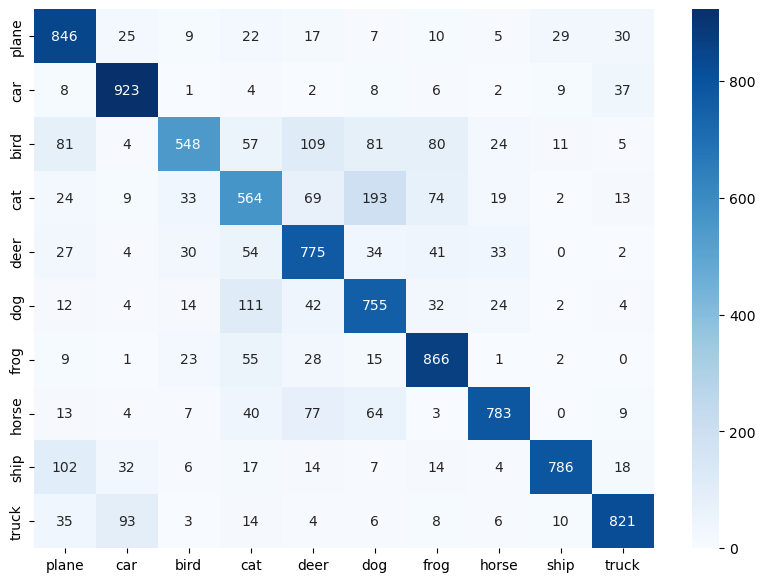

In [40]:
confusionMatrix = confusion_matrix(actualValues, predictions)

confusionMatrixDf = pd.DataFrame(confusionMatrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (10,7))
sns.heatmap(confusionMatrixDf, annot=True, cmap='Blues', fmt='g')